In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.losses import Huber
import tensorflow as tf
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the Minute level and News datasets.
minute_data = pd.read_csv('/content/drive/MyDrive/Stocks/Updated_Stocks_M.csv')
news_data = pd.read_csv('/content/drive/MyDrive/Stocks/Nasdaq_Articles_Sentiment.csv')

In [ ]:
# We are only using the data for the trading hours (9:30 AM to 4:00 PM).
minute_data['timestamp'] = pd.to_datetime(minute_data['timestamp'])
trading_hours_mask = ((minute_data['timestamp'].dt.hour == 9) & (minute_data['timestamp'].dt.minute >= 30)) | \
                          ((minute_data['timestamp'].dt.hour > 9) & (minute_data['timestamp'].dt.hour < 16)) | \
                          ((minute_data['timestamp'].dt.hour == 16) & (minute_data['timestamp'].dt.minute == 0))
minute_data = minute_data[trading_hours_mask]


In [ ]:
# Drop unnecessary columns from minute level data.
columns_to_drop = ['Company Name', 'number of transactions']
minute_data_cleaned = minute_data.drop(columns=columns_to_drop).reset_index(drop=True)

In [ ]:
stock_labels = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "BRK.B", "LLY", "AVGO", "TSLA", "WMT"]

In [ ]:
#Converting volume to INT type
minute_data_cleaned['volume'] = minute_data_cleaned['volume'].astype(int)

In [ ]:

# Process each stock separately.
merged_dataframes = []

for stock in stock_labels:
    print(f"Processing Stock: {stock}")
    stock_minute_data = minute_data_cleaned[minute_data_cleaned['Stock Symbol'] == stock].copy()
    stock_news_data = news_data[news_data['Stock Symbol'] == stock].copy()


    stock_minute_data['timestamp'] = pd.to_datetime(stock_minute_data['timestamp'], errors='coerce')
    stock_news_data['timestamp'] = pd.to_datetime(stock_news_data['timestamp'], errors='coerce')
    start_date = stock_minute_data['timestamp'].min()
    stock_news_data = stock_news_data[stock_news_data['timestamp'] >= start_date].copy()

    # Sort both datasets by 'timestamp'.
    stock_minute_data = stock_minute_data.sort_values(by='timestamp').reset_index(drop=True)
    stock_news_data = stock_news_data.sort_values(by='timestamp').reset_index(drop=True)
    stock_news_data['date'] = stock_news_data['timestamp'].dt.date
    stock_news_data = stock_news_data.sort_values('timestamp').groupby('date').tail(1).reset_index(drop=True)

    # Merge minute data with news data based on 'timestamp' for the current stock.
    try:
        stock_merged_data = pd.merge_asof(
            stock_minute_data,
            stock_news_data[['timestamp', 'Sentiment_Numerical', 'Sentiment_Score']],
            on='timestamp',
            direction='backward',
        ).reset_index(drop=True)
        stock_merged_data['Sentiment_Numerical'] = stock_merged_data['Sentiment_Numerical'].fillna(0)
        stock_merged_data['Sentiment_Score'] = stock_merged_data['Sentiment_Score'].fillna(0)

        merged_dataframes.append(stock_merged_data)

    except ValueError as e:
        print(f"Merge Error for {stock}: {e}")

# Concatenate all the merged data for all stocks and reorder them.
if merged_dataframes:
    merged_data = pd.concat(merged_dataframes, ignore_index=True)
    final_columns = ['Stock Symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'volume weighted average price',
                     'SMA_5', 'SMA_10',  'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26', 'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'Sentiment_Numerical', 'Sentiment_Score']
    merged_data = merged_data[final_columns]
else:
    print("No merged data available. Please check the stock data.")


Processing Stock: AAPL
Processing Stock: MSFT
Processing Stock: NVDA
Processing Stock: AMZN
Processing Stock: GOOGL
Processing Stock: BRK.B
Processing Stock: LLY
Processing Stock: AVGO
Processing Stock: TSLA
Processing Stock: WMT


In [ ]:
# One hot encode Sentiment_Numerical to the dataset.
def encode_sentiment(df):
    sentiment_mapping = {

        1: [1.0, 0.0, 0.0],
        0: [0.0, 1.0, 0.0],
        -1: [0.0, 0.0, 1.0]
    }
    sentiment_encoded = df['Sentiment_Numerical'].map(sentiment_mapping).tolist()
    sentiment_encoded_df = pd.DataFrame(sentiment_encoded, columns=['Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative'])
    df = pd.concat([df, sentiment_encoded_df], axis=1).reset_index(drop=True)
    df.drop(columns=['Sentiment_Numerical'], inplace=True)

    return df

# Applying the encoding function.
merged_data = encode_sentiment(merged_data)
news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']
# Ensure all sentiments column are present in the dataset.
def ensure_sentiment_columns(df, news_columns):
    for col in news_columns:
        if col not in df.columns:
            df[col] = 0.0
    return df
merged_data = ensure_sentiment_columns(merged_data, news_columns)

In [ ]:
pd.set_option('display.max_columns', None)
merged_data.head()

Stock Symbol           timestamp     open      high     low     close  \
0         AAPL 2021-01-04 09:30:00  133.520  133.6116  132.95  133.1500   
1         AAPL 2021-01-04 09:31:00  133.130  133.4500  133.08  133.3350   
2         AAPL 2021-01-04 09:32:00  133.345  133.3600  132.99  133.1100   
3         AAPL 2021-01-04 09:33:00  133.110  133.1500  132.71  132.7462   
4         AAPL 2021-01-04 09:34:00  132.760  132.8300  132.39  132.8100   

    volume  volume weighted average price      SMA_5     SMA_10     SMA_20  \
0  2454433                       133.4415  133.49200  133.54398  133.52649   
1   534463                       133.2944  133.43900  133.51948  133.51574   
2   526051                       133.1605  133.34100  133.46848  133.49274   
3   555529                       132.8156  133.17224  133.38312  133.45205   
4   744788                       132.6279  133.03024  133.30512  133.41605   

       SMA_50      SMA_60       EMA_9      EMA_12      EMA_26      RSI_7  \
0  133.669992  133.692827  133.485880  133.505544  133.564072  12.439643   
1  133.659492  133.685910  133.455704  133.479306  133.547104  36.792418   
2  133.643892  133.675243  133.386563  133.422490  133.514726  26.381346   
3  133.620816  133.657680  133.258491  133.318445  133.457798  17.200190   
4  133.599816  133.641347  133.168792  133.240223  133.409813  22.703986   

      RSI_14     RSI_21     RSI_30  MACD_Value  MACD_Histogram  MACD_Signal  \
0  22.740712  27.187009  30.610927   -0.058528       -0.015641    -0.042887   
1  37.765467  38.380116  39.138844   -0.067797       -0.019928    -0.047869   
2  30.098874  32.082089  33.897386   -0.092236       -0.035493    -0.056743   
3  22.238036  25.091745  27.693948   -0.139353       -0.066088    -0.073265   
4  25.893300  27.981284  30.017420   -0.169590       -0.077060    -0.092530   

   Sentiment_Score  Sentiment_Positive  Sentiment_Neutral  Sentiment_Negative  
0              0.0                 0.0                1.0                 0.0  
1              0.0                 0.0                1.0                 0.0  
2              0.0                 0.0                1.0                 0.0  
3              0.0                 0.0                1.0                 0.0  
4              0.0                 0.0                1.0                 0.0

In [ ]:
# Extracting timestamp features from the dataset.
def extract_timestamp_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    return df

merged_data = extract_timestamp_features(merged_data)
merged_data['granularity'] = 0.5

In [ ]:
# One hot encode Stock Symbol.
def encode_stock_symbol_before_aggregates(df, stock_labels):
    for label in stock_labels:
        df[label] = (df['Stock Symbol'] == label).astype('int32')
    return df
merged_data = encode_stock_symbol_before_aggregates(merged_data, stock_labels)


In [ ]:
# Derive hour-level aggregates using encoded stock symbols
hour_aggregates_list = []
for label in stock_labels:
    stock_data = merged_data[merged_data[label] == 1].copy()
    stock_data = stock_data[(stock_data['hour'] >= 9) & ((stock_data['hour'] < 16) | ((stock_data['hour'] == 16) & (stock_data['minute'] == 0)))]

    # Group by each hour ending (e.g., 9:30 to 10:30 is hour 10)
    stock_data['aggregation_hour'] = stock_data['hour'] + (stock_data['minute'] >= 30).astype(int)
    stock_data = stock_data[stock_data['aggregation_hour'] < 16]

    stock_hour_aggregates = stock_data.groupby(['year', 'month', 'day', 'aggregation_hour']).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'volume weighted average price': 'mean',
        'SMA_5': 'mean',
        'SMA_10': 'mean',
        'SMA_20': 'mean',
        'SMA_50': 'mean',
        'SMA_60': 'mean',
        'EMA_9': 'mean',
        'EMA_12': 'mean',
        'EMA_26': 'mean',
        'RSI_7': 'mean',
        'RSI_14': 'mean',
        'RSI_21': 'mean',
        'RSI_30': 'mean',
        'MACD_Value': 'mean',
        'MACD_Histogram': 'mean',
        'MACD_Signal': 'mean',
        'Sentiment_Score': 'max'
    }).reset_index()

    # Align the sentiment columns with the max sentiment score
    aligned_sentiment_data = stock_data.loc[stock_data.groupby(['year', 'month', 'day', 'aggregation_hour'])['Sentiment_Score'].idxmax()][['Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']].reset_index(drop=True)
    stock_hour_aggregates = pd.concat([stock_hour_aggregates, aligned_sentiment_data], axis=1)

    # Set the hour to be the ending hour and minute to 30 to represent the midpoint
    stock_hour_aggregates['hour'] = stock_hour_aggregates['aggregation_hour']
    stock_hour_aggregates['minute'] = 30
    stock_hour_aggregates['granularity'] = 1
    stock_hour_aggregates.drop(columns=['aggregation_hour'], inplace=True)

    # Add encoded stock symbol labels
    for lbl in stock_labels:
        stock_hour_aggregates[lbl] = 1 if lbl == label else 0

    hour_aggregates_list.append(stock_hour_aggregates)

# Concatenate all hour-level aggregates
hour_aggregates = pd.concat(hour_aggregates_list, ignore_index=True).fillna(0)

# Derive day-level aggregates using encoded stock symbols
day_aggregates_list = []
for label in stock_labels:
    stock_data = merged_data[merged_data[label] == 1].copy()
    stock_data = stock_data[(stock_data['hour'] >= 9) & ((stock_data['hour'] < 16) | ((stock_data['hour'] == 16) & (stock_data['minute'] == 0)))]

    # Group by day and aggregate each column differently
    stock_day_aggregates = stock_data.groupby(['year', 'month', 'day']).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'volume weighted average price': 'mean',
        'SMA_5': 'mean',
        'SMA_10': 'mean',
        'SMA_20': 'mean',
        'SMA_50': 'mean',
        'SMA_60': 'mean',
        'EMA_9': 'mean',
        'EMA_12': 'mean',
        'EMA_26': 'mean',
        'RSI_7': 'mean',
        'RSI_14': 'mean',
        'RSI_21': 'mean',
        'RSI_30': 'mean',
        'MACD_Value': 'mean',
        'MACD_Histogram': 'mean',
        'MACD_Signal': 'mean',
        'Sentiment_Score': 'max'
    }).reset_index()

    # Align the sentiment columns with the max sentiment score
    aligned_sentiment_data = stock_data.loc[stock_data.groupby(['year', 'month', 'day'])['Sentiment_Score'].idxmax()][['Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']].reset_index(drop=True)
    stock_day_aggregates = pd.concat([stock_day_aggregates, aligned_sentiment_data], axis=1)

    # Set hour and minute to represent the end of the trading day
    stock_day_aggregates['hour'] = 16
    stock_day_aggregates['minute'] = 0
    stock_day_aggregates['granularity'] = 0

    # Add encoded stock symbol labels
    for lbl in stock_labels:
        stock_day_aggregates[lbl] = 1 if lbl == label else 0

    day_aggregates_list.append(stock_day_aggregates)

# Concatenate all day-level aggregates
day_aggregates = pd.concat(day_aggregates_list, ignore_index=True).fillna(0)

# Combine minute, hour, and day-level data
combined_data_cleaned = pd.concat([merged_data, hour_aggregates, day_aggregates], ignore_index=True)
combined_data_cleaned = combined_data_cleaned.sort_values(by=['year', 'month', 'day', 'hour', 'minute']).reset_index(drop=True)

# Drop unnecessary columns and reorder
final_columns = ['open', 'high', 'low', 'close', 'volume', 'volume weighted average price',  'SMA_5', 'SMA_10',  'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26', 'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative', 'year', 'month', 'day', 'hour', 'minute', 'granularity',
                 ] + stock_labels
combined_data_cleaned = combined_data_cleaned[final_columns]




In [ ]:
# Create a mapping of stock labels to their priority
stock_priority = {stock: i for i, stock in enumerate(stock_labels)}

# Add a 'stock_priority' column based on the stock order
combined_data_cleaned['stock_priority'] = combined_data_cleaned[stock_labels].dot(
    pd.Series(stock_priority)
)

# Sort by stock priority, timestamp features, and granularity
combined_data_cleaned = combined_data_cleaned.sort_values(
    by=['stock_priority', 'year', 'month', 'day', 'hour', 'minute', 'granularity'],
    ascending=[True, True, True, True, True, True, False]  # Descending for granularity
).reset_index(drop=True)

# Drop the temporary 'stock_priority' column
combined_data_cleaned.drop(columns=['stock_priority'], inplace=True)

# Reorder columns
final_columns = ['open', 'high', 'low', 'close', 'volume', 'volume weighted average price',
                 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
                 'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal',
                 'Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative',
                 'year', 'month', 'day', 'hour', 'minute', 'granularity'] + stock_labels

combined_data_cleaned = combined_data_cleaned[final_columns]

# Remove exact duplicate rows
combined_data_cleaned = combined_data_cleaned.drop_duplicates()

# Verify duplicates are removed
remaining_duplicates = combined_data_cleaned.duplicated()
if remaining_duplicates.sum() > 0:
    print(f"Number of remaining duplicate rows: {remaining_duplicates.sum()}")
else:
    print("No duplicate rows remain in the dataset.")

No duplicate rows remain in the dataset.


In [ ]:
pd.set_option('display.max_columns', None)
combined_data_cleaned.head(10)

open      high     low     close   volume  \
0  133.5200  133.6116  132.95  133.1500  2454433   
1  133.1300  133.4500  133.08  133.3350   534463   
2  133.3450  133.3600  132.99  133.1100   526051   
3  133.1100  133.1500  132.71  132.7462   555529   
4  132.7600  132.8300  132.39  132.8100   744788   
5  132.8300  132.8900  132.60  132.6355   440365   
6  132.6300  132.6400  132.27  132.3200   375356   
7  132.3100  132.3500  132.13  132.2000   462544   
8  132.2100  132.2200  131.81  131.9200   728915   
9  131.9285  132.1300  131.88  131.8900   534217   

   volume weighted average price      SMA_5     SMA_10      SMA_20  \
0                       133.4415  133.49200  133.54398  133.526490   
1                       133.2944  133.43900  133.51948  133.515740   
2                       133.1605  133.34100  133.46848  133.492740   
3                       132.8156  133.17224  133.38312  133.452050   
4                       132.6279  133.03024  133.30512  133.416050   
5                       132.7546  132.92734  133.20967  133.372825   
6                       132.4313  132.72434  133.08167  133.316825   
7                       132.2356  132.54234  132.94167  133.257325   
8                       132.0061  132.37710  132.77467  133.176825   
9                       132.0357  132.19310  132.61167  133.097825   

       SMA_50      SMA_60       EMA_9      EMA_12      EMA_26      RSI_7  \
0  133.669992  133.692827  133.485880  133.505544  133.564072  12.439643   
1  133.659492  133.685910  133.455704  133.479306  133.547104  36.792418   
2  133.643892  133.675243  133.386563  133.422490  133.514726  26.381346   
3  133.620816  133.657680  133.258491  133.318445  133.457798  17.200190   
4  133.599816  133.641347  133.168792  133.240223  133.409813  22.703986   
5  133.575126  133.621772  133.062134  133.147189  133.352456  18.731012   
6  133.545926  133.596438  132.913707  133.019929  133.275978  13.681087   
7  133.514526  133.569105  132.770966  132.893786  133.196276  12.219256   
8  133.477326  133.537272  132.600773  132.743973  133.101737   9.465902   
9  133.439726  133.504938  132.458618  132.612592  133.011979   9.206588   

      RSI_14     RSI_21     RSI_30  MACD_Value  MACD_Histogram  MACD_Signal  \
0  22.740712  27.187009  30.610927   -0.058528       -0.015641    -0.042887   
1  37.765467  38.380116  39.138844   -0.067797       -0.019928    -0.047869   
2  30.098874  32.082089  33.897386   -0.092236       -0.035493    -0.056743   
3  22.238036  25.091745  27.693948   -0.139353       -0.066088    -0.073265   
4  25.893300  27.981284  30.017420   -0.169590       -0.077060    -0.092530   
5  22.744231  25.190653  27.515686   -0.205268       -0.090190    -0.115077   
6  18.389564  21.180475  23.804934   -0.256049       -0.112778    -0.143272   
7  17.052255  19.914391  22.605435   -0.302490       -0.127375    -0.175115   
8  14.417645  17.370466  20.154133   -0.357764       -0.146119    -0.211645   
9  14.165121  17.124370  19.914777   -0.399386       -0.150193    -0.249193   

   Sentiment_Score  Sentiment_Positive  Sentiment_Neutral  Sentiment_Negative  \
0              0.0                 0.0                1.0                 0.0   
1              0.0                 0.0                1.0                 0.0   
2              0.0                 0.0                1.0                 0.0   
3              0.0                 0.0                1.0                 0.0   
4              0.0                 0.0                1.0                 0.0   
5              0.0                 0.0                1.0                 0.0   
6              0.0                 0.0                1.0                 0.0   
7              0.0                 0.0                1.0                 0.0   
8              0.0                 0.0                1.0                 0.0   
9              0.0                 0.0                1.0                 0.0   

   year  month  day  hour  minute  granularity  AAPL  MSFT  NVDA

In [ ]:
pd.set_option('display.max_columns', None)
combined_data_cleaned.tail(10)

open    high     low   close    volume  \
3635541  77.400  77.410  77.330  77.395    102674   
3635542  77.390  77.420  77.350  77.375    124586   
3635543  77.370  77.400  77.340  77.380    162464   
3635544  77.390  77.400  77.280  77.305    148043   
3635545  77.300  77.380  77.290  77.345    164021   
3635546  77.345  77.370  77.335  77.355    173308   
3635547  77.355  77.355  77.270  77.320    236888   
3635548  77.320  77.340  77.210  77.220    437806   
3635549  77.230  77.230  77.200  77.200    341737   
3635550  76.440  77.475  76.220  77.200  10441215   

         volume weighted average price      SMA_5     SMA_10     SMA_20  \
3635541                      77.381400  77.317000  77.230200  77.226100   
3635542                      77.385100  77.365000  77.250000  77.234850   
3635543                      77.371500  77.393020  77.272500  77.244600   
3635544                      77.329700  77.370000  77.292000  77.248600   
3635545                      77.339300  77.360000  77.312000  77.252850   
3635546                      77.354800  77.352000  77.334500  77.256600   
3635547                      77.311000  77.341000  77.353000  77.258350   
3635548                      77.288100  77.309000  77.351010  77.259100   
3635549                      77.230000  77.288000  77.329000  77.261350   
3635550                      76.752626  76.749542  76.744394  76.733271   

            SMA_50     SMA_60      EMA_9     EMA_12     EMA_26      RSI_7  \
3635541  77.155104  77.141420  77.285246  77.265535  77.219588  74.127342   
3635542  77.160304  77.145753  77.303197  77.282376  77.231100  69.160204   
3635543  77.167644  77.150587  77.318558  77.297395  77.242129  69.751384   
3635544  77.173944  77.154837  77.315846  77.298565  77.246786  52.230052   
3635545  77.179944  77.159753  77.321677  77.305709  77.254061  58.687248   
3635546  77.185844  77.165087  77.328342  77.313292  77.261538  60.254240   
3635547  77.191042  77.169420  77.326673  77.314324  77.265869  52.173559   
3635548  77.194242  77.172087  77.305339  77.299813  77.262471  36.055555   
3635549  77.196942  77.174253  77.284271  77.284457  77.257844  33.631284   
3635550  76.703337  76.694600  76.745189  76.742017  76.727795  55.470869   

            RSI_14     RSI_21     RSI_30  MACD_Value  MACD_Histogram  \
3635541  67.469691  65.340723  63.623277    0.045927        0.021670   
3635542  64.895216  63.465502  62.193732    0.051257        0.021600   
3635543  65.252186  63.738678  62.412152    0.055248        0.020473   
3635544  56.045880  57.023290  57.277326    0.051762        0.013589   
3635545  59.340714  59.417670  59.132386    0.051632        0.010767   
3635546  60.145056  60.002622  59.586215    0.051739        0.008700   
3635547  55.971549  56.984097  57.283023    0.048442        0.004322   
3635548  46.123689  49.511795  51.409690    0.037329       -0.005433   
3635549  44.439621  48.184916  50.341766    0.026602       -0.012928   
3635550  55.490283  55.400188  55.194088    0.014100        0.000239   

         MACD_Signal  Sentiment_Score  Sentiment_Positive  Sentiment_Neutral  \
3635541     0.024257         0.807864                 0.0                1.0   
3635542     0.029657         0.807864                 0.0                1.0   
3635543     0.034775         0.807864                 0.0                1.0   
3635544     0.038173         0.807864                 0.0                1.0   
3635545     0.040865         0.807864                 0.0                1.0   
3635546     0.043040         0.807864                 0.0                1.0   
3635547     0.044120         0.807864                 0.0                1.0   
3635548     0.042762         0.807864                 0.0                1.0   
3635549     0.039530         0.807864                 0.0                1.0   
3635550     0.013860         0.916470                 1.0                0.0   

         Sentiment_Negative  year  month  day  hour  minute  granularity  \
363

Num GPUs Available:  0
Epoch 1/10
1905/1905 [==============================] - 23s 12ms/step - loss: 0.0054 - val_loss: 9.9359e-05
Epoch 2/10
1905/1905 [==============================] - 22s 12ms/step - loss: 1.4560e-05 - val_loss: 2.9739e-05
Epoch 3/10
1905/1905 [==============================] - 23s 12ms/step - loss: 1.7247e-05 - val_loss: 1.2022e-04
Epoch 4/10
1905/1905 [==============================] - 23s 12ms/step - loss: 1.4966e-05 - val_loss: 2.0278e-05
Epoch 5/10
1905/1905 [==============================] - 21s 11ms/step - loss: 1.4036e-05 - val_loss: 1.1351e-05
Epoch 6/10
1905/1905 [==============================] - 22s 11ms/step - loss: 1.2663e-05 - val_loss: 3.1302e-05
Epoch 7/10
1905/1905 [==============================] - 22s 12ms/step - loss: 1.2385e-05 - val_loss: 2.9760e-05
Epoch 8/10
1905/1905 [==============================] - 21s 11ms/step - loss: 1.0919e-05 - val_loss: 2.3076e-05
Epoch 9/10
1905/1905 [==============================] - 23s 12ms/step - loss: 1.1616e

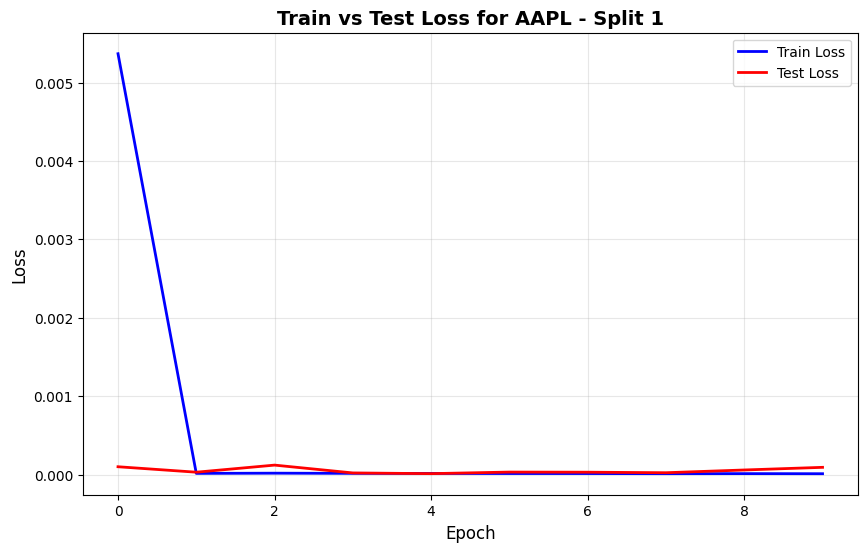

1905/1905 [==============================] - 7s 3ms/step


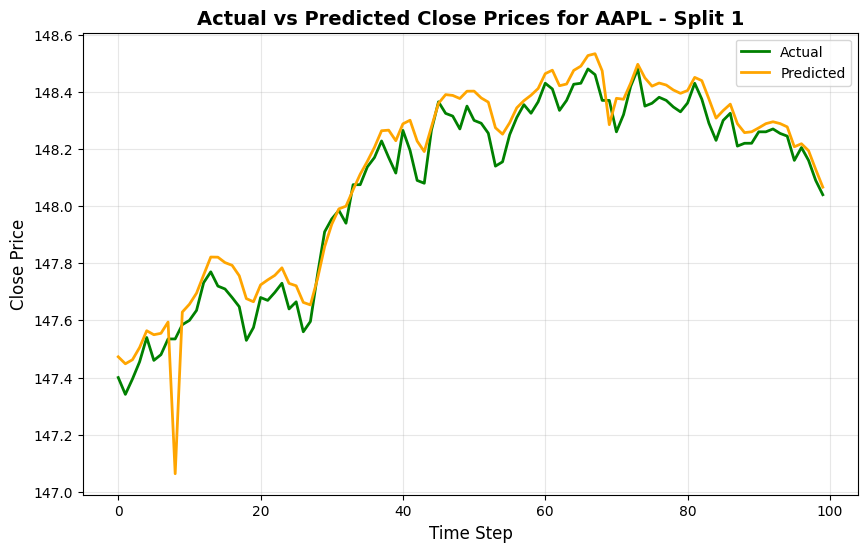

Epoch 1/10
3809/3809 [==============================] - 39s 10ms/step - loss: 7.4251e-04 - val_loss: 3.5986e-05
Epoch 2/10
3809/3809 [==============================] - 36s 10ms/step - loss: 1.7678e-05 - val_loss: 1.3136e-05
Epoch 3/10
3809/3809 [==============================] - 35s 9ms/step - loss: 1.3308e-05 - val_loss: 6.5035e-06
Epoch 4/10
3809/3809 [==============================] - 36s 9ms/step - loss: 1.1283e-05 - val_loss: 4.7922e-06
Epoch 5/10
3809/3809 [==============================] - 36s 10ms/step - loss: 8.5988e-06 - val_loss: 4.2663e-05
Epoch 6/10
3809/3809 [==============================] - 36s 9ms/step - loss: 7.4952e-06 - val_loss: 3.7285e-06
Epoch 7/10
3809/3809 [==============================] - 34s 9ms/step - loss: 6.8249e-06 - val_loss: 3.1025e-06
Epoch 8/10
3809/3809 [==============================] - 36s 10ms/step - loss: 5.4554e-06 - val_loss: 6.0371e-06
Epoch 9/10
3809/3809 [==============================] - 37s 10ms/step - loss: 4.9453e-06 - val_loss: 3.3402e

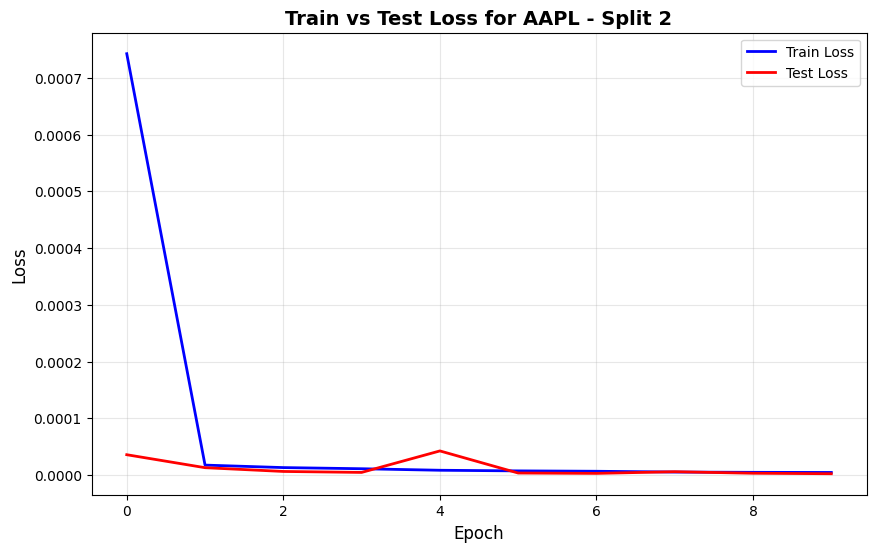

1905/1905 [==============================] - 7s 3ms/step


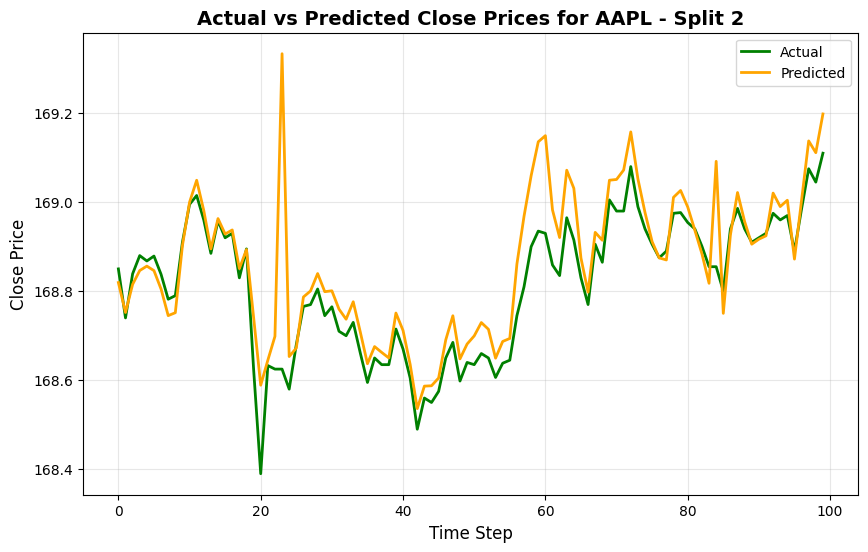

Epoch 1/10
5714/5714 [==============================] - 54s 9ms/step - loss: 4.0899e-04 - val_loss: 2.1975e-05
Epoch 2/10
5714/5714 [==============================] - 50s 9ms/step - loss: 8.8853e-06 - val_loss: 6.3865e-06
Epoch 3/10
5714/5714 [==============================] - 49s 9ms/step - loss: 6.9422e-06 - val_loss: 3.6200e-06
Epoch 4/10
5714/5714 [==============================] - 50s 9ms/step - loss: 5.7484e-06 - val_loss: 3.3259e-06
Epoch 5/10
5714/5714 [==============================] - 50s 9ms/step - loss: 4.7260e-06 - val_loss: 3.4424e-06
Epoch 6/10
5714/5714 [==============================] - 46s 8ms/step - loss: 4.2295e-06 - val_loss: 2.4307e-06
Epoch 7/10
5714/5714 [==============================] - 47s 8ms/step - loss: 3.8234e-06 - val_loss: 2.0171e-06
Epoch 8/10
5714/5714 [==============================] - 52s 9ms/step - loss: 3.6135e-06 - val_loss: 1.8844e-06
Epoch 9/10
5714/5714 [==============================] - 47s 8ms/step - loss: 3.3371e-06 - val_loss: 1.9936e-06
E

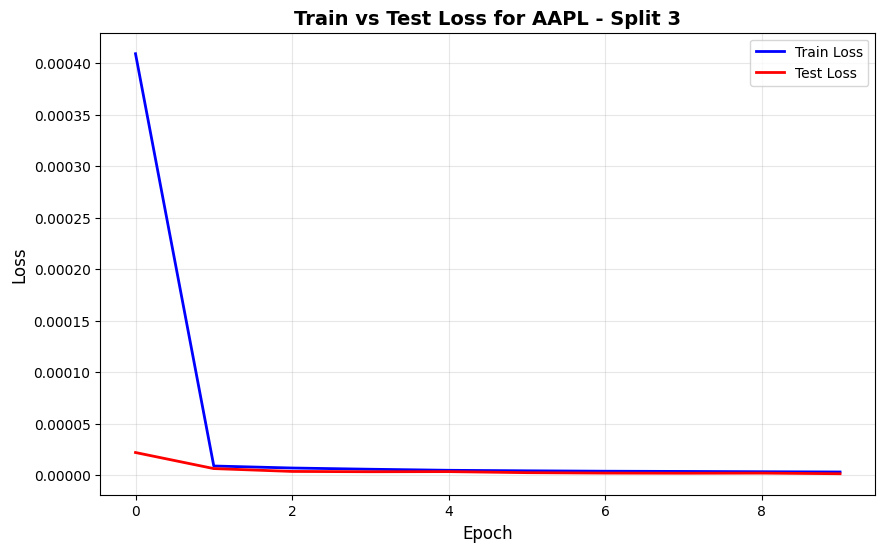

1905/1905 [==============================] - 6s 3ms/step


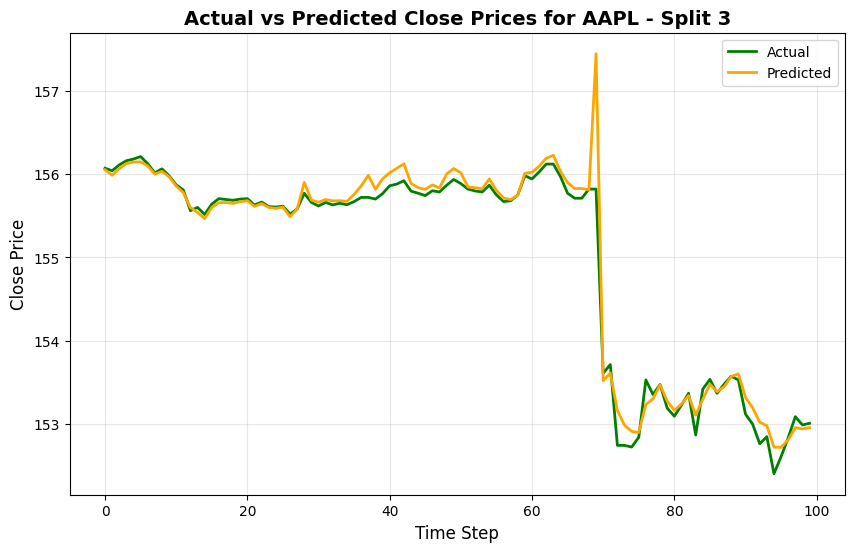

Epoch 1/10
7618/7618 [==============================] - 67s 9ms/step - loss: 3.1456e-04 - val_loss: 4.3488e-04
Epoch 2/10
7618/7618 [==============================] - 65s 8ms/step - loss: 8.5281e-06 - val_loss: 2.2021e-04
Epoch 3/10
7618/7618 [==============================] - 67s 9ms/step - loss: 6.2899e-06 - val_loss: 5.9119e-04
Epoch 4/10
7618/7618 [==============================] - 60s 8ms/step - loss: 4.7840e-06 - val_loss: 9.1084e-05
Epoch 5/10
7618/7618 [==============================] - 63s 8ms/step - loss: 4.1551e-06 - val_loss: 4.1242e-05
Epoch 6/10
7618/7618 [==============================] - 62s 8ms/step - loss: 3.8470e-06 - val_loss: 2.8044e-05
Epoch 7/10
7618/7618 [==============================] - 65s 9ms/step - loss: 3.4580e-06 - val_loss: 2.1027e-05
Epoch 8/10
7618/7618 [==============================] - 62s 8ms/step - loss: 3.1327e-06 - val_loss: 1.1654e-05
Epoch 9/10
7618/7618 [==============================] - 65s 9ms/step - loss: 3.1726e-06 - val_loss: 1.2895e-05
E

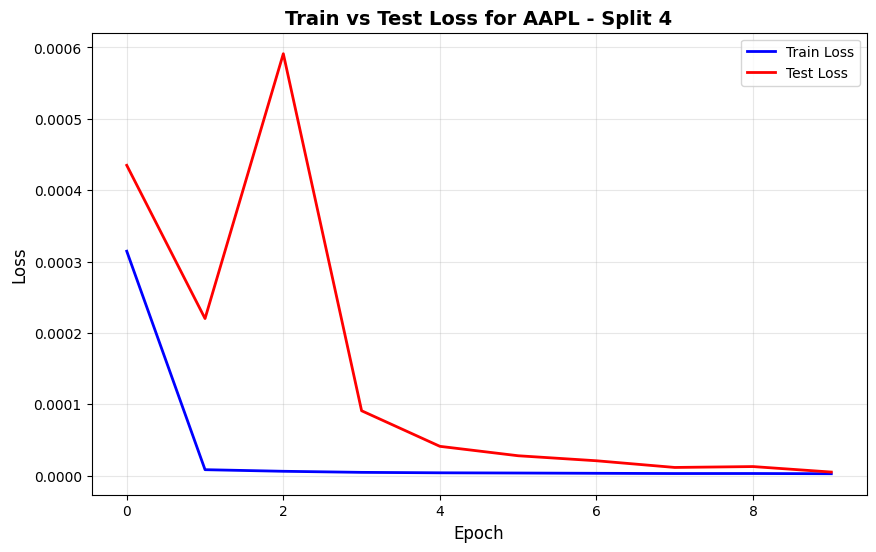

1905/1905 [==============================] - 7s 3ms/step


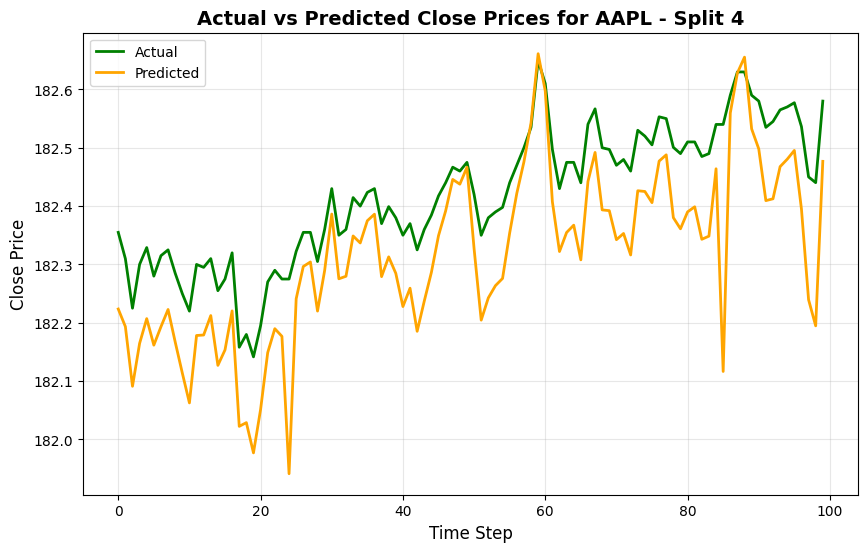

Epoch 1/10
9523/9523 [==============================] - 79s 8ms/step - loss: 6.7161e-04 - val_loss: 2.0787e-05
Epoch 2/10
9523/9523 [==============================] - 83s 9ms/step - loss: 5.7331e-06 - val_loss: 1.8375e-04
Epoch 3/10
9523/9523 [==============================] - 80s 8ms/step - loss: 4.2335e-06 - val_loss: 6.3734e-05
Epoch 4/10
9523/9523 [==============================] - 80s 8ms/step - loss: 3.3145e-06 - val_loss: 2.9514e-04
Epoch 5/10
9523/9523 [==============================] - 76s 8ms/step - loss: 2.8526e-06 - val_loss: 3.4943e-04
Epoch 6/10
9523/9523 [==============================] - 82s 9ms/step - loss: 2.4587e-06 - val_loss: 1.7671e-04
Epoch 7/10
9523/9523 [==============================] - 81s 9ms/step - loss: 2.3053e-06 - val_loss: 2.3294e-04
Epoch 8/10
9523/9523 [==============================] - 81s 8ms/step - loss: 2.2252e-06 - val_loss: 9.7168e-05
Epoch 9/10
9523/9523 [==============================] - 80s 8ms/step - loss: 2.0166e-06 - val_loss: 1.0793e-04
E

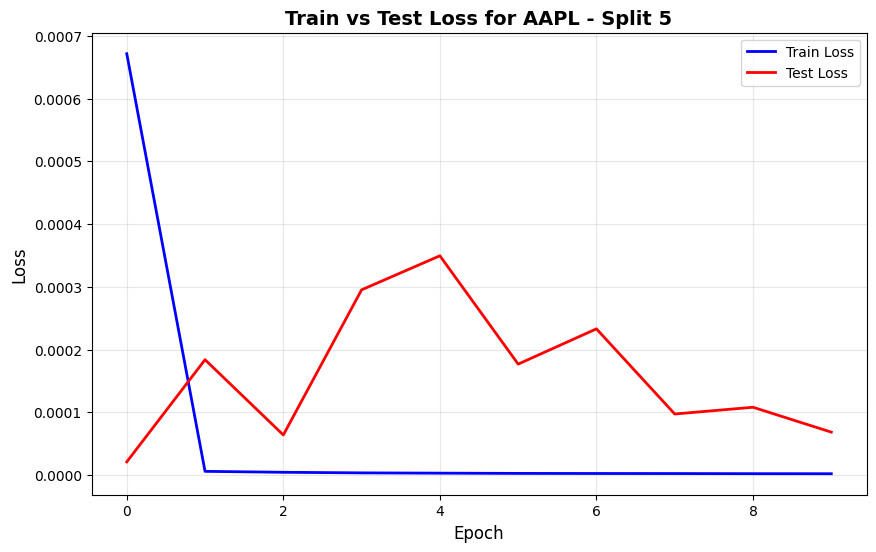

1905/1905 [==============================] - 7s 3ms/step


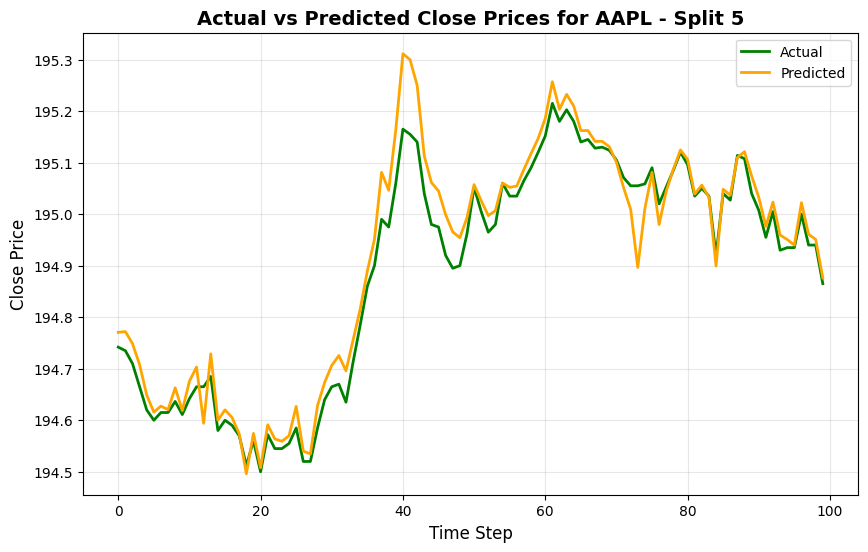

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: AAPL. Model, scalers, and graphs saved.
Epoch 1/10
1905/1905 [==============================] - 23s 11ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 2/10
1905/1905 [==============================] - 19s 10ms/step - loss: 1.2101e-05 - val_loss: 0.0047
Epoch 3/10
1905/1905 [==============================] - 21s 11ms/step - loss: 1.4195e-05 - val_loss: 0.0029
Epoch 4/10
1905/1905 [==============================] - 22s 12ms/step - loss: 9.6622e-06 - val_loss: 0.0031
Epoch 5/10
1905/1905 [==============================] - 22s 12ms/step - loss: 1.2075e-05 - val_loss: 0.0031
Epoch 6/10
1905/1905 [==============================] - 21s 11ms/step - loss: 8.8307e-06 - val_loss: 0.0021
Epoch 7/10
1905/1905 [==============================] - 22s 11ms/step - loss: 9.3683e-06 - val_loss: 0.0018
Epoch 8/10
1905/1905 [==============================] - 21s 11ms/step - loss: 7.9496e-06 - val_loss: 9.8616e-04
Epoch 9/10
1905/1905 [==============================] - 19s 10ms/step - los

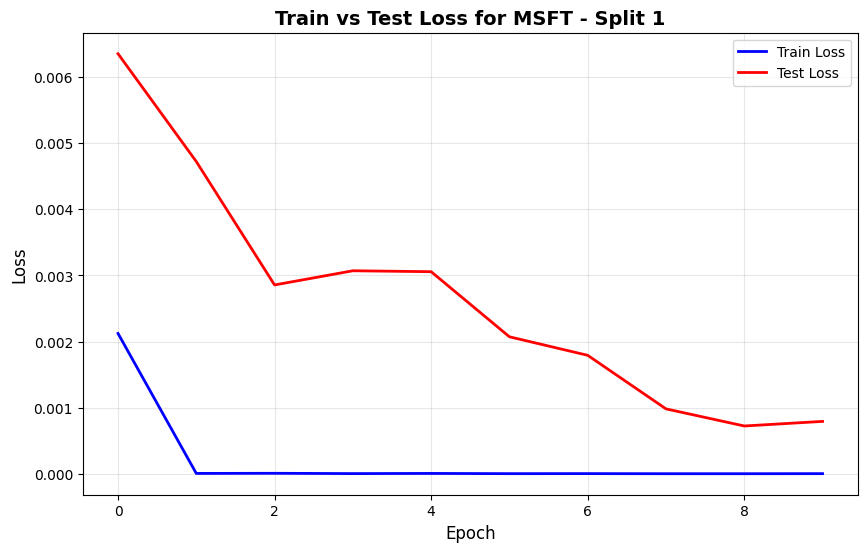

1905/1905 [==============================] - 7s 4ms/step


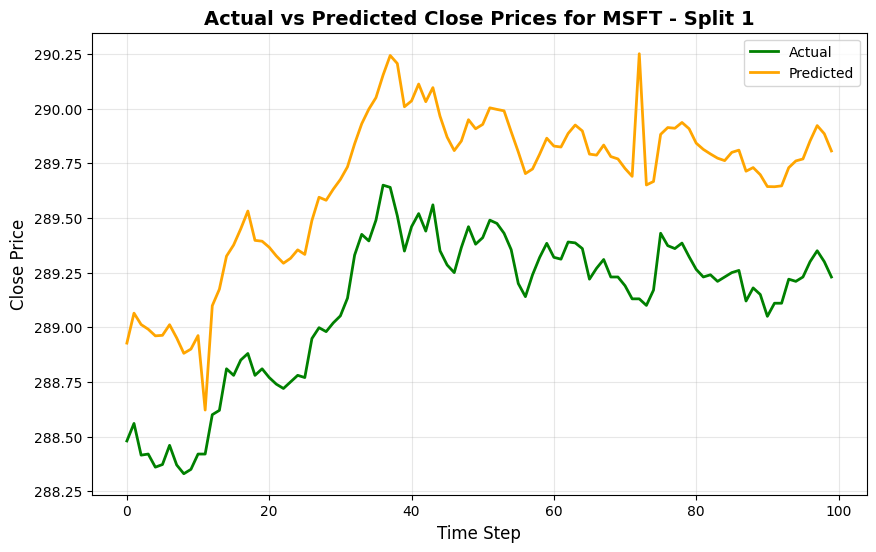

Epoch 1/10
3809/3809 [==============================] - 35s 9ms/step - loss: 0.0012 - val_loss: 1.2223e-05
Epoch 2/10
3809/3809 [==============================] - 34s 9ms/step - loss: 1.1568e-05 - val_loss: 3.3557e-06
Epoch 3/10
3809/3809 [==============================] - 35s 9ms/step - loss: 8.9153e-06 - val_loss: 2.7299e-06
Epoch 4/10
3809/3809 [==============================] - 34s 9ms/step - loss: 7.1617e-06 - val_loss: 6.9805e-06
Epoch 5/10
3809/3809 [==============================] - 37s 10ms/step - loss: 6.4260e-06 - val_loss: 4.3239e-06
Epoch 6/10
3809/3809 [==============================] - 37s 10ms/step - loss: 5.9581e-06 - val_loss: 2.4868e-06
Epoch 7/10
3809/3809 [==============================] - 37s 10ms/step - loss: 5.3368e-06 - val_loss: 1.8906e-06
Epoch 8/10
3809/3809 [==============================] - 38s 10ms/step - loss: 4.5380e-06 - val_loss: 2.1833e-06
Epoch 9/10
3809/3809 [==============================] - 36s 10ms/step - loss: 4.4209e-06 - val_loss: 1.5928e-05


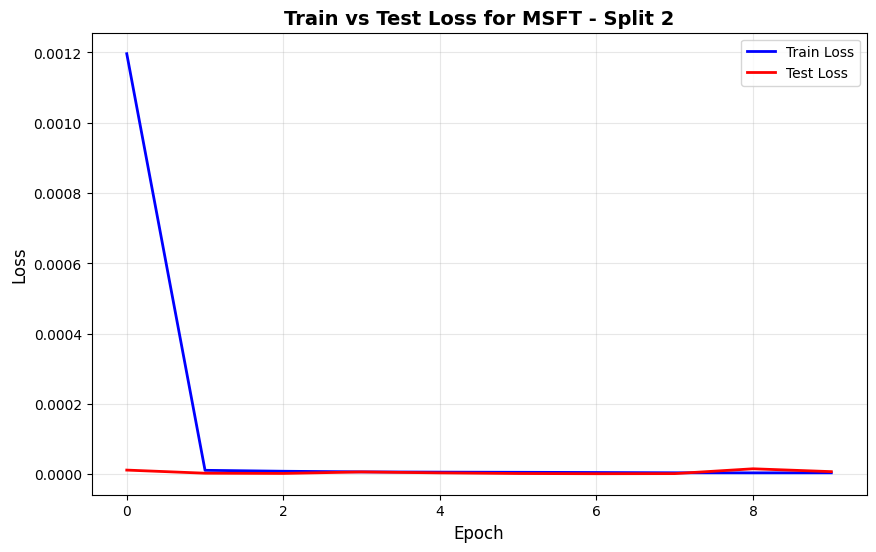

1905/1905 [==============================] - 7s 3ms/step


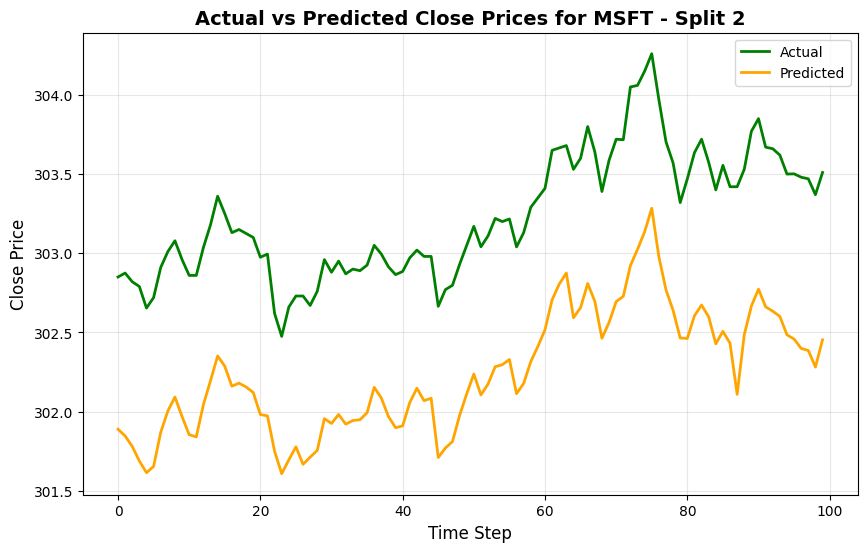

Epoch 1/10
5714/5714 [==============================] - 53s 9ms/step - loss: 4.0158e-04 - val_loss: 1.0868e-05
Epoch 2/10
5714/5714 [==============================] - 50s 9ms/step - loss: 1.0255e-05 - val_loss: 7.8962e-06
Epoch 3/10
5714/5714 [==============================] - 51s 9ms/step - loss: 7.0824e-06 - val_loss: 2.8747e-06
Epoch 4/10
5714/5714 [==============================] - 51s 9ms/step - loss: 5.4639e-06 - val_loss: 1.6182e-05
Epoch 5/10
5714/5714 [==============================] - 51s 9ms/step - loss: 4.6097e-06 - val_loss: 1.2167e-05
Epoch 6/10
5714/5714 [==============================] - 50s 9ms/step - loss: 4.2092e-06 - val_loss: 1.6288e-06
Epoch 7/10
5714/5714 [==============================] - 45s 8ms/step - loss: 3.6326e-06 - val_loss: 1.0407e-05
Epoch 8/10
5714/5714 [==============================] - 49s 9ms/step - loss: 3.4621e-06 - val_loss: 1.3631e-06
Epoch 9/10
5714/5714 [==============================] - 51s 9ms/step - loss: 3.0760e-06 - val_loss: 1.3690e-06
E

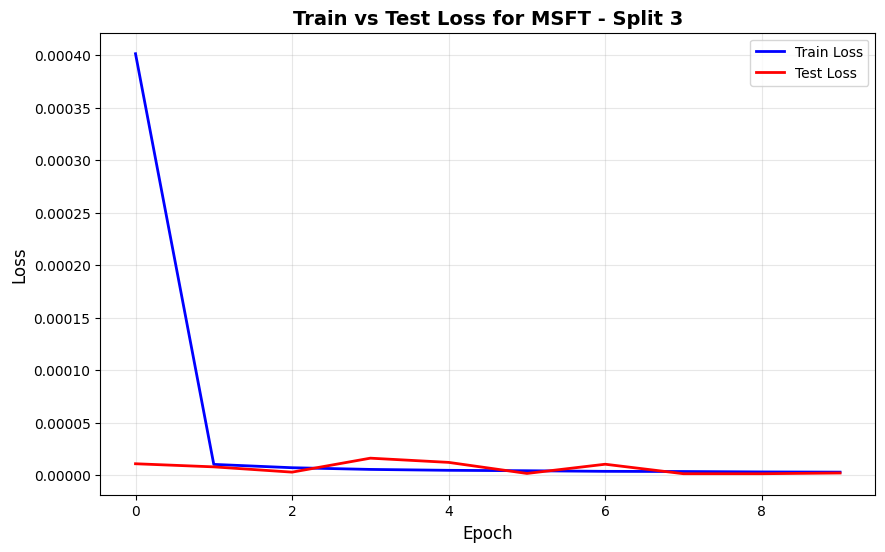

1905/1905 [==============================] - 7s 4ms/step


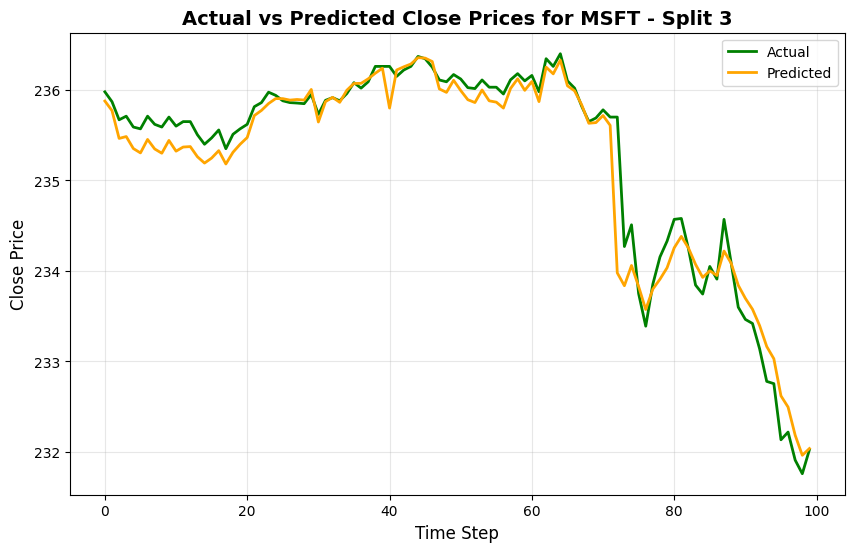

Epoch 1/10
7618/7618 [==============================] - 64s 8ms/step - loss: 2.8989e-04 - val_loss: 2.3279e-04
Epoch 2/10
7618/7618 [==============================] - 63s 8ms/step - loss: 7.6285e-06 - val_loss: 1.9029e-05
Epoch 3/10
7618/7618 [==============================] - 64s 8ms/step - loss: 4.8620e-06 - val_loss: 4.9084e-05
Epoch 4/10
7618/7618 [==============================] - 65s 9ms/step - loss: 4.0511e-06 - val_loss: 5.6555e-04
Epoch 5/10
7618/7618 [==============================] - 67s 9ms/step - loss: 3.3632e-06 - val_loss: 0.0011
Epoch 6/10
7618/7618 [==============================] - 67s 9ms/step - loss: 2.7866e-06 - val_loss: 0.0014
Epoch 7/10
7618/7618 [==============================] - 67s 9ms/step - loss: 2.5882e-06 - val_loss: 0.0023
Epoch 8/10
7618/7618 [==============================] - 65s 8ms/step - loss: 2.5779e-06 - val_loss: 0.0103
Epoch 9/10
7618/7618 [==============================] - 66s 9ms/step - loss: 2.3918e-06 - val_loss: 0.0106
Epoch 10/10
7618/7618

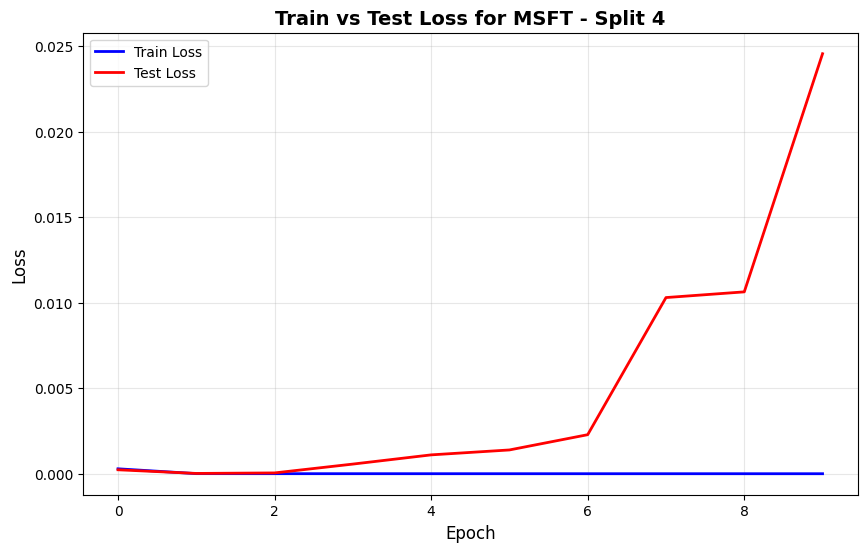

1905/1905 [==============================] - 7s 4ms/step


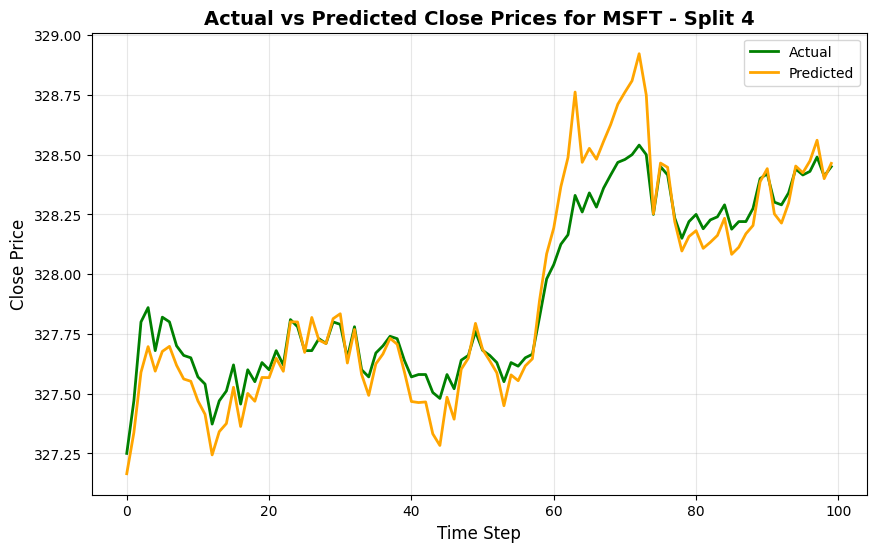

Epoch 1/10
9523/9523 [==============================] - 85s 9ms/step - loss: 3.4769e-04 - val_loss: 4.2558e-04
Epoch 2/10
9523/9523 [==============================] - 77s 8ms/step - loss: 6.2790e-06 - val_loss: 9.5805e-05
Epoch 3/10
9523/9523 [==============================] - 72s 8ms/step - loss: 4.2346e-06 - val_loss: 2.7570e-04
Epoch 4/10
9523/9523 [==============================] - 81s 9ms/step - loss: 3.1197e-06 - val_loss: 8.7511e-05
Epoch 5/10
9523/9523 [==============================] - 73s 8ms/step - loss: 2.5412e-06 - val_loss: 2.0287e-04
Epoch 6/10
9523/9523 [==============================] - 71s 7ms/step - loss: 2.1318e-06 - val_loss: 1.1573e-04
Epoch 7/10
9523/9523 [==============================] - 73s 8ms/step - loss: 1.8989e-06 - val_loss: 1.9417e-05
Epoch 8/10
9523/9523 [==============================] - 70s 7ms/step - loss: 1.6601e-06 - val_loss: 5.0261e-05
Epoch 9/10
9523/9523 [==============================] - 74s 8ms/step - loss: 1.5435e-06 - val_loss: 4.4742e-06
E

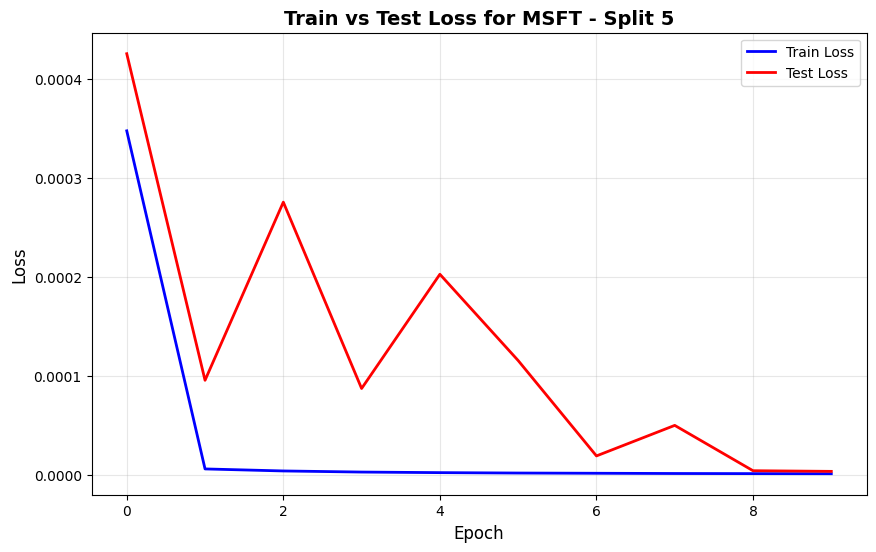

1905/1905 [==============================] - 7s 4ms/step


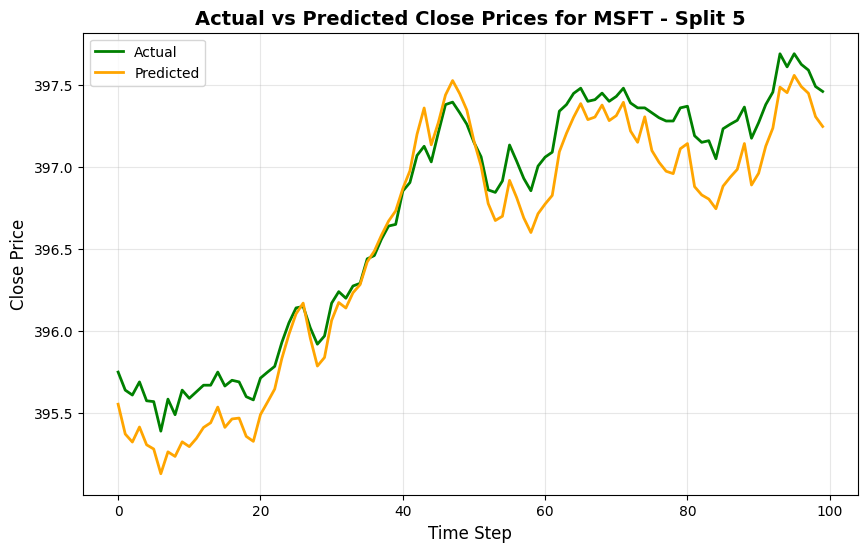

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: MSFT. Model, scalers, and graphs saved.
Epoch 1/10
1905/1905 [==============================] - 24s 12ms/step - loss: 9.6938e-04 - val_loss: 0.2425
Epoch 2/10
1905/1905 [==============================] - 21s 11ms/step - loss: 1.8111e-05 - val_loss: 0.1381
Epoch 3/10
1905/1905 [==============================] - 21s 11ms/step - loss: 1.6982e-05 - val_loss: 0.0709
Epoch 4/10
1905/1905 [==============================] - 21s 11ms/step - loss: 1.4857e-05 - val_loss: 0.0337
Epoch 5/10
1905/1905 [==============================] - 22s 11ms/step - loss: 1.1063e-05 - val_loss: 0.0368
Epoch 6/10
1905/1905 [==============================] - 21s 11ms/step - loss: 9.2364e-06 - val_loss: 0.0147
Epoch 7/10
1905/1905 [==============================] - 22s 12ms/step - loss: 8.8718e-06 - val_loss: 0.0271
Epoch 8/10
1905/1905 [==============================] - 21s 11ms/step - loss: 8.7747e-06 - val_loss: 0.0229
Epoch 9/10
1905/1905 [==============================] - 20s 10ms/step - los

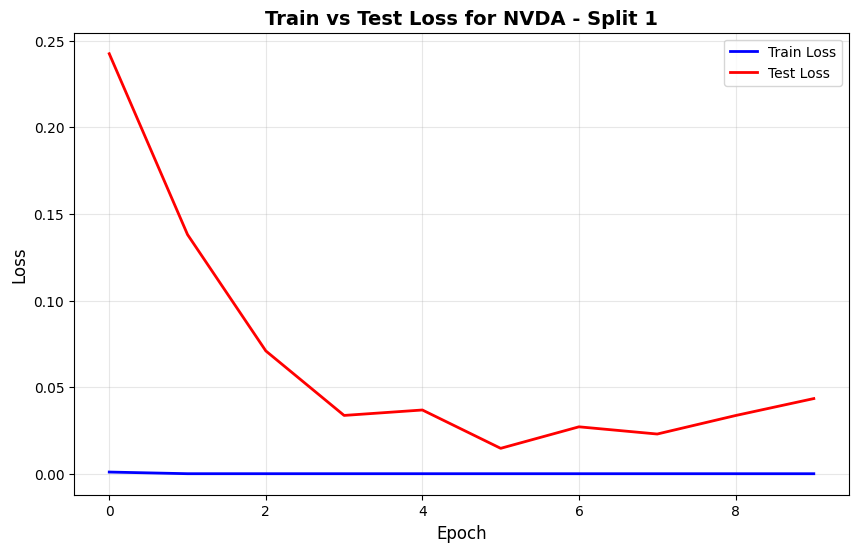

1905/1905 [==============================] - 7s 4ms/step


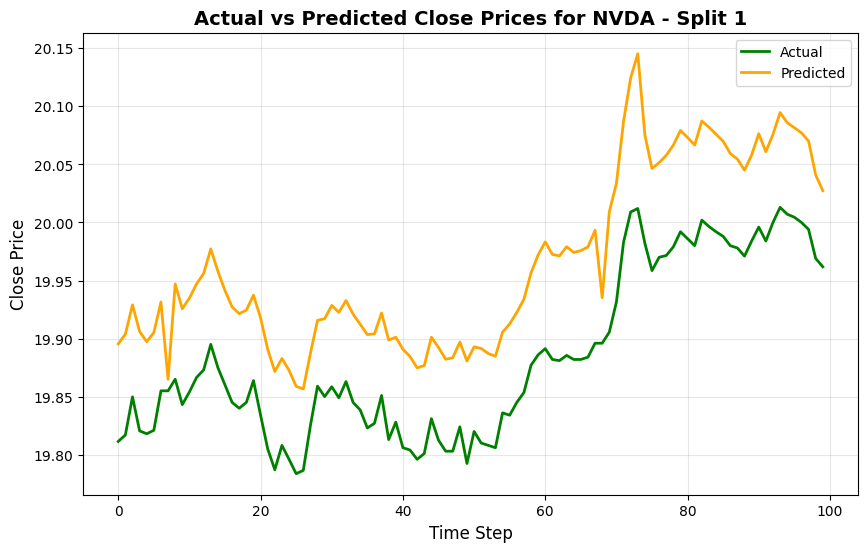

Epoch 1/10
3809/3809 [==============================] - 39s 10ms/step - loss: 0.0012 - val_loss: 4.0161e-05
Epoch 2/10
3809/3809 [==============================] - 38s 10ms/step - loss: 1.6415e-05 - val_loss: 6.8212e-06
Epoch 3/10
3809/3809 [==============================] - 36s 9ms/step - loss: 9.6582e-06 - val_loss: 9.9026e-06
Epoch 4/10
3809/3809 [==============================] - 38s 10ms/step - loss: 7.4142e-06 - val_loss: 2.6394e-05
Epoch 5/10
3809/3809 [==============================] - 37s 10ms/step - loss: 5.6981e-06 - val_loss: 2.9297e-06
Epoch 6/10
3809/3809 [==============================] - 34s 9ms/step - loss: 5.2968e-06 - val_loss: 3.4980e-06
Epoch 7/10
3809/3809 [==============================] - 33s 9ms/step - loss: 4.8374e-06 - val_loss: 3.8813e-06
Epoch 8/10
3809/3809 [==============================] - 36s 9ms/step - loss: 4.3259e-06 - val_loss: 3.0791e-06
Epoch 9/10
3809/3809 [==============================] - 37s 10ms/step - loss: 3.6754e-06 - val_loss: 2.5182e-06


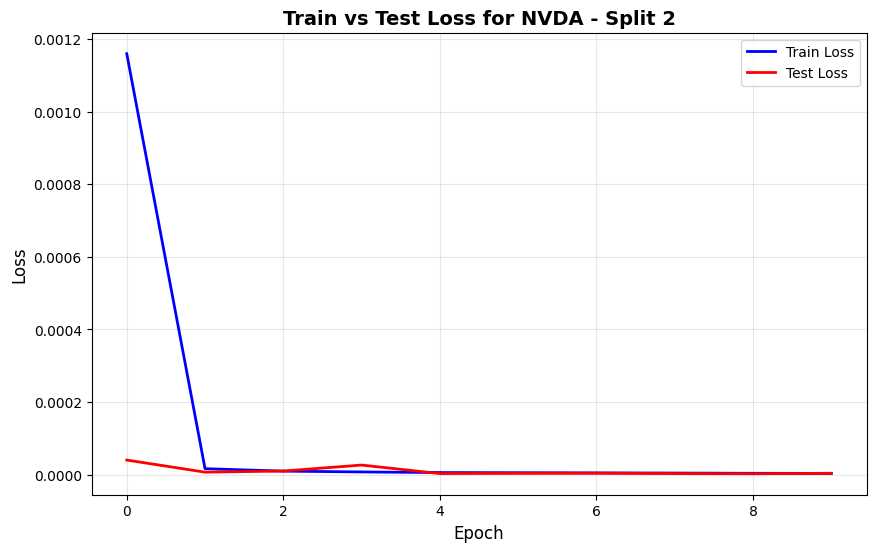

1905/1905 [==============================] - 6s 3ms/step


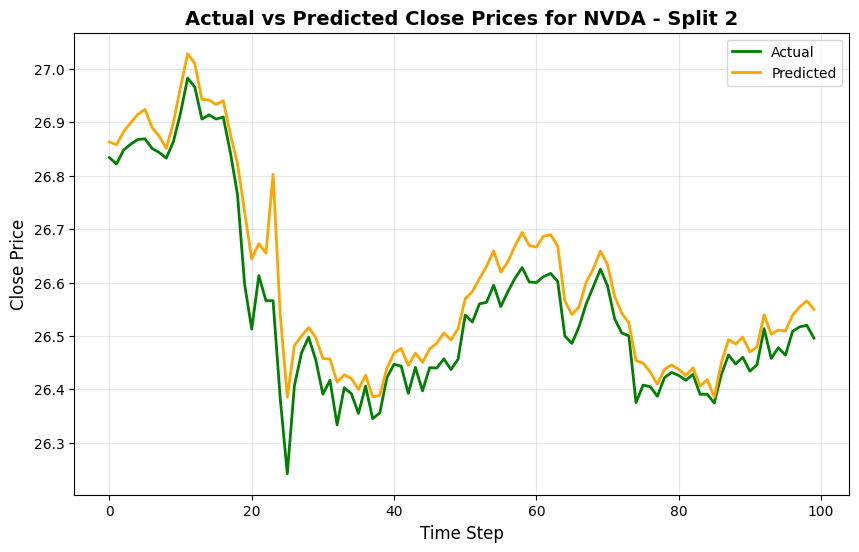

Epoch 1/10
5714/5714 [==============================] - 53s 9ms/step - loss: 3.3919e-04 - val_loss: 5.7055e-05
Epoch 2/10
5714/5714 [==============================] - 48s 8ms/step - loss: 9.8905e-06 - val_loss: 6.9977e-05
Epoch 3/10
5714/5714 [==============================] - 50s 9ms/step - loss: 6.7580e-06 - val_loss: 4.9037e-05
Epoch 4/10
5714/5714 [==============================] - 47s 8ms/step - loss: 4.6889e-06 - val_loss: 1.2159e-05
Epoch 5/10
5714/5714 [==============================] - 48s 8ms/step - loss: 4.4477e-06 - val_loss: 2.5908e-05
Epoch 6/10
5714/5714 [==============================] - 52s 9ms/step - loss: 3.5173e-06 - val_loss: 3.7853e-06
Epoch 7/10
5714/5714 [==============================] - 51s 9ms/step - loss: 3.1418e-06 - val_loss: 2.3373e-06
Epoch 8/10
5714/5714 [==============================] - 51s 9ms/step - loss: 3.0202e-06 - val_loss: 1.3016e-06
Epoch 9/10
5714/5714 [==============================] - 49s 9ms/step - loss: 2.5326e-06 - val_loss: 2.4667e-06
E

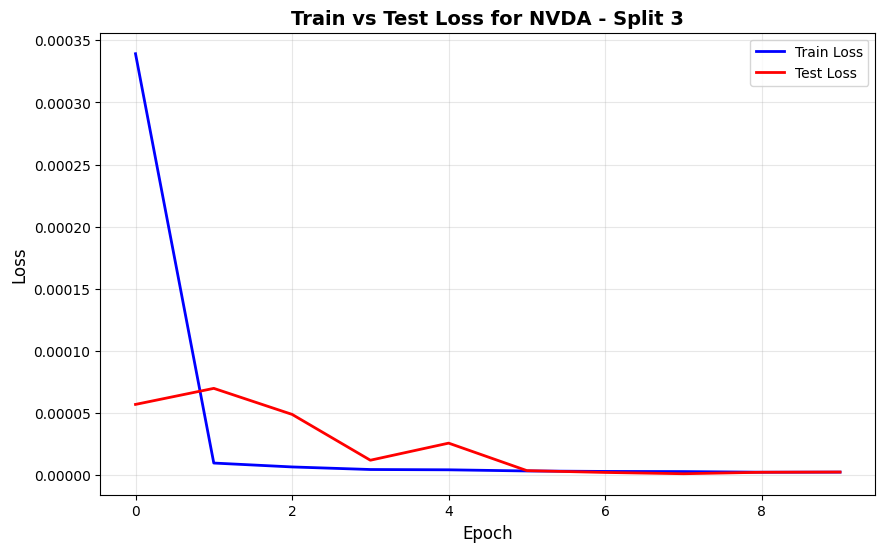

1905/1905 [==============================] - 7s 4ms/step


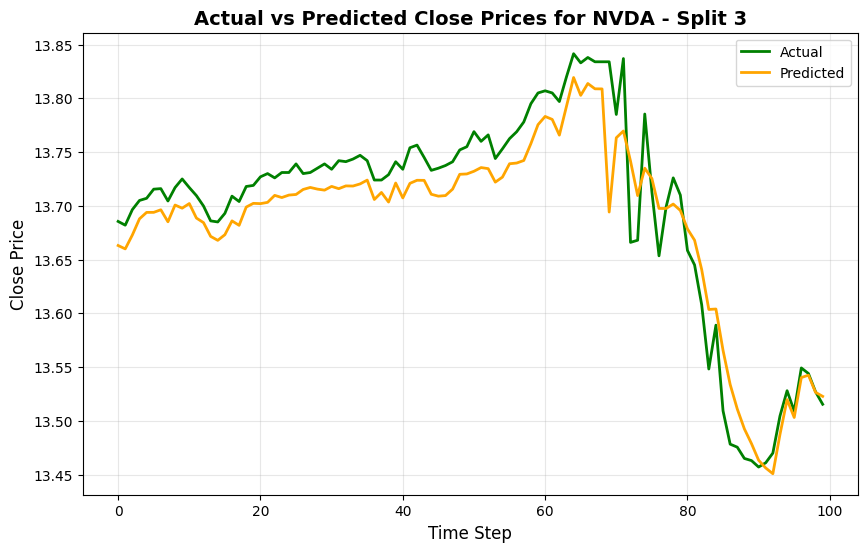

Epoch 1/10
7618/7618 [==============================] - 66s 8ms/step - loss: 4.3852e-04 - val_loss: 0.0035
Epoch 2/10
7618/7618 [==============================] - 67s 9ms/step - loss: 7.4352e-06 - val_loss: 6.2720e-04
Epoch 3/10
7618/7618 [==============================] - 69s 9ms/step - loss: 4.2551e-06 - val_loss: 3.3935e-04
Epoch 4/10
7618/7618 [==============================] - 70s 9ms/step - loss: 3.0164e-06 - val_loss: 2.1576e-04
Epoch 5/10
7618/7618 [==============================] - 65s 9ms/step - loss: 2.5818e-06 - val_loss: 1.2553e-04
Epoch 6/10
7618/7618 [==============================] - 67s 9ms/step - loss: 2.2725e-06 - val_loss: 1.6275e-05
Epoch 7/10
7618/7618 [==============================] - 64s 8ms/step - loss: 2.0420e-06 - val_loss: 9.9150e-05
Epoch 8/10
7618/7618 [==============================] - 60s 8ms/step - loss: 1.8547e-06 - val_loss: 1.8350e-05
Epoch 9/10
7618/7618 [==============================] - 64s 8ms/step - loss: 1.8435e-06 - val_loss: 1.8614e-05
Epoch

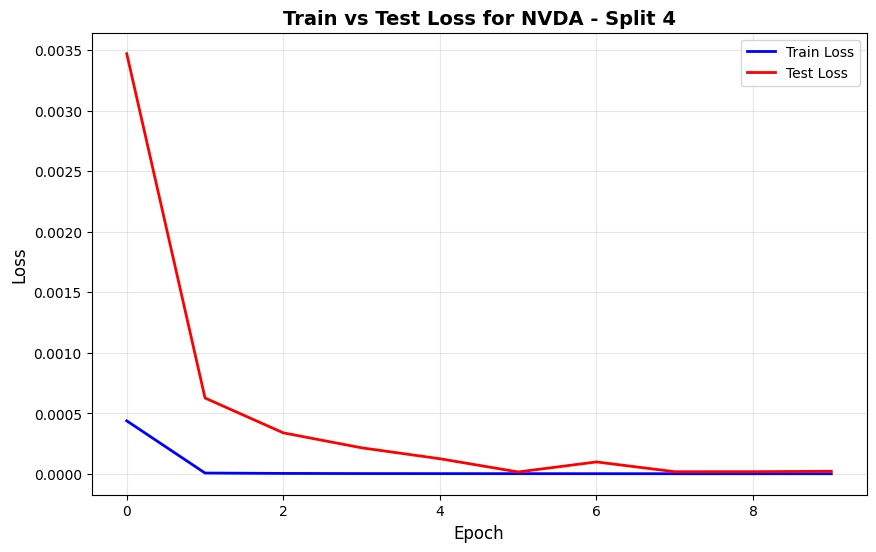

1905/1905 [==============================] - 7s 4ms/step


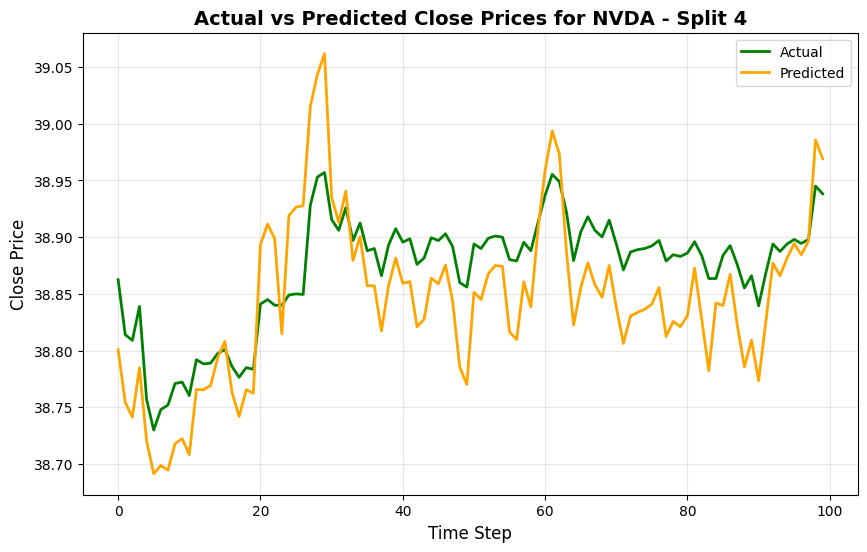

Epoch 1/10
9523/9523 [==============================] - 85s 9ms/step - loss: 1.5724e-04 - val_loss: 0.0065
Epoch 2/10
9523/9523 [==============================] - 80s 8ms/step - loss: 5.1857e-06 - val_loss: 0.1437
Epoch 3/10
9523/9523 [==============================] - 70s 7ms/step - loss: 3.3640e-06 - val_loss: 1.7783
Epoch 4/10
9523/9523 [==============================] - 78s 8ms/step - loss: 2.9464e-06 - val_loss: 2.3394
Epoch 5/10
9523/9523 [==============================] - 79s 8ms/step - loss: 2.1243e-06 - val_loss: 1.3514
Epoch 6/10
9523/9523 [==============================] - 78s 8ms/step - loss: 2.0142e-06 - val_loss: 0.5066
Epoch 7/10
9523/9523 [==============================] - 72s 8ms/step - loss: 1.6507e-06 - val_loss: 0.2293
Epoch 8/10
9523/9523 [==============================] - 77s 8ms/step - loss: 1.4887e-06 - val_loss: 0.1477
Epoch 9/10
9523/9523 [==============================] - 79s 8ms/step - loss: 1.4088e-06 - val_loss: 0.0345
Epoch 10/10
9523/9523 [==============

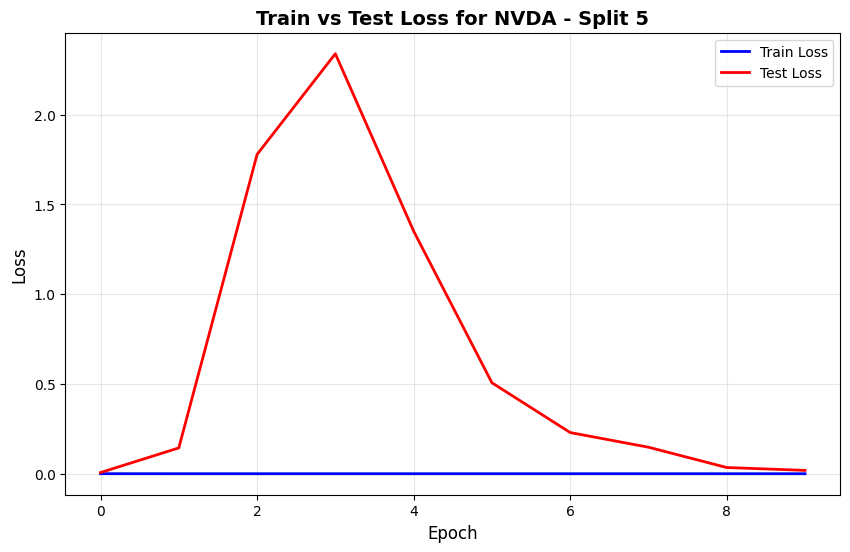

1905/1905 [==============================] - 7s 3ms/step


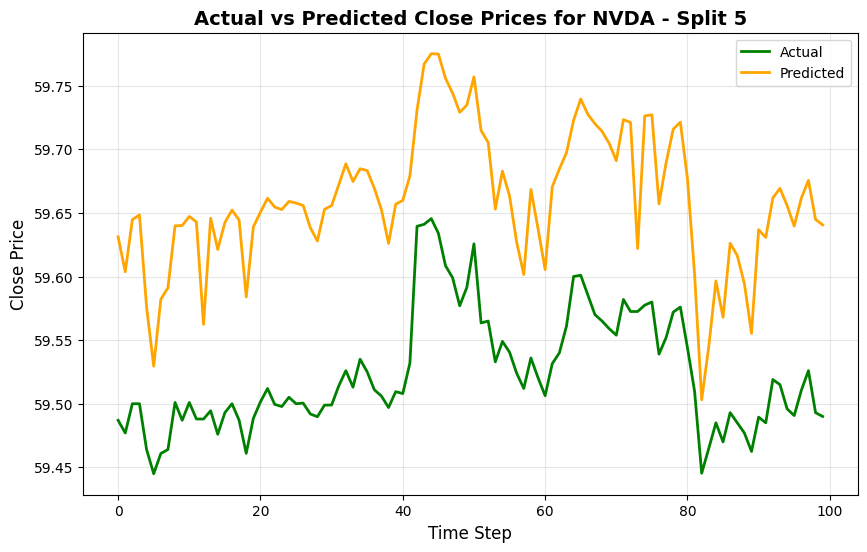

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: NVDA. Model, scalers, and graphs saved.
Epoch 1/10
1901/1901 [==============================] - 23s 11ms/step - loss: 0.0015 - val_loss: 7.4043e-05
Epoch 2/10
1901/1901 [==============================] - 21s 11ms/step - loss: 1.4762e-05 - val_loss: 6.0961e-05
Epoch 3/10
1901/1901 [==============================] - 21s 11ms/step - loss: 1.4308e-05 - val_loss: 3.3794e-05
Epoch 4/10
1901/1901 [==============================] - 21s 11ms/step - loss: 1.3534e-05 - val_loss: 5.4382e-05
Epoch 5/10
1901/1901 [==============================] - 22s 11ms/step - loss: 1.2366e-05 - val_loss: 2.2428e-05
Epoch 6/10
1901/1901 [==============================] - 20s 10ms/step - loss: 1.1189e-05 - val_loss: 1.6289e-05
Epoch 7/10
1901/1901 [==============================] - 21s 11ms/step - loss: 1.0126e-05 - val_loss: 2.0637e-05
Epoch 8/10
1901/1901 [==============================] - 21s 11ms/step - loss: 8.5872e-06 - val_loss: 2.2495e-05
Epoch 9/10
1901/1901 [=========================

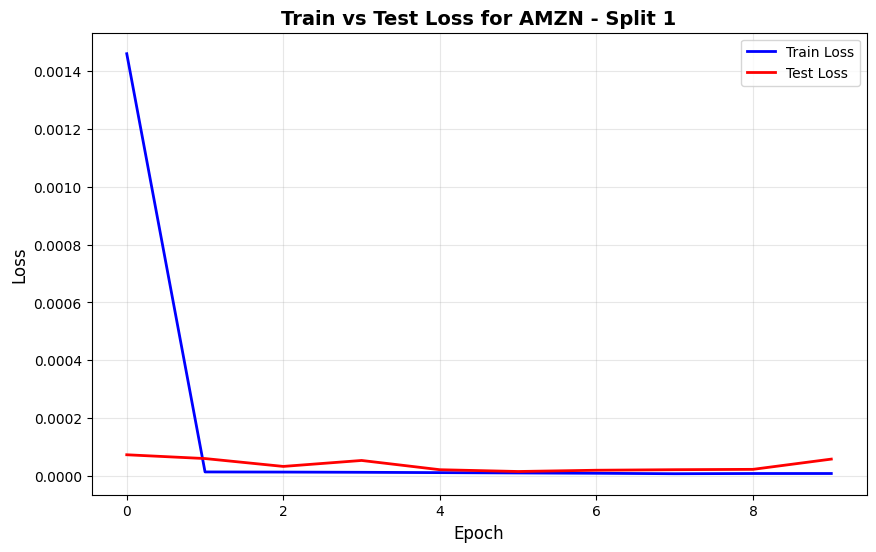

1901/1901 [==============================] - 7s 4ms/step


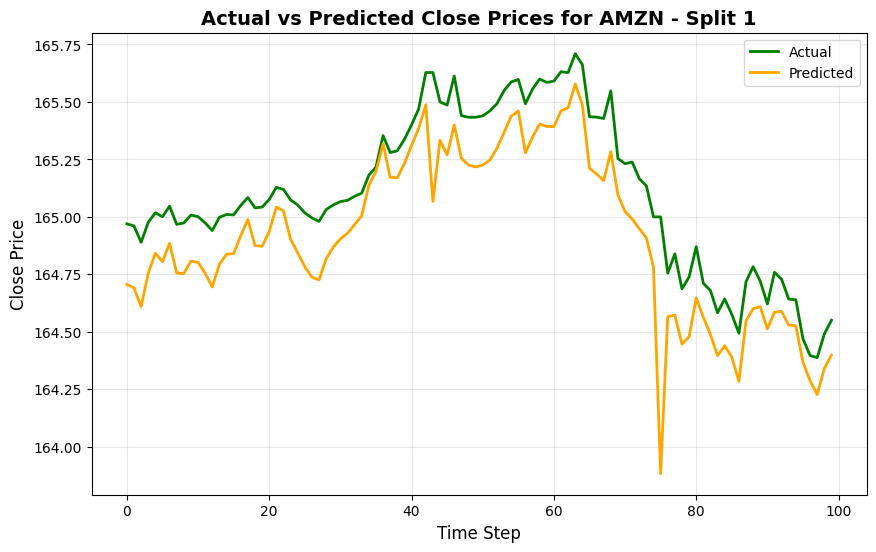

Epoch 1/10
3801/3801 [==============================] - 36s 9ms/step - loss: 5.6867e-04 - val_loss: 3.8657
Epoch 2/10
3801/3801 [==============================] - 38s 10ms/step - loss: 1.2000e-05 - val_loss: 1.2497
Epoch 3/10
3801/3801 [==============================] - 34s 9ms/step - loss: 1.1066e-05 - val_loss: 0.7929
Epoch 4/10
3801/3801 [==============================] - 38s 10ms/step - loss: 9.1454e-06 - val_loss: 0.6807
Epoch 5/10
3801/3801 [==============================] - 34s 9ms/step - loss: 8.3347e-06 - val_loss: 0.6449
Epoch 6/10
3801/3801 [==============================] - 35s 9ms/step - loss: 7.3286e-06 - val_loss: 0.5137
Epoch 7/10
3801/3801 [==============================] - 38s 10ms/step - loss: 6.7838e-06 - val_loss: 0.6702
Epoch 8/10
3801/3801 [==============================] - 36s 9ms/step - loss: 5.9790e-06 - val_loss: 0.4500
Epoch 9/10
3801/3801 [==============================] - 35s 9ms/step - loss: 5.8159e-06 - val_loss: 0.6228
Epoch 10/10
3801/3801 [===========

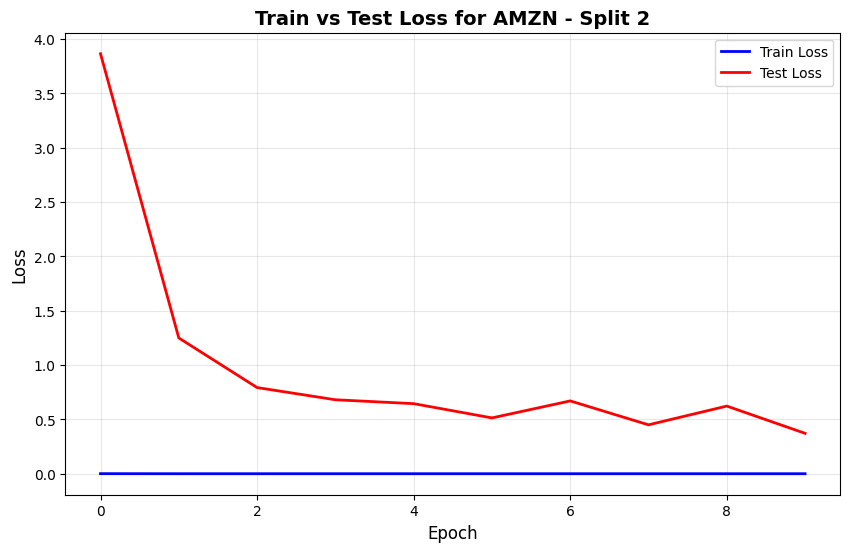

1901/1901 [==============================] - 6s 3ms/step


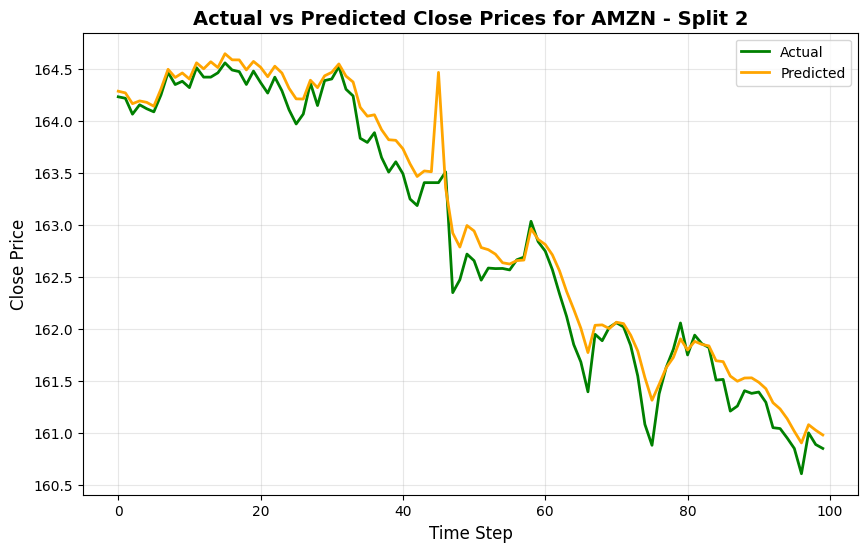

Epoch 1/10
5701/5701 [==============================] - 51s 9ms/step - loss: 9.5341e-04 - val_loss: 0.0021
Epoch 2/10
5701/5701 [==============================] - 53s 9ms/step - loss: 1.0093e-05 - val_loss: 0.0033
Epoch 3/10
5701/5701 [==============================] - 53s 9ms/step - loss: 7.2905e-06 - val_loss: 0.0033
Epoch 4/10
5701/5701 [==============================] - 53s 9ms/step - loss: 5.5907e-06 - val_loss: 0.0024
Epoch 5/10
5701/5701 [==============================] - 52s 9ms/step - loss: 4.9353e-06 - val_loss: 0.0018
Epoch 6/10
5701/5701 [==============================] - 53s 9ms/step - loss: 4.3784e-06 - val_loss: 9.6254e-04
Epoch 7/10
5701/5701 [==============================] - 54s 9ms/step - loss: 4.2830e-06 - val_loss: 5.8230e-04
Epoch 8/10
5701/5701 [==============================] - 52s 9ms/step - loss: 3.6199e-06 - val_loss: 2.1740e-04
Epoch 9/10
5701/5701 [==============================] - 50s 9ms/step - loss: 3.5553e-06 - val_loss: 2.3882e-04
Epoch 10/10
5701/5701

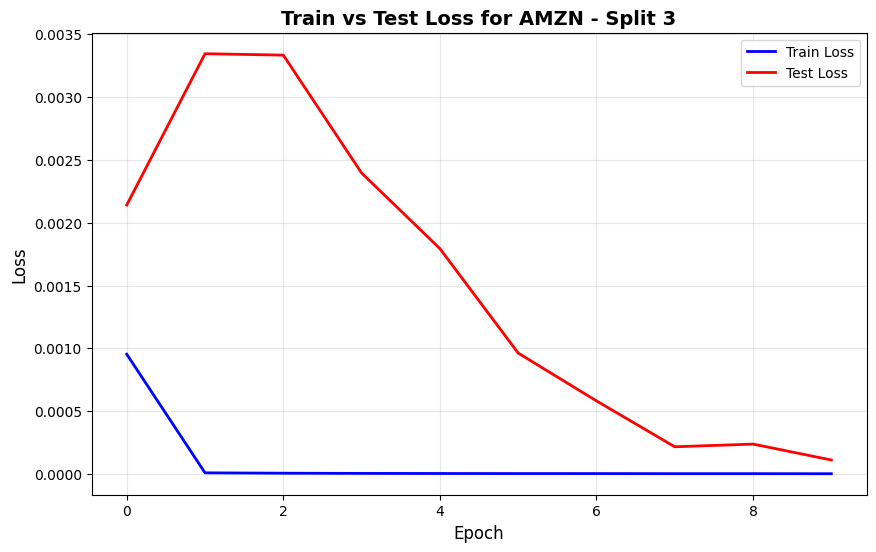

1901/1901 [==============================] - 7s 4ms/step


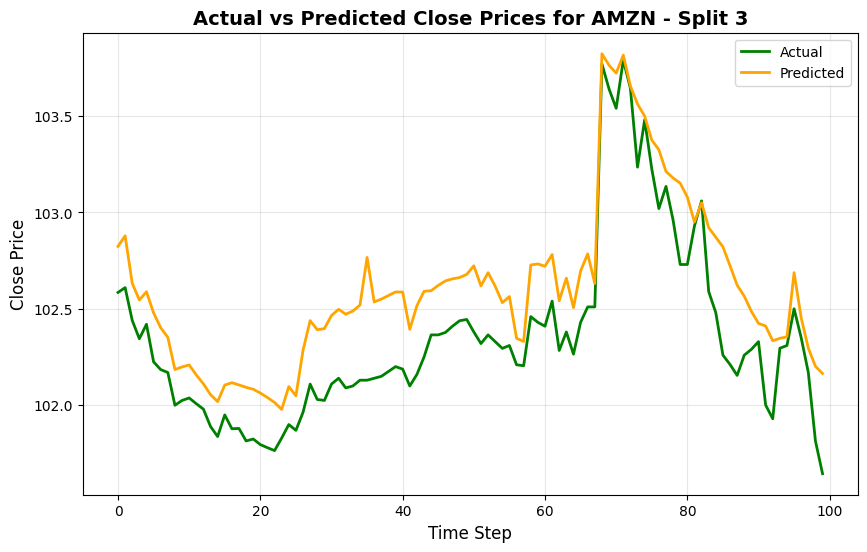

Epoch 1/10
7601/7601 [==============================] - 61s 8ms/step - loss: 5.3517e-04 - val_loss: 1.2085e-05
Epoch 2/10
7601/7601 [==============================] - 59s 8ms/step - loss: 8.6057e-06 - val_loss: 1.7712e-06
Epoch 3/10
7601/7601 [==============================] - 60s 8ms/step - loss: 6.1330e-06 - val_loss: 3.3445e-06
Epoch 4/10
7601/7601 [==============================] - 56s 7ms/step - loss: 4.6448e-06 - val_loss: 2.2608e-06
Epoch 5/10
7601/7601 [==============================] - 59s 8ms/step - loss: 3.7777e-06 - val_loss: 1.0288e-06
Epoch 6/10
7601/7601 [==============================] - 59s 8ms/step - loss: 3.3129e-06 - val_loss: 2.8725e-06
Epoch 7/10
7601/7601 [==============================] - 60s 8ms/step - loss: 2.8612e-06 - val_loss: 2.8725e-06
Epoch 8/10
7601/7601 [==============================] - 59s 8ms/step - loss: 2.6738e-06 - val_loss: 1.5631e-06
Epoch 9/10
7601/7601 [==============================] - 54s 7ms/step - loss: 2.4767e-06 - val_loss: 9.9473e-07
E

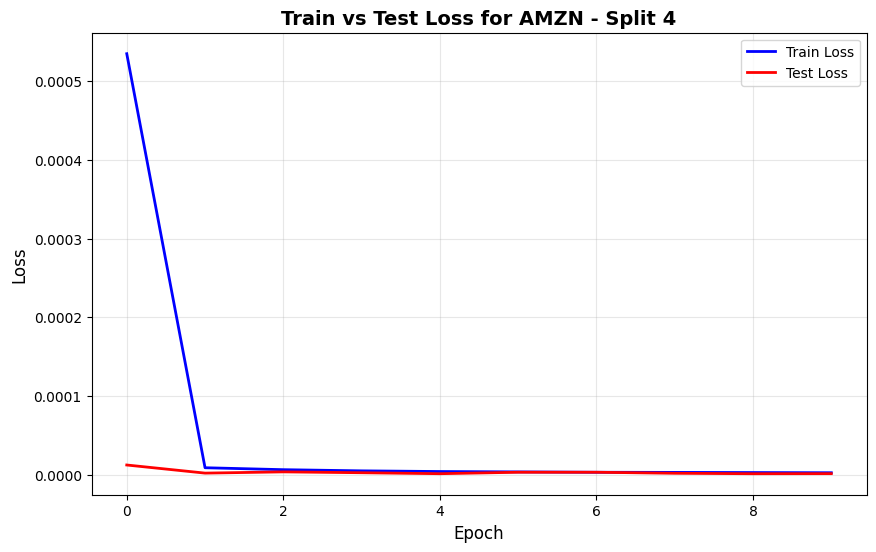

1901/1901 [==============================] - 7s 3ms/step


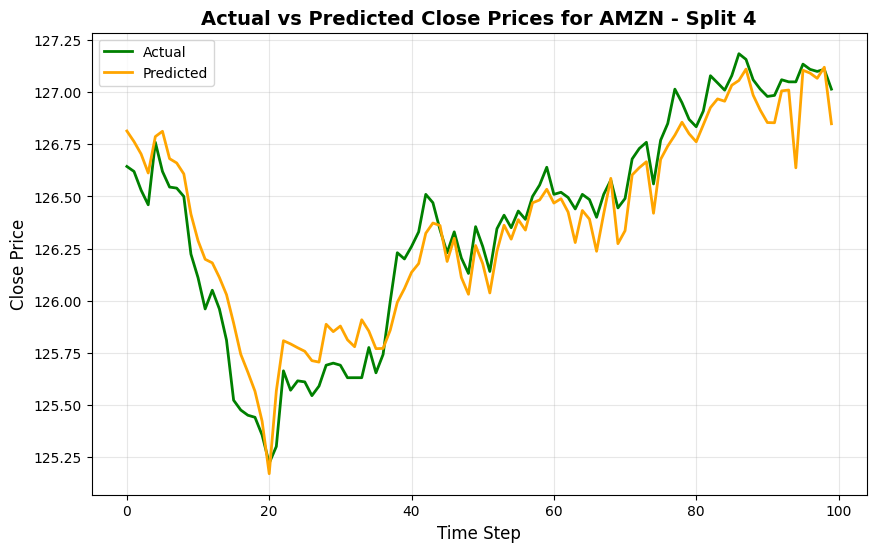

Epoch 1/10
9502/9502 [==============================] - 86s 9ms/step - loss: 4.3706e-04 - val_loss: 2.6495e-05
Epoch 2/10
9502/9502 [==============================] - 83s 9ms/step - loss: 6.4847e-06 - val_loss: 2.3859e-06
Epoch 3/10
9502/9502 [==============================] - 81s 9ms/step - loss: 4.4142e-06 - val_loss: 3.8038e-04
Epoch 4/10
9502/9502 [==============================] - 82s 9ms/step - loss: 3.3173e-06 - val_loss: 3.0588e-06
Epoch 5/10
9502/9502 [==============================] - 77s 8ms/step - loss: 2.7235e-06 - val_loss: 7.5392e-06
Epoch 6/10
9502/9502 [==============================] - 81s 9ms/step - loss: 2.3813e-06 - val_loss: 3.6100e-06
Epoch 7/10
9502/9502 [==============================] - 81s 9ms/step - loss: 2.1316e-06 - val_loss: 4.0163e-06
Epoch 8/10
9502/9502 [==============================] - 80s 8ms/step - loss: 1.9777e-06 - val_loss: 5.4289e-06
Epoch 9/10
9502/9502 [==============================] - 78s 8ms/step - loss: 1.7876e-06 - val_loss: 1.8654e-06
E

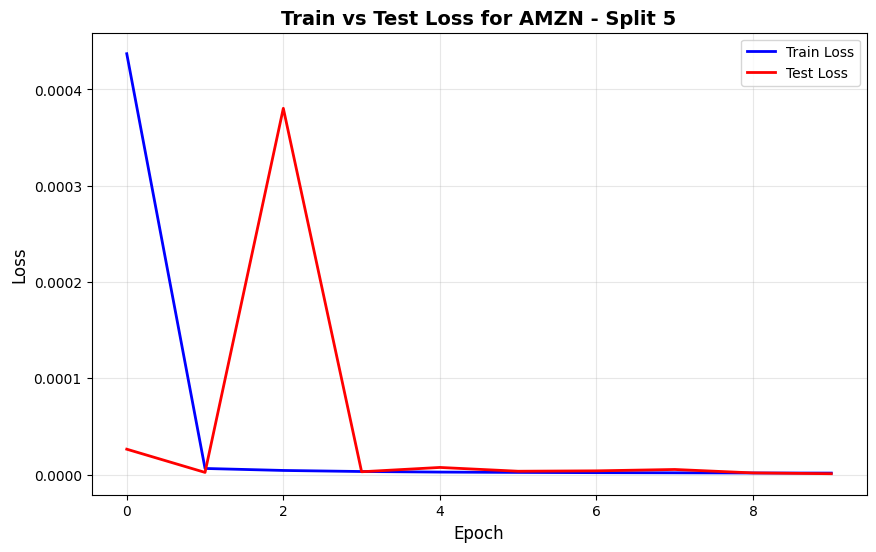

1901/1901 [==============================] - 7s 3ms/step


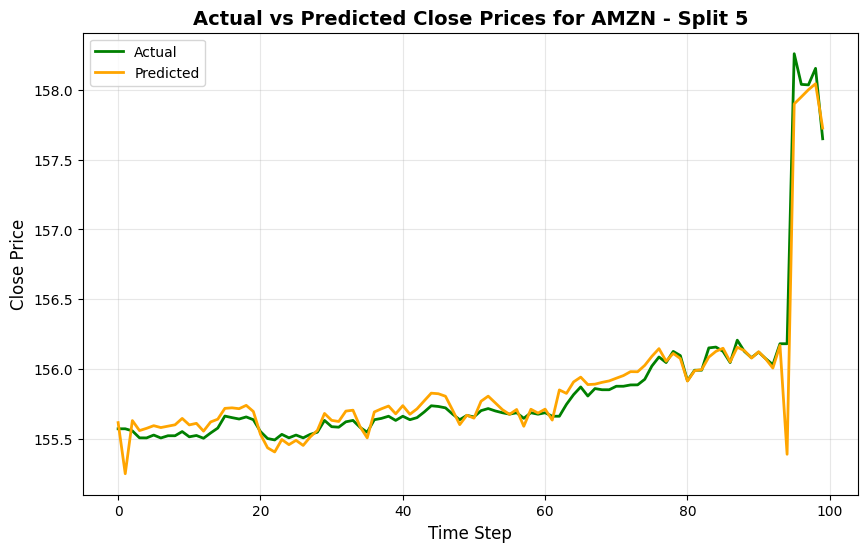

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: AMZN. Model, scalers, and graphs saved.
Epoch 1/10
1859/1859 [==============================] - 22s 11ms/step - loss: 0.0020 - val_loss: 1.9234e-04
Epoch 2/10
1859/1859 [==============================] - 22s 12ms/step - loss: 3.8950e-05 - val_loss: 2.3243e-04
Epoch 3/10
1859/1859 [==============================] - 21s 11ms/step - loss: 1.4661e-05 - val_loss: 1.0633e-04
Epoch 4/10
1859/1859 [==============================] - 20s 11ms/step - loss: 1.2947e-05 - val_loss: 1.0101e-04
Epoch 5/10
1859/1859 [==============================] - 19s 10ms/step - loss: 1.3592e-05 - val_loss: 3.1176e-05
Epoch 6/10
1859/1859 [==============================] - 18s 10ms/step - loss: 1.0943e-05 - val_loss: 1.5085e-05
Epoch 7/10
1859/1859 [==============================] - 20s 11ms/step - loss: 1.0741e-05 - val_loss: 7.9475e-06
Epoch 8/10
1859/1859 [==============================] - 19s 10ms/step - loss: 1.0192e-05 - val_loss: 2.3868e-05
Epoch 9/10
1859/1859 [=========================

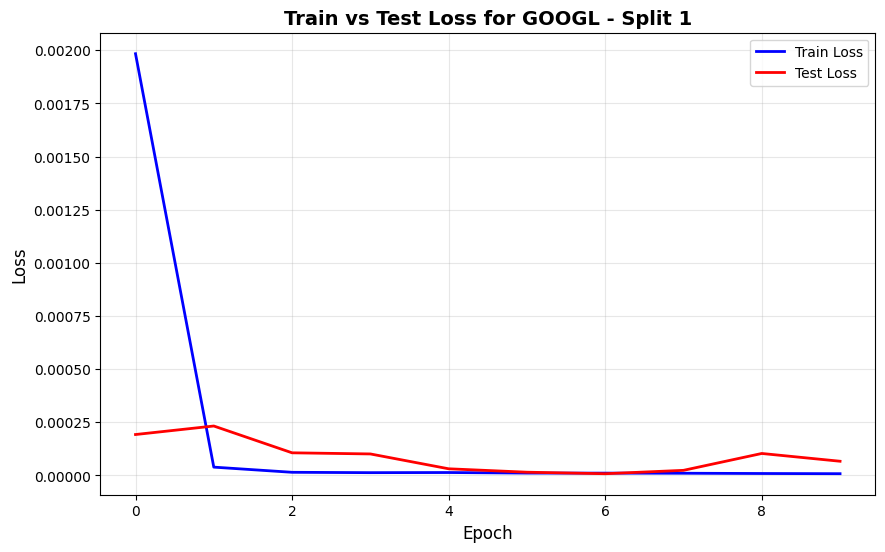

1859/1859 [==============================] - 6s 3ms/step


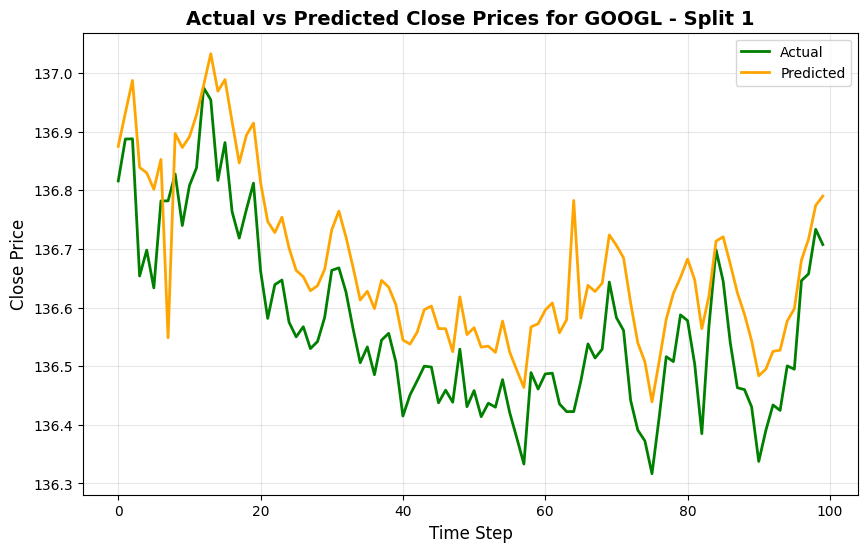

Epoch 1/10
3717/3717 [==============================] - 36s 9ms/step - loss: 0.0015 - val_loss: 1.1827e-05
Epoch 2/10
3717/3717 [==============================] - 32s 9ms/step - loss: 1.2760e-05 - val_loss: 6.6447e-06
Epoch 3/10
3717/3717 [==============================] - 36s 10ms/step - loss: 1.0977e-05 - val_loss: 3.7759e-06
Epoch 4/10
3717/3717 [==============================] - 36s 10ms/step - loss: 8.2628e-06 - val_loss: 3.5616e-06
Epoch 5/10
3717/3717 [==============================] - 37s 10ms/step - loss: 7.3454e-06 - val_loss: 6.8093e-06
Epoch 6/10
3717/3717 [==============================] - 36s 10ms/step - loss: 6.1050e-06 - val_loss: 4.1304e-06
Epoch 7/10
3717/3717 [==============================] - 32s 9ms/step - loss: 5.7167e-06 - val_loss: 2.4920e-06
Epoch 8/10
3717/3717 [==============================] - 34s 9ms/step - loss: 5.1316e-06 - val_loss: 5.7403e-06
Epoch 9/10
3717/3717 [==============================] - 32s 9ms/step - loss: 4.8094e-06 - val_loss: 2.0557e-06
E

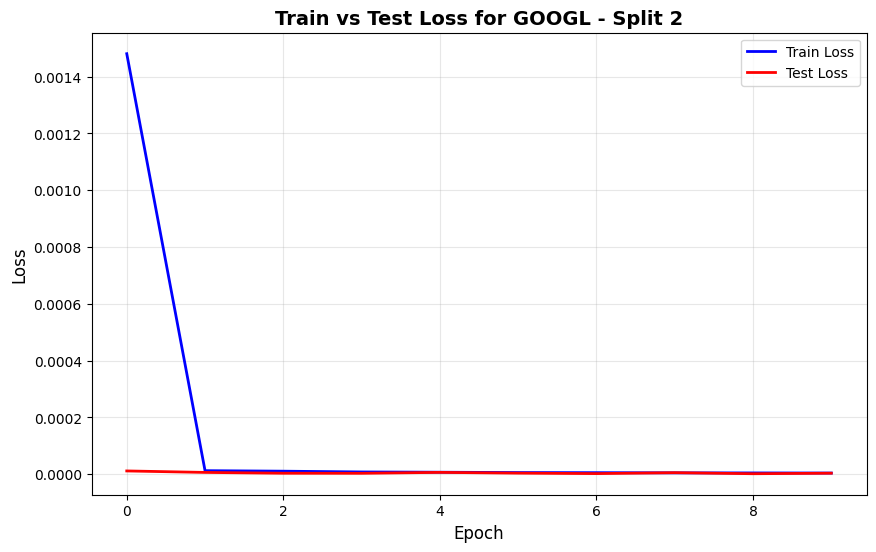

1859/1859 [==============================] - 6s 3ms/step


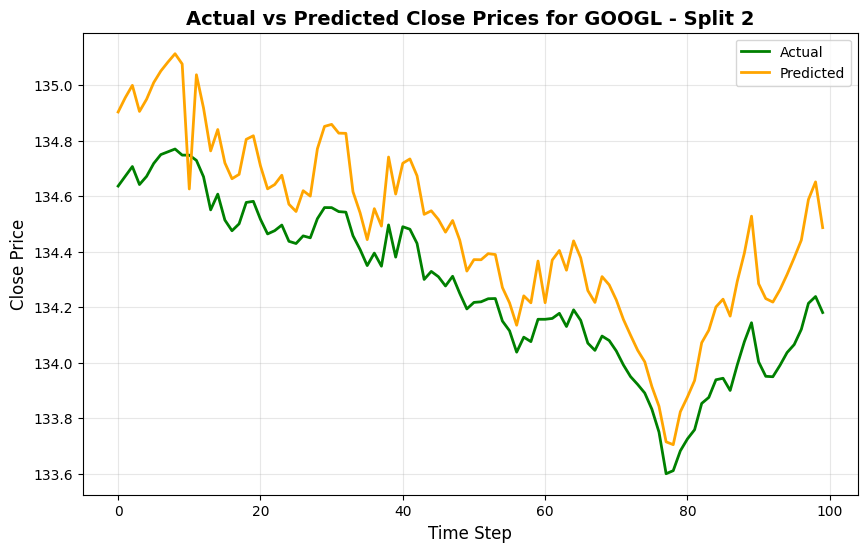

Epoch 1/10
5575/5575 [==============================] - 45s 8ms/step - loss: 7.6304e-04 - val_loss: 5.8819e-06
Epoch 2/10
5575/5575 [==============================] - 45s 8ms/step - loss: 9.8609e-06 - val_loss: 1.6331e-05
Epoch 3/10
5575/5575 [==============================] - 51s 9ms/step - loss: 8.2886e-06 - val_loss: 3.1192e-06
Epoch 4/10
5575/5575 [==============================] - 50s 9ms/step - loss: 6.4058e-06 - val_loss: 3.3593e-06
Epoch 5/10
5575/5575 [==============================] - 50s 9ms/step - loss: 5.3182e-06 - val_loss: 9.2291e-06
Epoch 6/10
5575/5575 [==============================] - 48s 9ms/step - loss: 4.7656e-06 - val_loss: 3.4223e-06
Epoch 7/10
5575/5575 [==============================] - 52s 9ms/step - loss: 4.4941e-06 - val_loss: 1.5213e-06
Epoch 8/10
5575/5575 [==============================] - 50s 9ms/step - loss: 3.7839e-06 - val_loss: 2.5380e-06
Epoch 9/10
5575/5575 [==============================] - 49s 9ms/step - loss: 3.6613e-06 - val_loss: 2.2625e-06
E

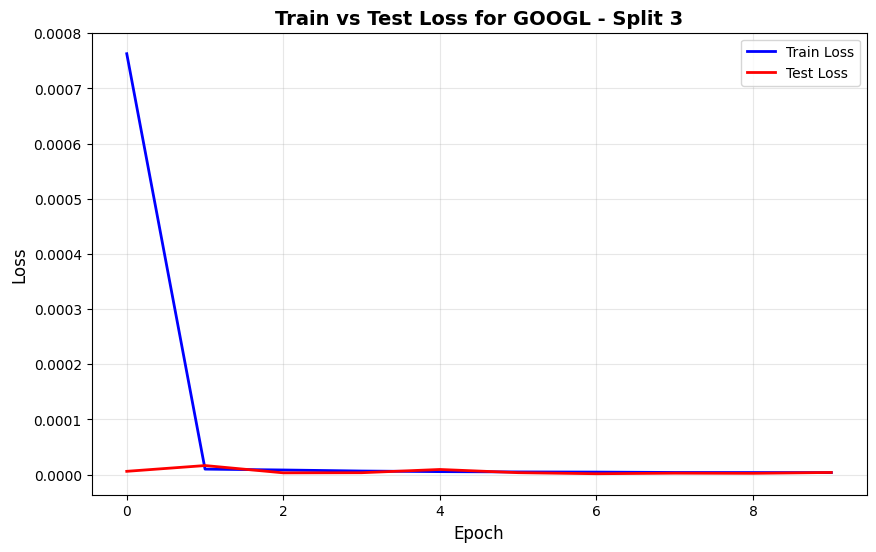

1859/1859 [==============================] - 7s 4ms/step


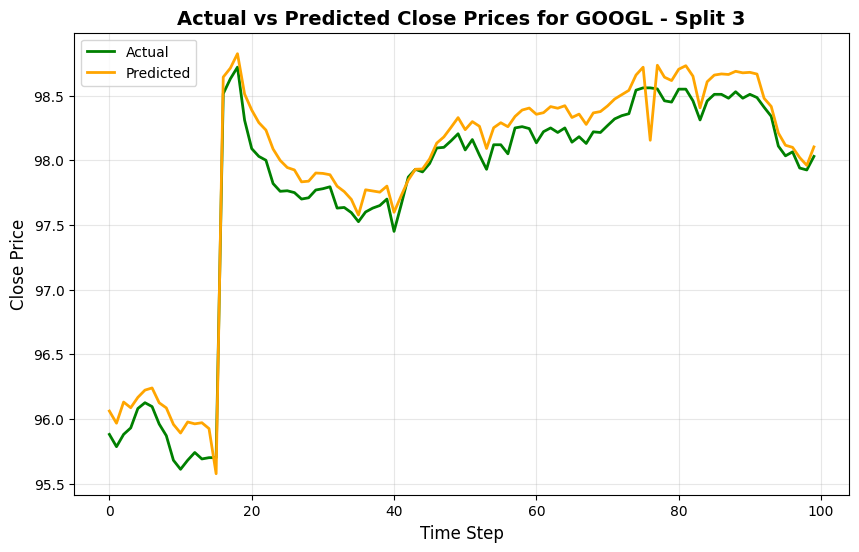

Epoch 1/10
7433/7433 [==============================] - 68s 9ms/step - loss: 3.5500e-04 - val_loss: 2.5690e-06
Epoch 2/10
7433/7433 [==============================] - 66s 9ms/step - loss: 9.9440e-06 - val_loss: 6.0436e-06
Epoch 3/10
7433/7433 [==============================] - 67s 9ms/step - loss: 6.2016e-06 - val_loss: 3.0677e-06
Epoch 4/10
7433/7433 [==============================] - 66s 9ms/step - loss: 5.2560e-06 - val_loss: 4.4771e-06
Epoch 5/10
7433/7433 [==============================] - 67s 9ms/step - loss: 4.2820e-06 - val_loss: 7.1836e-07
Epoch 6/10
7433/7433 [==============================] - 59s 8ms/step - loss: 3.6716e-06 - val_loss: 1.9233e-06
Epoch 7/10
7433/7433 [==============================] - 57s 8ms/step - loss: 3.3141e-06 - val_loss: 7.2605e-07
Epoch 8/10
7433/7433 [==============================] - 65s 9ms/step - loss: 3.0506e-06 - val_loss: 2.0264e-06
Epoch 9/10
7433/7433 [==============================] - 66s 9ms/step - loss: 2.9401e-06 - val_loss: 5.0036e-06
E

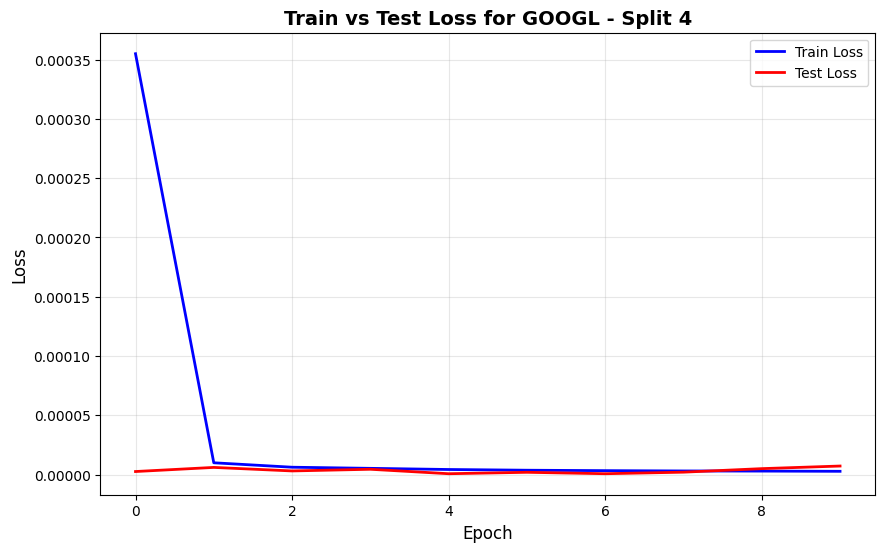

1859/1859 [==============================] - 6s 3ms/step


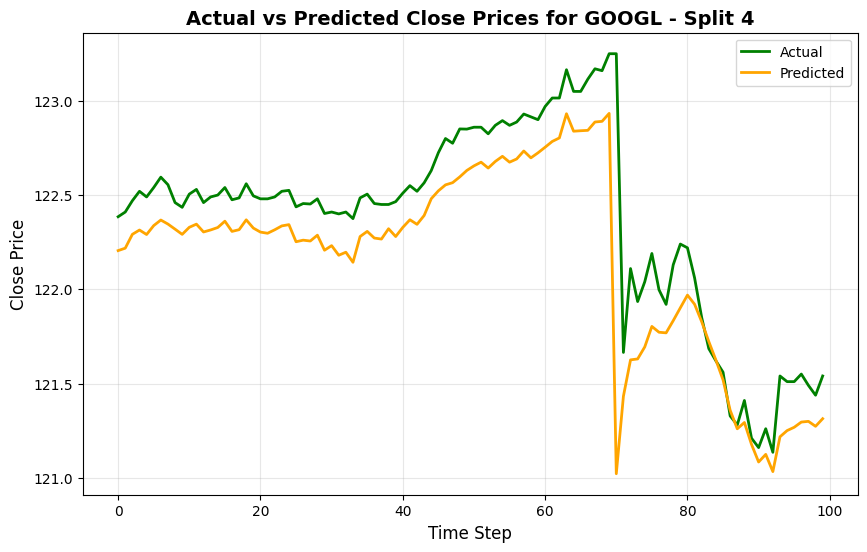

Epoch 1/10
9292/9292 [==============================] - 82s 9ms/step - loss: 4.8325e-04 - val_loss: 2.8030e-04
Epoch 2/10
9292/9292 [==============================] - 78s 8ms/step - loss: 7.1883e-06 - val_loss: 8.8455e-05
Epoch 3/10
9292/9292 [==============================] - 79s 9ms/step - loss: 5.3804e-06 - val_loss: 0.0011
Epoch 4/10
9292/9292 [==============================] - 75s 8ms/step - loss: 3.8788e-06 - val_loss: 0.0010
Epoch 5/10
9292/9292 [==============================] - 81s 9ms/step - loss: 3.1602e-06 - val_loss: 4.0396e-04
Epoch 6/10
9292/9292 [==============================] - 77s 8ms/step - loss: 2.7749e-06 - val_loss: 4.1589e-04
Epoch 7/10
9292/9292 [==============================] - 81s 9ms/step - loss: 2.5132e-06 - val_loss: 2.9513e-04
Epoch 8/10
9292/9292 [==============================] - 82s 9ms/step - loss: 2.2439e-06 - val_loss: 1.7305e-04
Epoch 9/10
9292/9292 [==============================] - 76s 8ms/step - loss: 2.0345e-06 - val_loss: 1.6702e-05
Epoch 10/

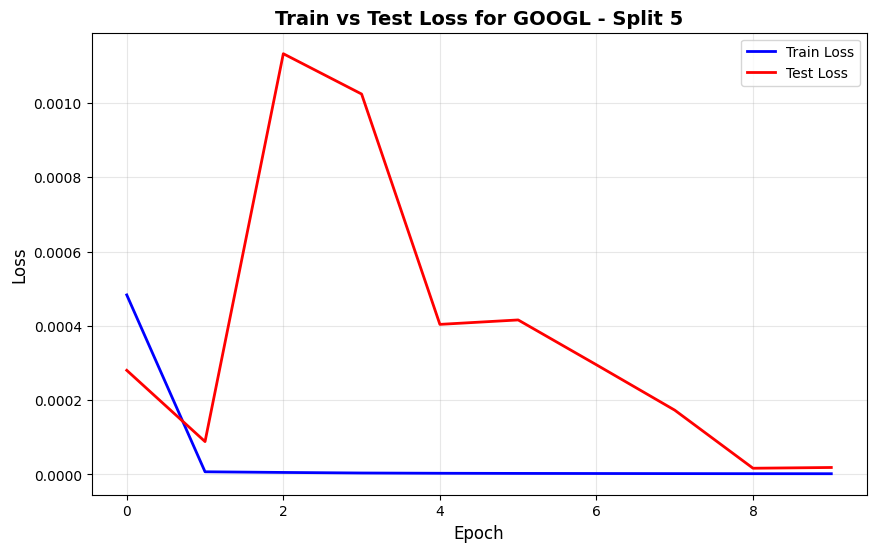

1859/1859 [==============================] - 7s 4ms/step


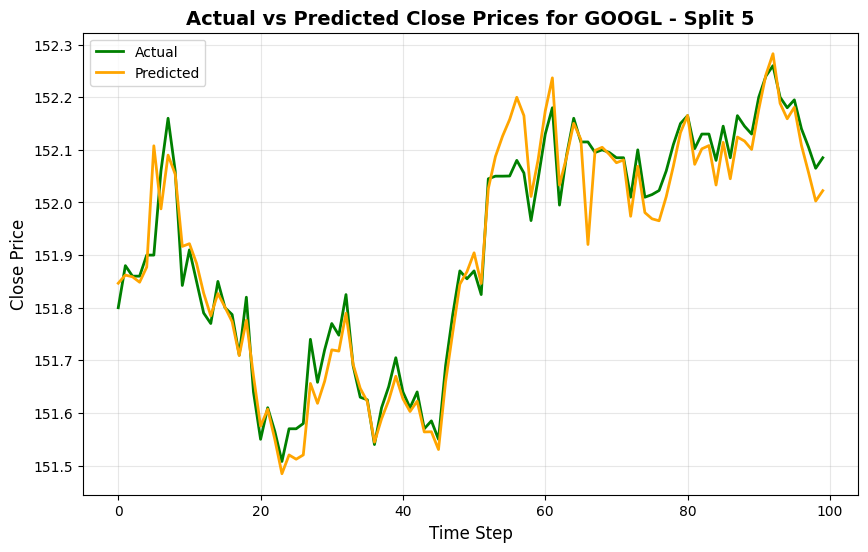

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: GOOGL. Model, scalers, and graphs saved.
Epoch 1/10
1898/1898 [==============================] - 22s 11ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 2/10
1898/1898 [==============================] - 21s 11ms/step - loss: 1.7031e-05 - val_loss: 0.0020
Epoch 3/10
1898/1898 [==============================] - 21s 11ms/step - loss: 1.3814e-05 - val_loss: 8.1905e-04
Epoch 4/10
1898/1898 [==============================] - 22s 12ms/step - loss: 1.8146e-05 - val_loss: 4.3676e-04
Epoch 5/10
1898/1898 [==============================] - 20s 10ms/step - loss: 1.1007e-05 - val_loss: 4.6206e-04
Epoch 6/10
1898/1898 [==============================] - 20s 11ms/step - loss: 9.7073e-06 - val_loss: 9.4769e-04
Epoch 7/10
1898/1898 [==============================] - 22s 11ms/step - loss: 8.0516e-06 - val_loss: 2.0888e-04
Epoch 8/10
1898/1898 [==============================] - 20s 10ms/step - loss: 8.8713e-06 - val_loss: 1.3130e-04
Epoch 9/10
1898/1898 [==============================] 

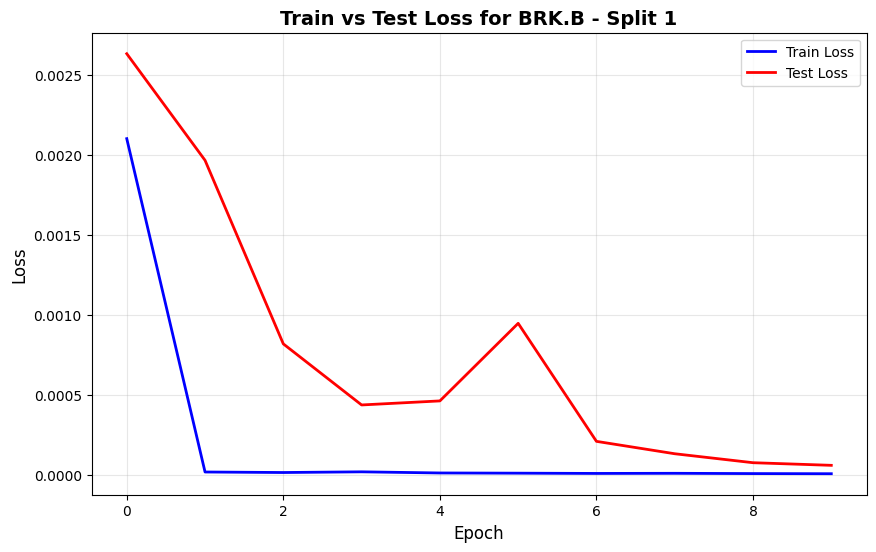

1898/1898 [==============================] - 7s 3ms/step


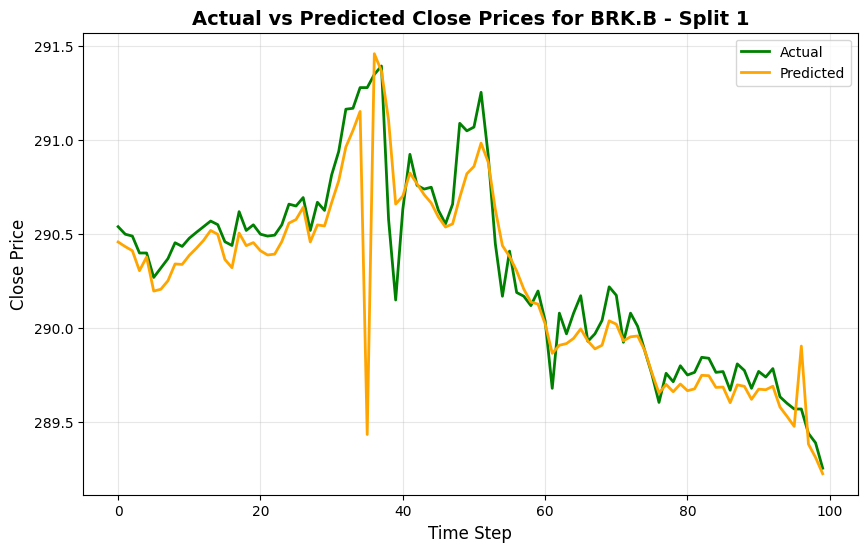

Epoch 1/10
3795/3795 [==============================] - 37s 10ms/step - loss: 9.9563e-04 - val_loss: 6.0633e-06
Epoch 2/10
3795/3795 [==============================] - 37s 10ms/step - loss: 6.8342e-06 - val_loss: 8.9466e-06
Epoch 3/10
3795/3795 [==============================] - 36s 10ms/step - loss: 5.7818e-06 - val_loss: 6.2487e-06
Epoch 4/10
3795/3795 [==============================] - 35s 9ms/step - loss: 5.3632e-06 - val_loss: 7.0735e-06
Epoch 5/10
3795/3795 [==============================] - 35s 9ms/step - loss: 4.4180e-06 - val_loss: 3.2455e-06
Epoch 6/10
3795/3795 [==============================] - 36s 9ms/step - loss: 4.0434e-06 - val_loss: 2.1964e-06
Epoch 7/10
3795/3795 [==============================] - 37s 10ms/step - loss: 3.4910e-06 - val_loss: 2.5132e-06
Epoch 8/10
3795/3795 [==============================] - 36s 10ms/step - loss: 3.5606e-06 - val_loss: 4.4740e-05
Epoch 9/10
3795/3795 [==============================] - 35s 9ms/step - loss: 3.3872e-06 - val_loss: 1.8927e

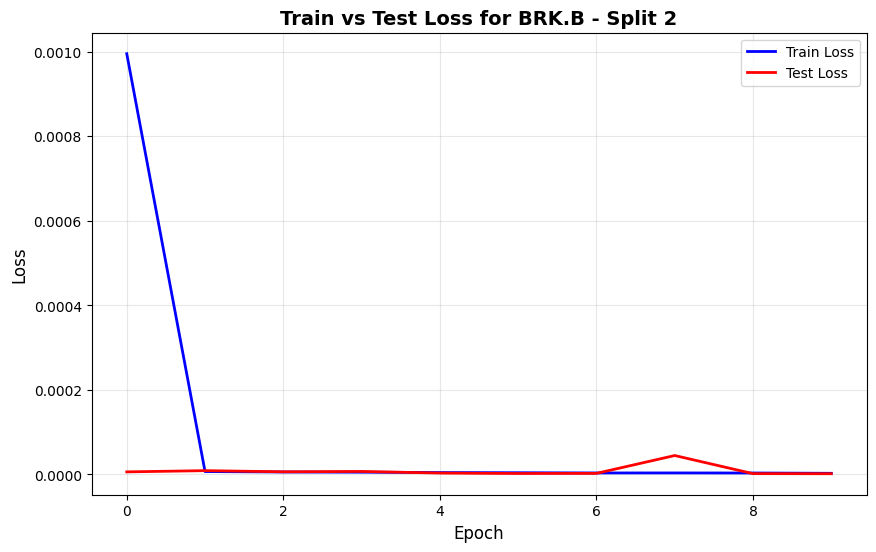

1898/1898 [==============================] - 6s 3ms/step


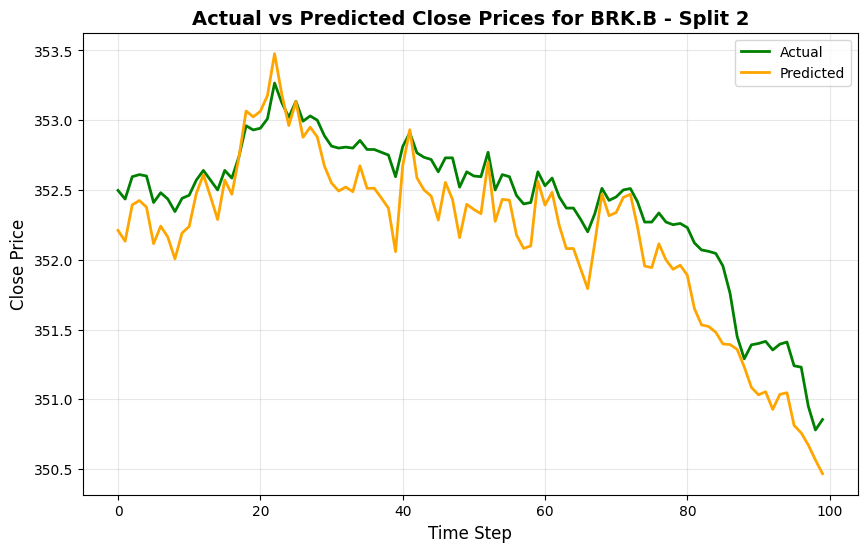

Epoch 1/10
5692/5692 [==============================] - 47s 8ms/step - loss: 8.9932e-04 - val_loss: 4.8426e-06
Epoch 2/10
5692/5692 [==============================] - 50s 9ms/step - loss: 9.1525e-06 - val_loss: 8.8905e-06
Epoch 3/10
5692/5692 [==============================] - 48s 8ms/step - loss: 7.4694e-06 - val_loss: 6.3350e-06
Epoch 4/10
5692/5692 [==============================] - 47s 8ms/step - loss: 4.7170e-06 - val_loss: 1.4629e-06
Epoch 5/10
5692/5692 [==============================] - 50s 9ms/step - loss: 4.1736e-06 - val_loss: 2.2654e-06
Epoch 6/10
5692/5692 [==============================] - 52s 9ms/step - loss: 3.5037e-06 - val_loss: 2.8766e-06
Epoch 7/10
5692/5692 [==============================] - 50s 9ms/step - loss: 2.8952e-06 - val_loss: 1.6973e-06
Epoch 8/10
5692/5692 [==============================] - 52s 9ms/step - loss: 2.8104e-06 - val_loss: 1.4512e-06
Epoch 9/10
5692/5692 [==============================] - 52s 9ms/step - loss: 2.3939e-06 - val_loss: 1.3411e-05
E

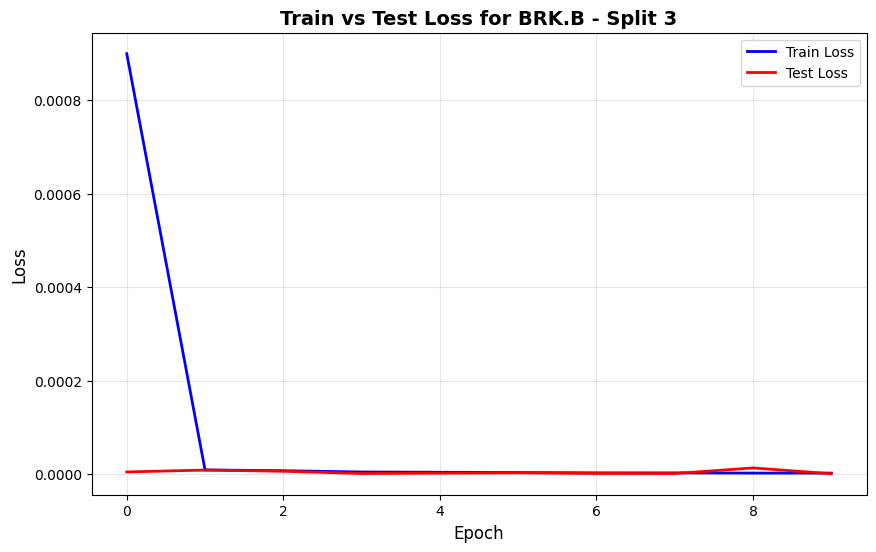

1898/1898 [==============================] - 7s 4ms/step


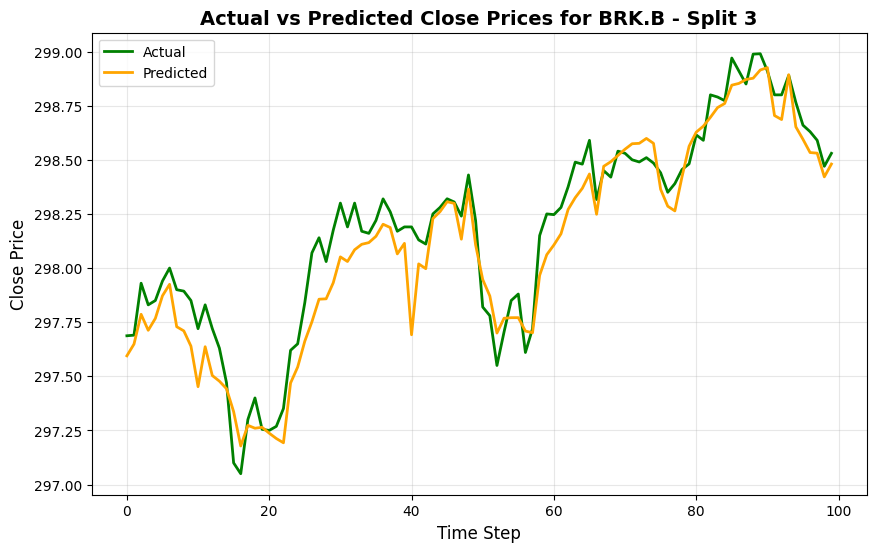

Epoch 1/10
7589/7589 [==============================] - 61s 8ms/step - loss: 5.7181e-04 - val_loss: 3.6051e-05
Epoch 2/10
7589/7589 [==============================] - 66s 9ms/step - loss: 9.3873e-06 - val_loss: 7.6653e-06
Epoch 3/10
7589/7589 [==============================] - 62s 8ms/step - loss: 6.8363e-06 - val_loss: 1.1407e-05
Epoch 4/10
7589/7589 [==============================] - 67s 9ms/step - loss: 5.1657e-06 - val_loss: 2.4362e-05
Epoch 5/10
7589/7589 [==============================] - 66s 9ms/step - loss: 4.1989e-06 - val_loss: 1.9417e-06
Epoch 6/10
7589/7589 [==============================] - 62s 8ms/step - loss: 3.3097e-06 - val_loss: 1.5545e-05
Epoch 7/10
7589/7589 [==============================] - 61s 8ms/step - loss: 2.9207e-06 - val_loss: 1.0329e-05
Epoch 8/10
7589/7589 [==============================] - 64s 8ms/step - loss: 2.5355e-06 - val_loss: 3.8116e-06
Epoch 9/10
7589/7589 [==============================] - 68s 9ms/step - loss: 2.2914e-06 - val_loss: 2.5548e-06
E

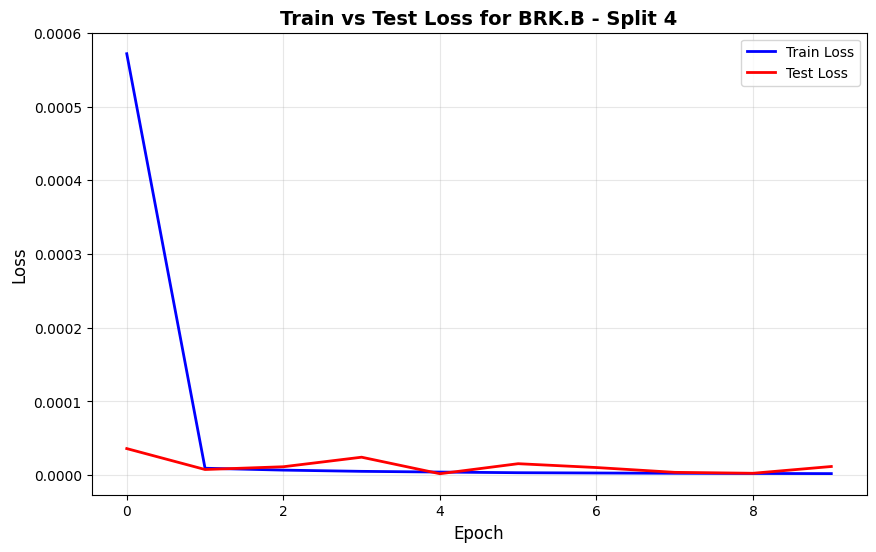

1898/1898 [==============================] - 7s 3ms/step


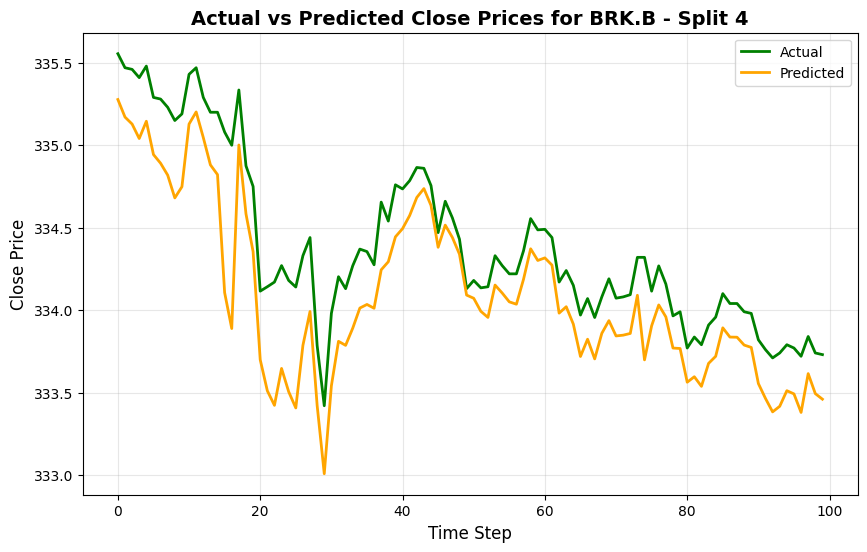

Epoch 1/10
9486/9486 [==============================] - 78s 8ms/step - loss: 1.9963e-04 - val_loss: 3.5634e-04
Epoch 2/10
9486/9486 [==============================] - 73s 8ms/step - loss: 7.0739e-06 - val_loss: 0.0070
Epoch 3/10
9486/9486 [==============================] - 71s 8ms/step - loss: 4.4846e-06 - val_loss: 5.3223e-04
Epoch 4/10
9486/9486 [==============================] - 82s 9ms/step - loss: 3.3895e-06 - val_loss: 6.4724e-04
Epoch 5/10
9486/9486 [==============================] - 83s 9ms/step - loss: 3.1596e-06 - val_loss: 4.7567e-04
Epoch 6/10
9486/9486 [==============================] - 80s 8ms/step - loss: 2.5759e-06 - val_loss: 5.9856e-04
Epoch 7/10
9486/9486 [==============================] - 81s 9ms/step - loss: 2.3707e-06 - val_loss: 4.3385e-04
Epoch 8/10
9486/9486 [==============================] - 83s 9ms/step - loss: 1.9907e-06 - val_loss: 9.0953e-04
Epoch 9/10
9486/9486 [==============================] - 84s 9ms/step - loss: 1.9432e-06 - val_loss: 0.0014
Epoch 10/

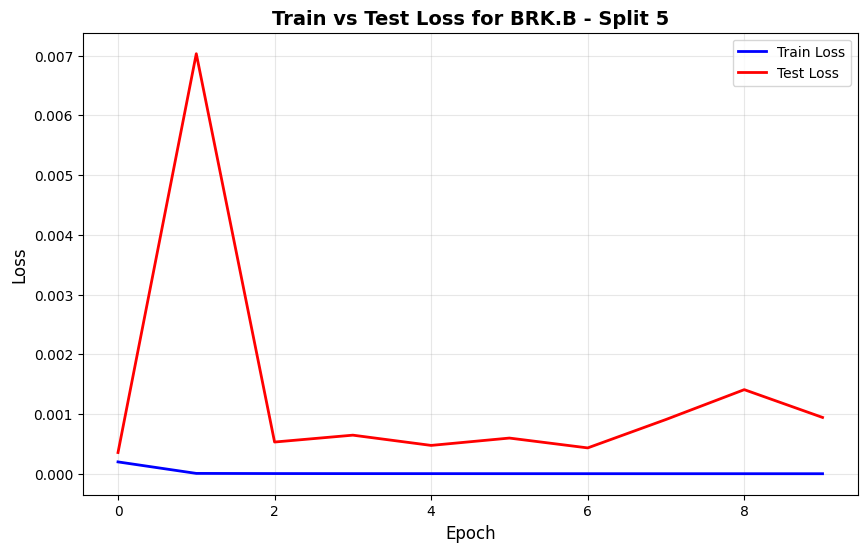

1898/1898 [==============================] - 7s 4ms/step


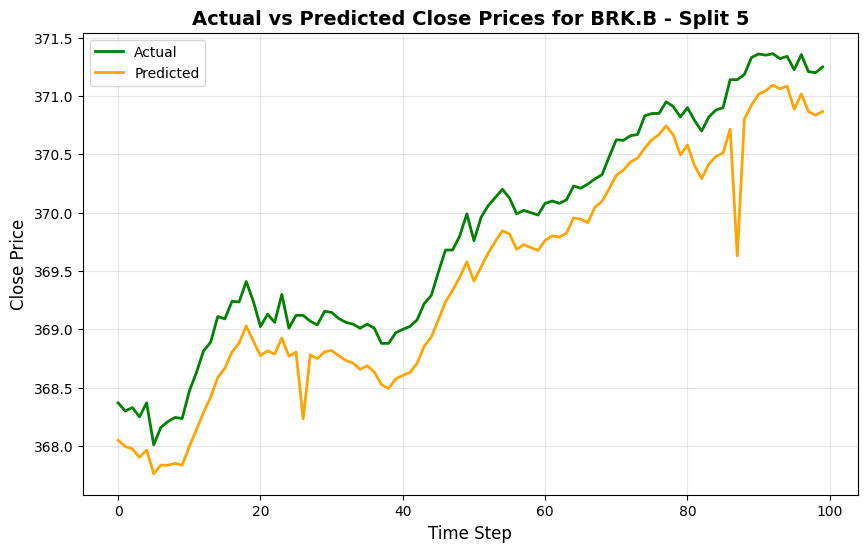

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: BRK.B. Model, scalers, and graphs saved.
Epoch 1/10
1886/1886 [==============================] - 24s 12ms/step - loss: 0.0015 - val_loss: 5.3514e-05
Epoch 2/10
1886/1886 [==============================] - 21s 11ms/step - loss: 1.6532e-05 - val_loss: 2.4010e-05
Epoch 3/10
1886/1886 [==============================] - 20s 10ms/step - loss: 1.4276e-05 - val_loss: 5.1976e-05
Epoch 4/10
1886/1886 [==============================] - 20s 11ms/step - loss: 1.2630e-05 - val_loss: 1.8677e-05
Epoch 5/10
1886/1886 [==============================] - 22s 12ms/step - loss: 1.0126e-05 - val_loss: 3.6863e-06
Epoch 6/10
1886/1886 [==============================] - 20s 11ms/step - loss: 9.9503e-06 - val_loss: 6.8271e-06
Epoch 7/10
1886/1886 [==============================] - 22s 12ms/step - loss: 7.9814e-06 - val_loss: 1.3517e-04
Epoch 8/10
1886/1886 [==============================] - 21s 11ms/step - loss: 6.9273e-06 - val_loss: 1.3364e-05
Epoch 9/10
1886/1886 [========================

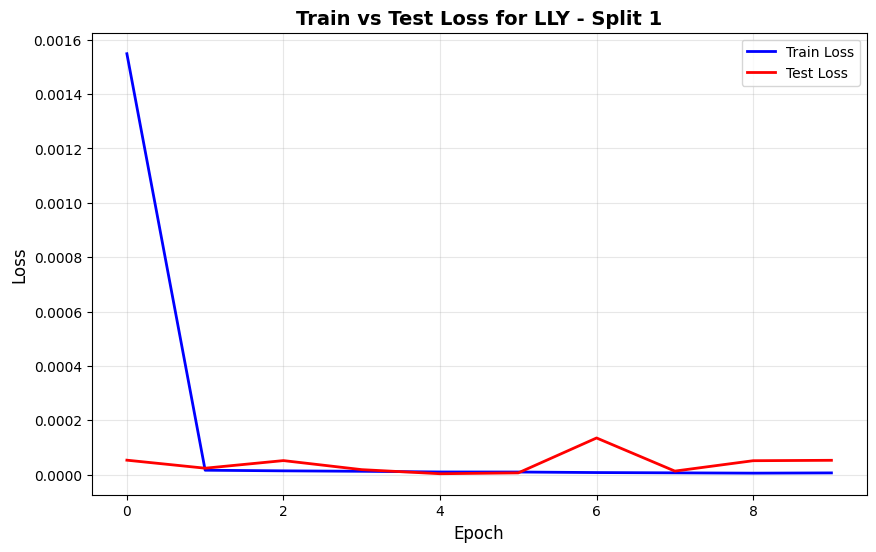

1886/1886 [==============================] - 7s 4ms/step


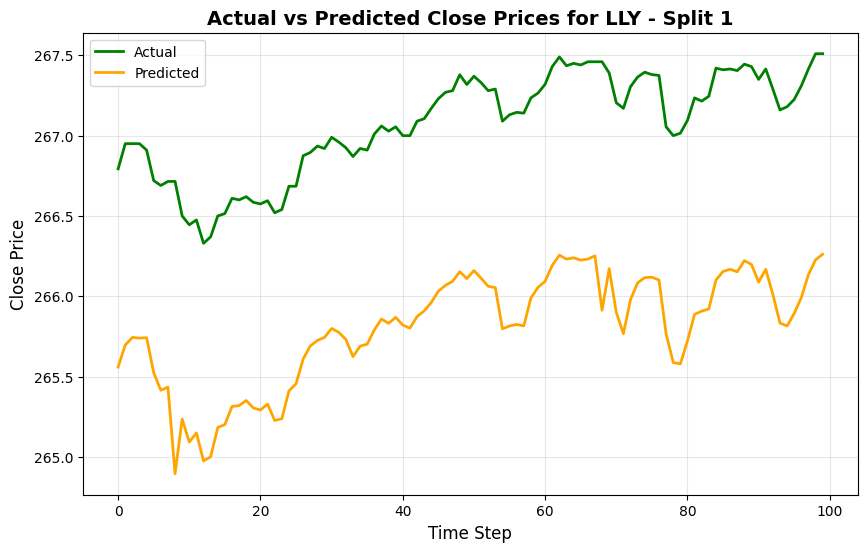

Epoch 1/10
3771/3771 [==============================] - 37s 9ms/step - loss: 7.7666e-04 - val_loss: 2.5574e-04
Epoch 2/10
3771/3771 [==============================] - 37s 10ms/step - loss: 9.5601e-06 - val_loss: 0.0029
Epoch 3/10
3771/3771 [==============================] - 31s 8ms/step - loss: 8.0283e-06 - val_loss: 0.0069
Epoch 4/10
3771/3771 [==============================] - 35s 9ms/step - loss: 6.1855e-06 - val_loss: 0.0093
Epoch 5/10
3771/3771 [==============================] - 37s 10ms/step - loss: 5.2695e-06 - val_loss: 0.0074
Epoch 6/10
3771/3771 [==============================] - 37s 10ms/step - loss: 5.2089e-06 - val_loss: 0.0019
Epoch 7/10
3771/3771 [==============================] - 37s 10ms/step - loss: 4.3406e-06 - val_loss: 0.0013
Epoch 8/10
3771/3771 [==============================] - 38s 10ms/step - loss: 3.6804e-06 - val_loss: 9.1718e-04
Epoch 9/10
3771/3771 [==============================] - 35s 9ms/step - loss: 3.7681e-06 - val_loss: 3.3916e-04
Epoch 10/10
3771/377

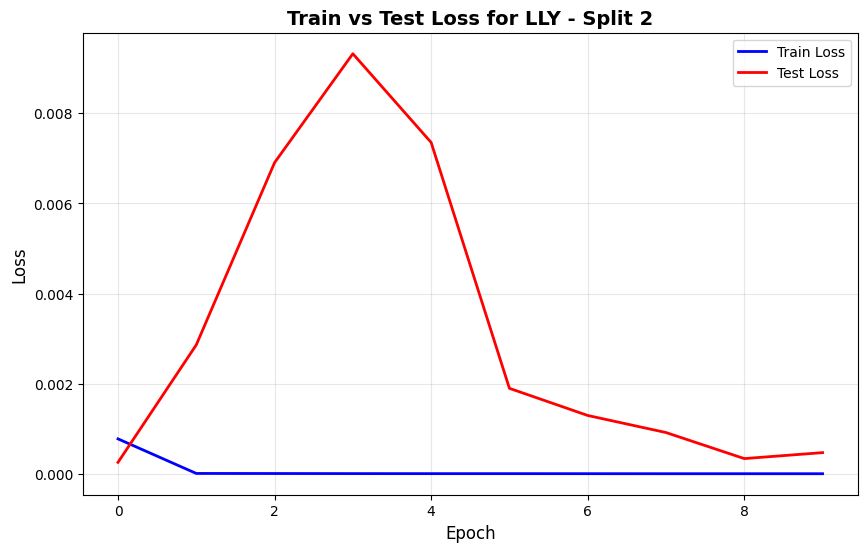

1886/1886 [==============================] - 7s 4ms/step


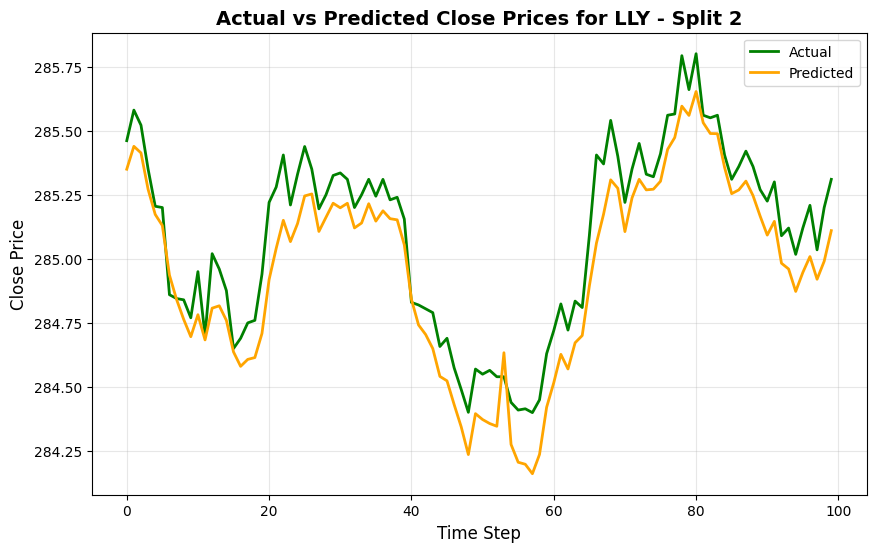

Epoch 1/10
5656/5656 [==============================] - 48s 8ms/step - loss: 4.3522e-04 - val_loss: 7.9260e-05
Epoch 2/10
5656/5656 [==============================] - 50s 9ms/step - loss: 1.0230e-05 - val_loss: 6.8845e-04
Epoch 3/10
5656/5656 [==============================] - 46s 8ms/step - loss: 5.6756e-06 - val_loss: 4.3671e-04
Epoch 4/10
5656/5656 [==============================] - 49s 9ms/step - loss: 3.9899e-06 - val_loss: 4.2330e-04
Epoch 5/10
5656/5656 [==============================] - 47s 8ms/step - loss: 3.3846e-06 - val_loss: 2.2530e-05
Epoch 6/10
5656/5656 [==============================] - 46s 8ms/step - loss: 2.7879e-06 - val_loss: 1.0245e-04
Epoch 7/10
5656/5656 [==============================] - 51s 9ms/step - loss: 2.5193e-06 - val_loss: 1.1172e-04
Epoch 8/10
5656/5656 [==============================] - 48s 9ms/step - loss: 2.3787e-06 - val_loss: 2.0332e-04
Epoch 9/10
5656/5656 [==============================] - 52s 9ms/step - loss: 2.0934e-06 - val_loss: 5.9747e-04
E

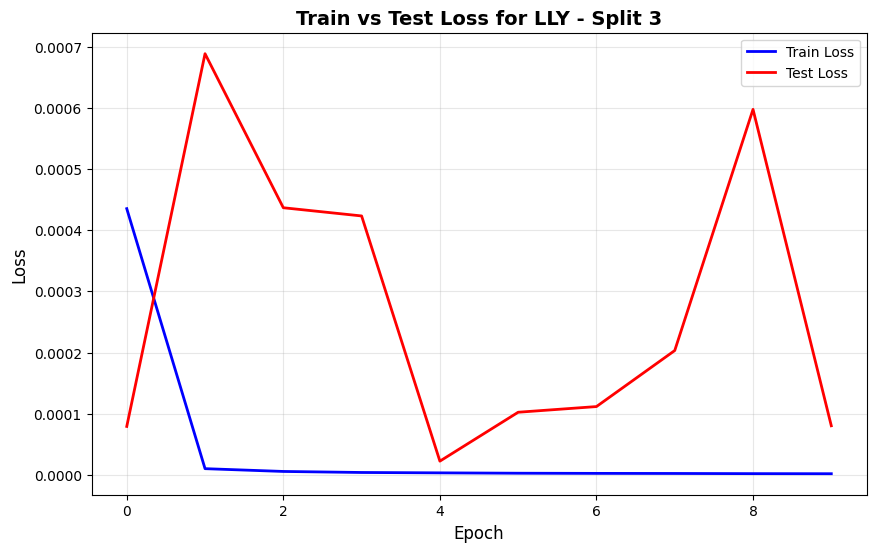

1886/1886 [==============================] - 7s 3ms/step


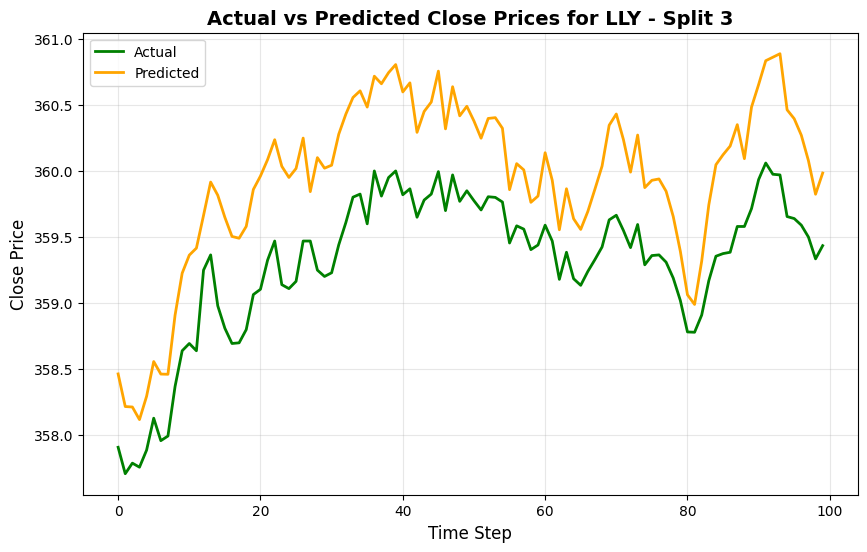

Epoch 1/10
7542/7542 [==============================] - 63s 8ms/step - loss: 4.5395e-04 - val_loss: 0.0032
Epoch 2/10
7542/7542 [==============================] - 65s 9ms/step - loss: 7.5450e-06 - val_loss: 9.1265e-04
Epoch 3/10
7542/7542 [==============================] - 67s 9ms/step - loss: 4.8867e-06 - val_loss: 9.6046e-04
Epoch 4/10
7542/7542 [==============================] - 69s 9ms/step - loss: 4.1379e-06 - val_loss: 0.0443
Epoch 5/10
7542/7542 [==============================] - 69s 9ms/step - loss: 2.7343e-06 - val_loss: 0.0676
Epoch 6/10
7542/7542 [==============================] - 60s 8ms/step - loss: 2.3161e-06 - val_loss: 0.0402
Epoch 7/10
7542/7542 [==============================] - 61s 8ms/step - loss: 1.9058e-06 - val_loss: 0.0397
Epoch 8/10
7542/7542 [==============================] - 66s 9ms/step - loss: 1.8057e-06 - val_loss: 0.0151
Epoch 9/10
7542/7542 [==============================] - 67s 9ms/step - loss: 1.7030e-06 - val_loss: 0.0187
Epoch 10/10
7542/7542 [======

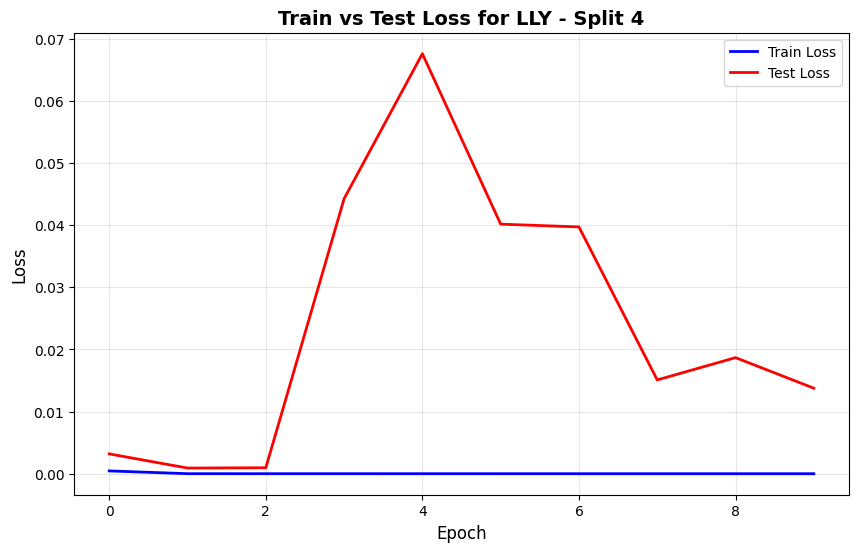

1886/1886 [==============================] - 7s 3ms/step


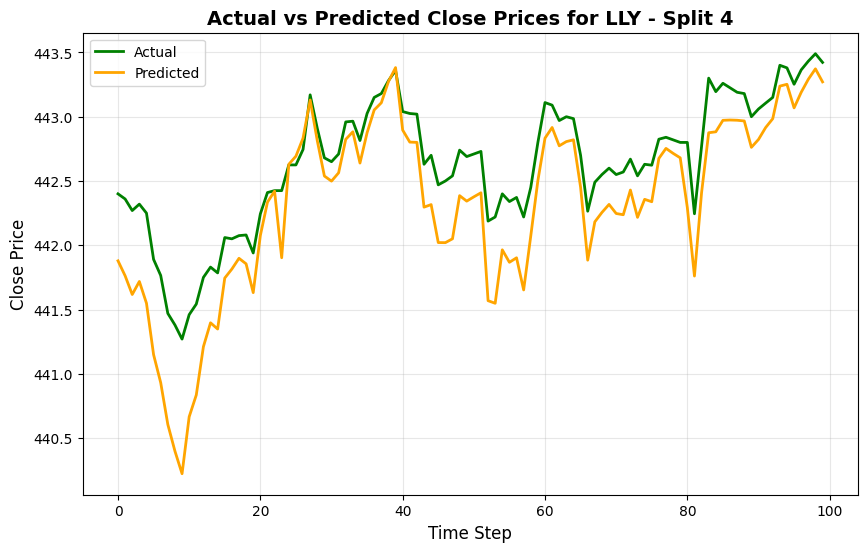

Epoch 1/10
9427/9427 [==============================] - 83s 9ms/step - loss: 2.1848e-04 - val_loss: 0.0044
Epoch 2/10
9427/9427 [==============================] - 83s 9ms/step - loss: 4.9461e-06 - val_loss: 0.0067
Epoch 3/10
9427/9427 [==============================] - 83s 9ms/step - loss: 3.6268e-06 - val_loss: 0.0103
Epoch 4/10
9427/9427 [==============================] - 83s 9ms/step - loss: 2.5110e-06 - val_loss: 0.0043
Epoch 5/10
9427/9427 [==============================] - 83s 9ms/step - loss: 2.1717e-06 - val_loss: 0.0041
Epoch 6/10
9427/9427 [==============================] - 79s 8ms/step - loss: 1.8320e-06 - val_loss: 0.0028
Epoch 7/10
9427/9427 [==============================] - 75s 8ms/step - loss: 1.5809e-06 - val_loss: 0.0051
Epoch 8/10
9427/9427 [==============================] - 74s 8ms/step - loss: 1.4643e-06 - val_loss: 0.0058
Epoch 9/10
9427/9427 [==============================] - 71s 8ms/step - loss: 1.2312e-06 - val_loss: 0.0075
Epoch 10/10
9427/9427 [==============

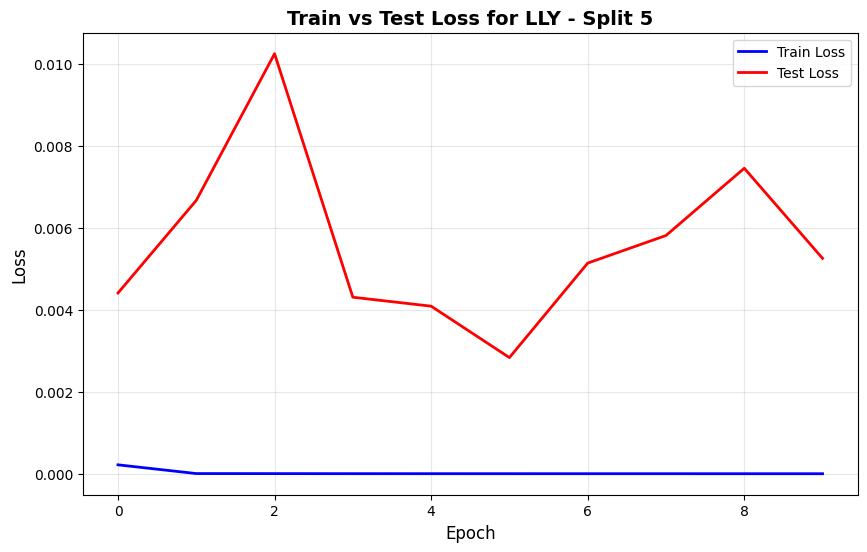

1886/1886 [==============================] - 6s 3ms/step


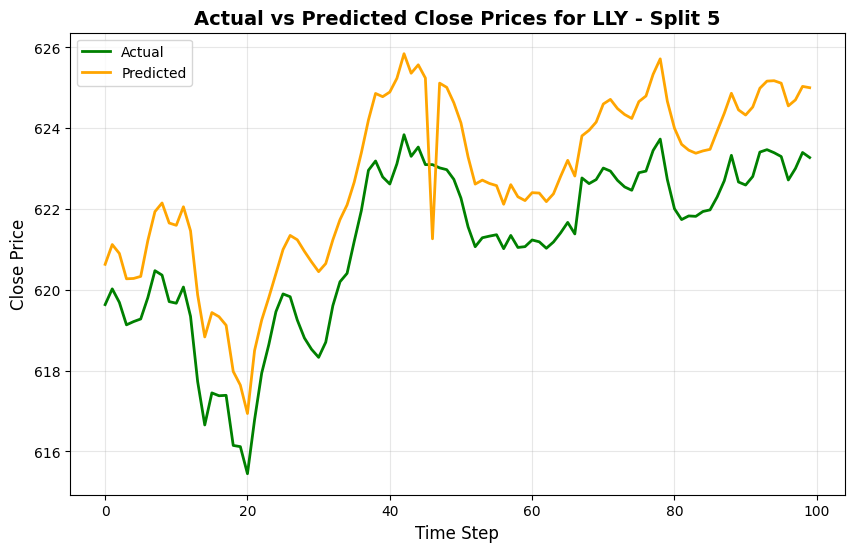

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: LLY. Model, scalers, and graphs saved.
Epoch 1/10
1867/1867 [==============================] - 22s 11ms/step - loss: 0.0018 - val_loss: 0.4496
Epoch 2/10
1867/1867 [==============================] - 22s 12ms/step - loss: 2.8097e-05 - val_loss: 0.3401
Epoch 3/10
1867/1867 [==============================] - 21s 11ms/step - loss: 2.5547e-05 - val_loss: 0.3074
Epoch 4/10
1867/1867 [==============================] - 20s 11ms/step - loss: 2.4673e-05 - val_loss: 0.7861
Epoch 5/10
1867/1867 [==============================] - 21s 11ms/step - loss: 2.3117e-05 - val_loss: 1.6155
Epoch 6/10
1867/1867 [==============================] - 21s 12ms/step - loss: 2.1232e-05 - val_loss: 2.7681
Epoch 7/10
1867/1867 [==============================] - 21s 11ms/step - loss: 2.0681e-05 - val_loss: 4.4674
Epoch 8/10
1867/1867 [==============================] - 21s 11ms/step - loss: 1.9947e-05 - val_loss: 4.0374
Epoch 9/10
1867/1867 [==============================] - 21s 11ms/step - loss: 1.

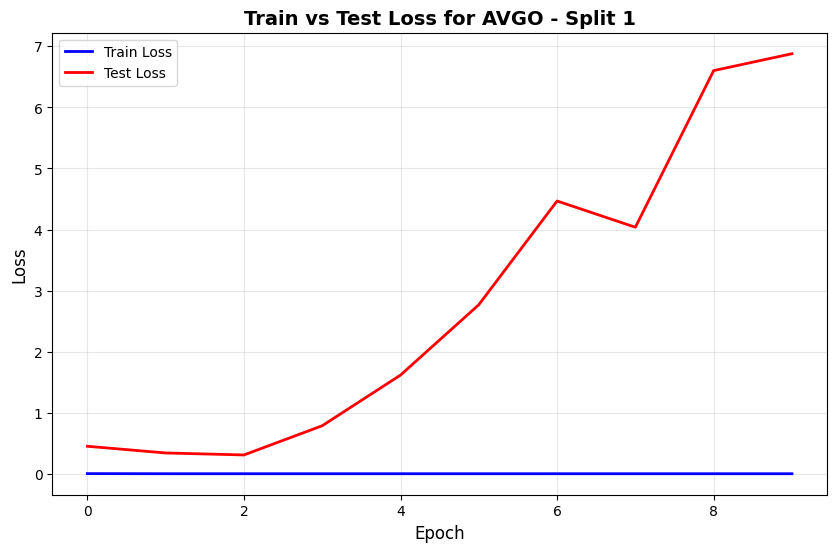

1867/1867 [==============================] - 7s 4ms/step


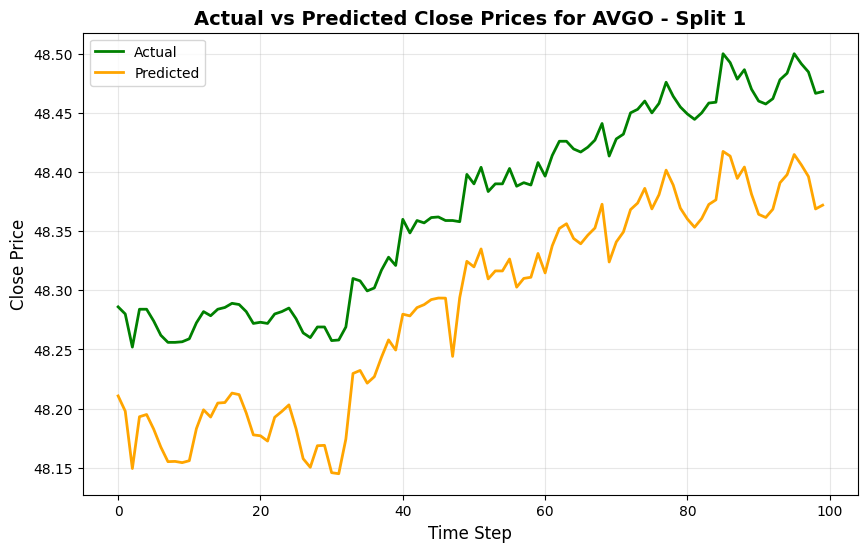

Epoch 1/10
3734/3734 [==============================] - 39s 10ms/step - loss: 0.0026 - val_loss: 1.1195e-04
Epoch 2/10
3734/3734 [==============================] - 35s 9ms/step - loss: 2.9784e-05 - val_loss: 9.6158e-06
Epoch 3/10
3734/3734 [==============================] - 36s 10ms/step - loss: 7.9872e-06 - val_loss: 6.4291e-04
Epoch 4/10
3734/3734 [==============================] - 34s 9ms/step - loss: 9.3592e-06 - val_loss: 3.8391e-06
Epoch 5/10
3734/3734 [==============================] - 32s 9ms/step - loss: 6.2510e-06 - val_loss: 4.5121e-06
Epoch 6/10
3734/3734 [==============================] - 33s 9ms/step - loss: 5.2040e-06 - val_loss: 3.3344e-06
Epoch 7/10
3734/3734 [==============================] - 31s 8ms/step - loss: 4.6587e-06 - val_loss: 6.4427e-06
Epoch 8/10
3734/3734 [==============================] - 31s 8ms/step - loss: 4.2947e-06 - val_loss: 7.7400e-06
Epoch 9/10
3734/3734 [==============================] - 31s 8ms/step - loss: 4.1228e-06 - val_loss: 3.7023e-06
Epo

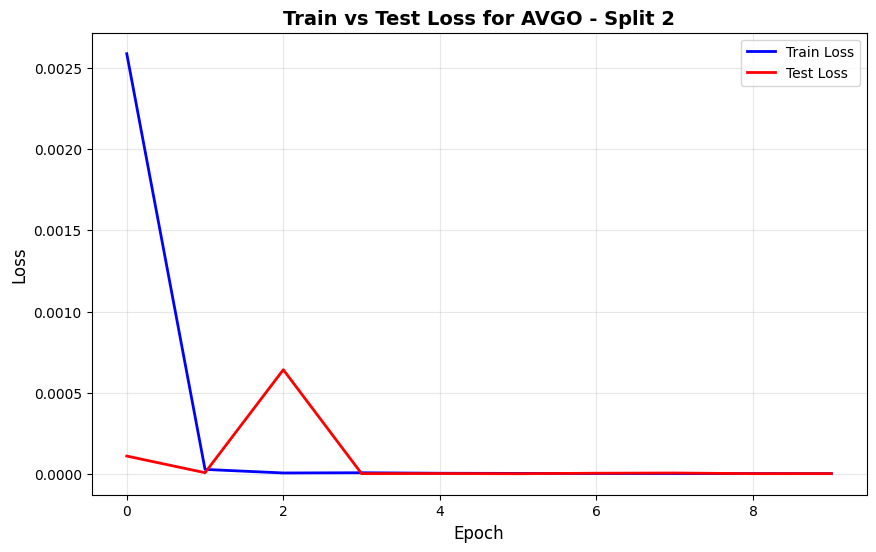

1867/1867 [==============================] - 6s 3ms/step


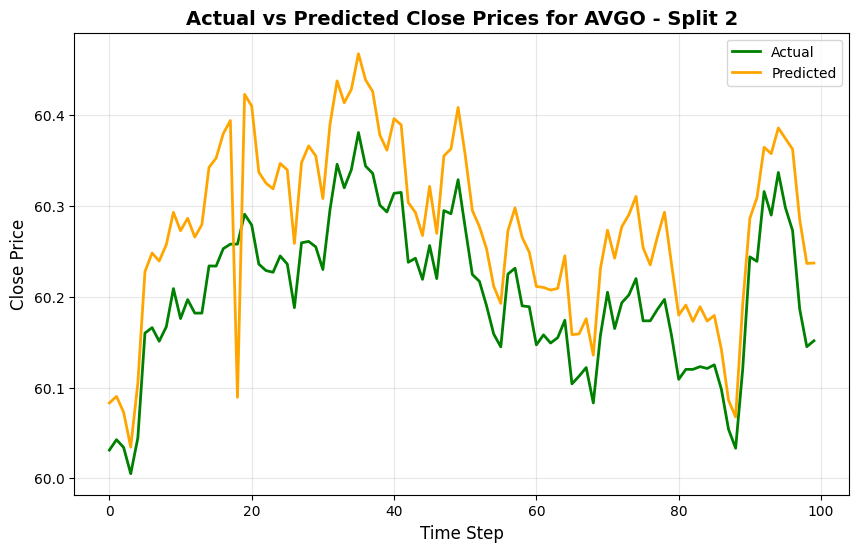

Epoch 1/10
5600/5600 [==============================] - 53s 9ms/step - loss: 3.1722e-04 - val_loss: 0.0024
Epoch 2/10
5600/5600 [==============================] - 50s 9ms/step - loss: 1.0691e-05 - val_loss: 6.3069e-04
Epoch 3/10
5600/5600 [==============================] - 50s 9ms/step - loss: 6.3129e-06 - val_loss: 3.1575e-04
Epoch 4/10
5600/5600 [==============================] - 48s 9ms/step - loss: 5.4684e-06 - val_loss: 1.4877e-04
Epoch 5/10
5600/5600 [==============================] - 51s 9ms/step - loss: 4.9197e-06 - val_loss: 2.5556e-04
Epoch 6/10
5600/5600 [==============================] - 48s 9ms/step - loss: 4.3007e-06 - val_loss: 5.1445e-05
Epoch 7/10
5600/5600 [==============================] - 52s 9ms/step - loss: 3.8629e-06 - val_loss: 2.9164e-05
Epoch 8/10
5600/5600 [==============================] - 52s 9ms/step - loss: 3.6716e-06 - val_loss: 3.1161e-05
Epoch 9/10
5600/5600 [==============================] - 50s 9ms/step - loss: 3.4546e-06 - val_loss: 1.9821e-05
Epoch

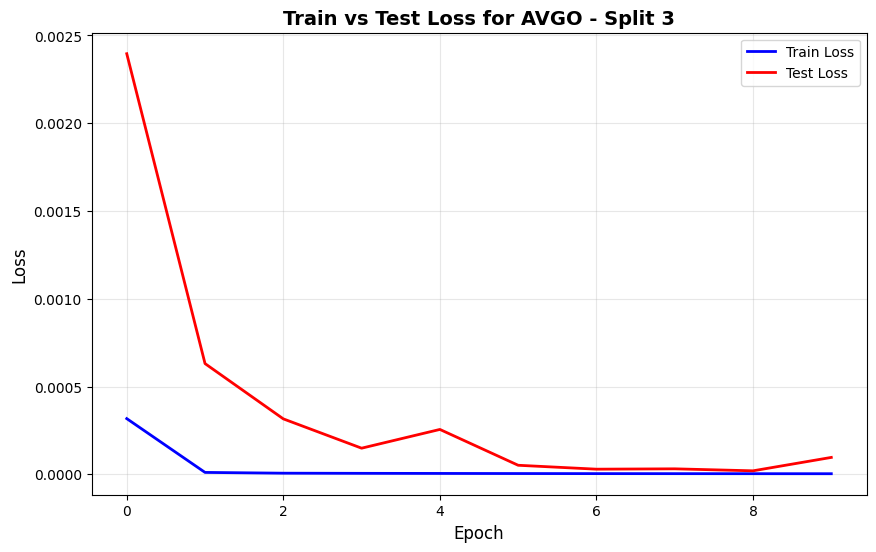

1867/1867 [==============================] - 7s 4ms/step


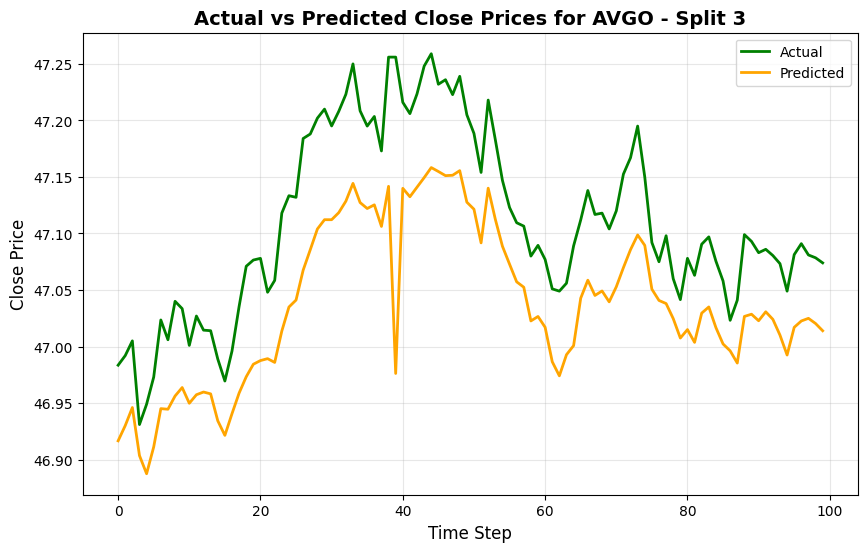

Epoch 1/10
7466/7466 [==============================] - 67s 9ms/step - loss: 1.1481e-04 - val_loss: 2.5353e-04
Epoch 2/10
7466/7466 [==============================] - 65s 9ms/step - loss: 6.0536e-06 - val_loss: 2.7604e-04
Epoch 3/10
7466/7466 [==============================] - 66s 9ms/step - loss: 3.8592e-06 - val_loss: 1.4841e-05
Epoch 4/10
7466/7466 [==============================] - 66s 9ms/step - loss: 3.0145e-06 - val_loss: 4.7056e-05
Epoch 5/10
7466/7466 [==============================] - 63s 8ms/step - loss: 2.6762e-06 - val_loss: 6.4818e-05
Epoch 6/10
7466/7466 [==============================] - 68s 9ms/step - loss: 2.2015e-06 - val_loss: 1.6647e-04
Epoch 7/10
7466/7466 [==============================] - 62s 8ms/step - loss: 2.1216e-06 - val_loss: 1.0855e-04
Epoch 8/10
7466/7466 [==============================] - 66s 9ms/step - loss: 1.8664e-06 - val_loss: 2.0682e-05
Epoch 9/10
7466/7466 [==============================] - 65s 9ms/step - loss: 1.6582e-06 - val_loss: 3.0229e-05
E

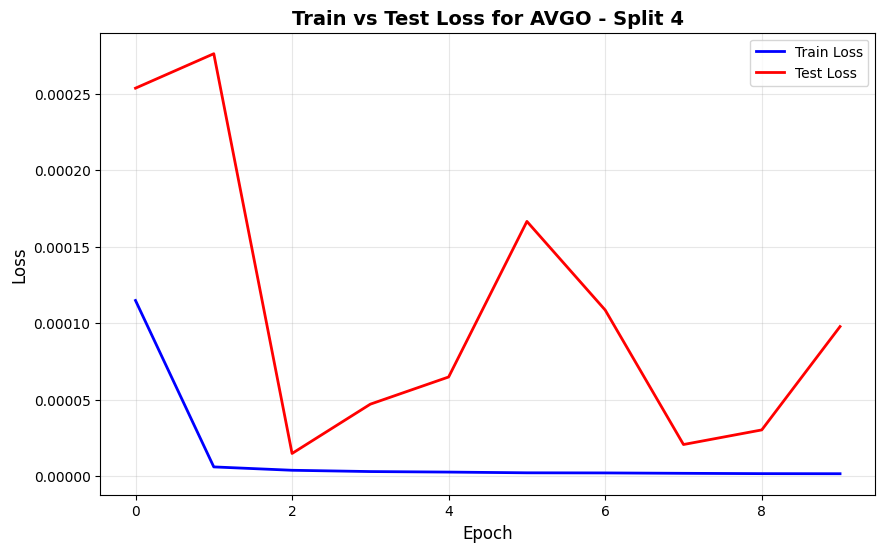

1867/1867 [==============================] - 7s 3ms/step


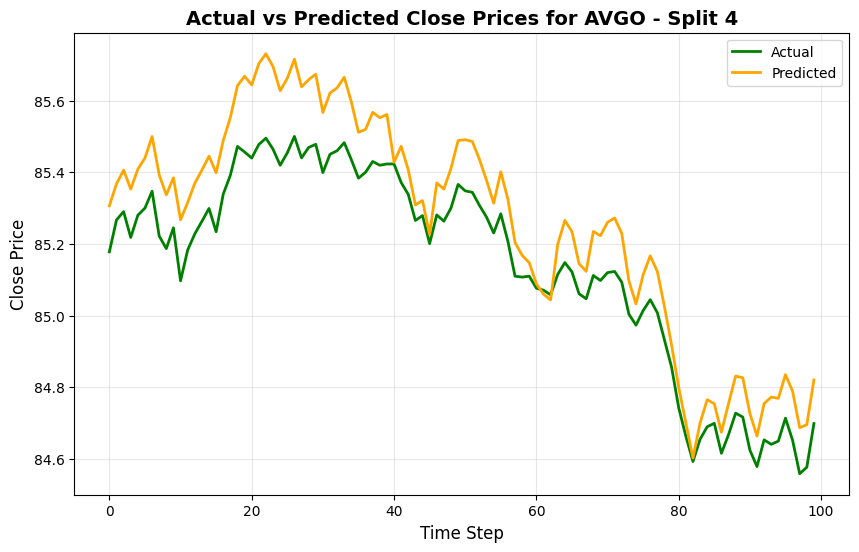

Epoch 1/10
9333/9333 [==============================] - 80s 8ms/step - loss: 2.1097e-04 - val_loss: 0.0042
Epoch 2/10
9333/9333 [==============================] - 82s 9ms/step - loss: 5.4069e-06 - val_loss: 0.0062
Epoch 3/10
9333/9333 [==============================] - 79s 8ms/step - loss: 3.6078e-06 - val_loss: 0.0087
Epoch 4/10
9333/9333 [==============================] - 75s 8ms/step - loss: 2.6823e-06 - val_loss: 0.0028
Epoch 5/10
9333/9333 [==============================] - 81s 9ms/step - loss: 2.2237e-06 - val_loss: 0.0025
Epoch 6/10
9333/9333 [==============================] - 83s 9ms/step - loss: 1.8375e-06 - val_loss: 0.0015
Epoch 7/10
9333/9333 [==============================] - 75s 8ms/step - loss: 1.6844e-06 - val_loss: 0.0034
Epoch 8/10
9333/9333 [==============================] - 80s 9ms/step - loss: 1.2754e-06 - val_loss: 0.0018
Epoch 9/10
9333/9333 [==============================] - 83s 9ms/step - loss: 1.2097e-06 - val_loss: 0.0043
Epoch 10/10
9333/9333 [==============

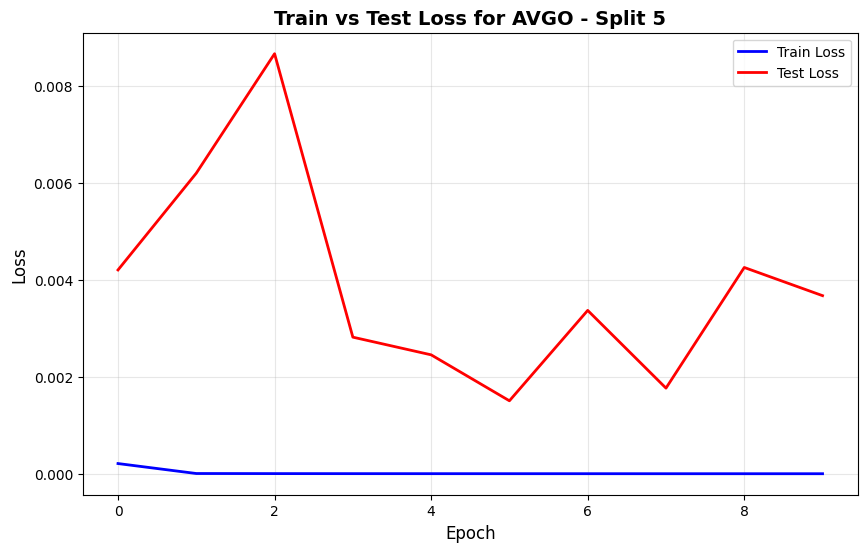

1867/1867 [==============================] - 7s 4ms/step


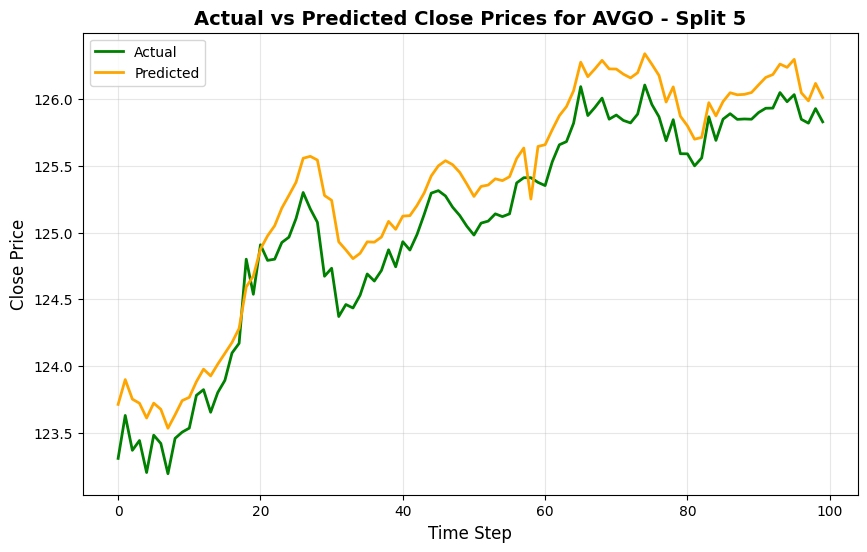

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: AVGO. Model, scalers, and graphs saved.
Epoch 1/10
1905/1905 [==============================] - 24s 12ms/step - loss: 0.0013 - val_loss: 0.0193
Epoch 2/10
1905/1905 [==============================] - 23s 12ms/step - loss: 2.4099e-05 - val_loss: 0.0127
Epoch 3/10
1905/1905 [==============================] - 22s 12ms/step - loss: 1.6415e-05 - val_loss: 0.0079
Epoch 4/10
1905/1905 [==============================] - 22s 12ms/step - loss: 1.5739e-05 - val_loss: 0.0055
Epoch 5/10
1905/1905 [==============================] - 22s 12ms/step - loss: 1.5029e-05 - val_loss: 0.0051
Epoch 6/10
1905/1905 [==============================] - 23s 12ms/step - loss: 1.3103e-05 - val_loss: 0.0033
Epoch 7/10
1905/1905 [==============================] - 23s 12ms/step - loss: 9.7875e-06 - val_loss: 0.0029
Epoch 8/10
1905/1905 [==============================] - 23s 12ms/step - loss: 1.0916e-05 - val_loss: 0.0029
Epoch 9/10
1905/1905 [==============================] - 22s 12ms/step - loss: 9

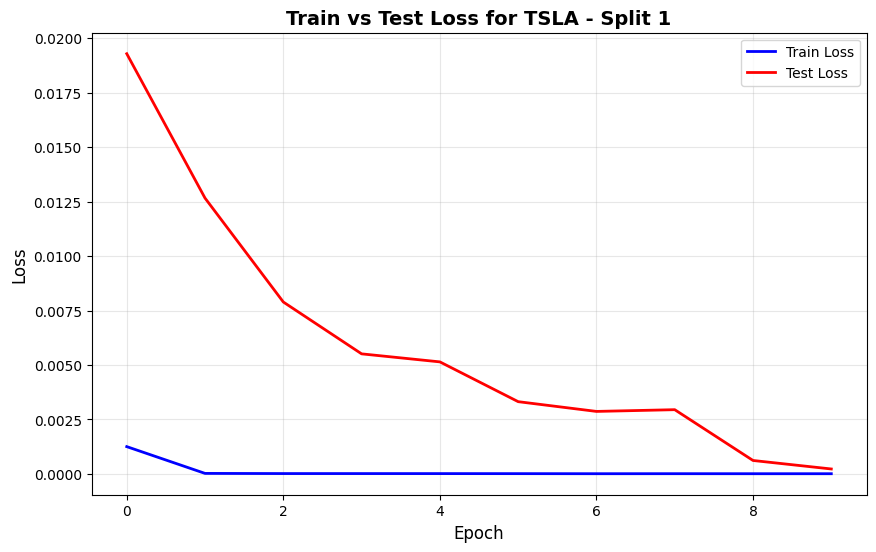

1905/1905 [==============================] - 7s 3ms/step


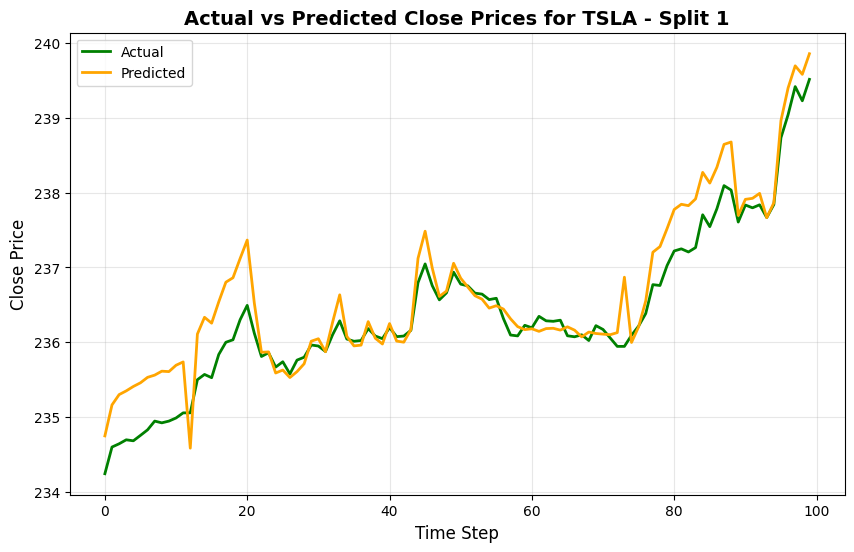

Epoch 1/10
3809/3809 [==============================] - 35s 9ms/step - loss: 4.9917e-04 - val_loss: 6.1059e-06
Epoch 2/10
3809/3809 [==============================] - 38s 10ms/step - loss: 1.5449e-05 - val_loss: 9.2366e-06
Epoch 3/10
3809/3809 [==============================] - 38s 10ms/step - loss: 1.1468e-05 - val_loss: 3.8926e-06
Epoch 4/10
3809/3809 [==============================] - 36s 9ms/step - loss: 1.0389e-05 - val_loss: 4.4469e-06
Epoch 5/10
3809/3809 [==============================] - 36s 9ms/step - loss: 7.8735e-06 - val_loss: 3.4316e-06
Epoch 6/10
3809/3809 [==============================] - 36s 9ms/step - loss: 6.2170e-06 - val_loss: 4.2195e-06
Epoch 7/10
3809/3809 [==============================] - 37s 10ms/step - loss: 5.6769e-06 - val_loss: 3.4159e-06
Epoch 8/10
3809/3809 [==============================] - 36s 10ms/step - loss: 5.5773e-06 - val_loss: 7.2774e-06
Epoch 9/10
3809/3809 [==============================] - 35s 9ms/step - loss: 5.0798e-06 - val_loss: 2.1242e-

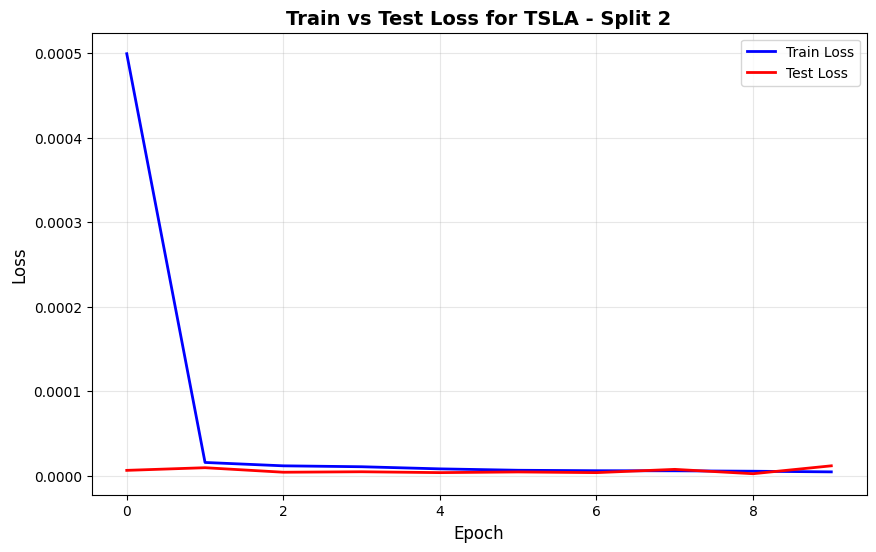

1905/1905 [==============================] - 7s 4ms/step


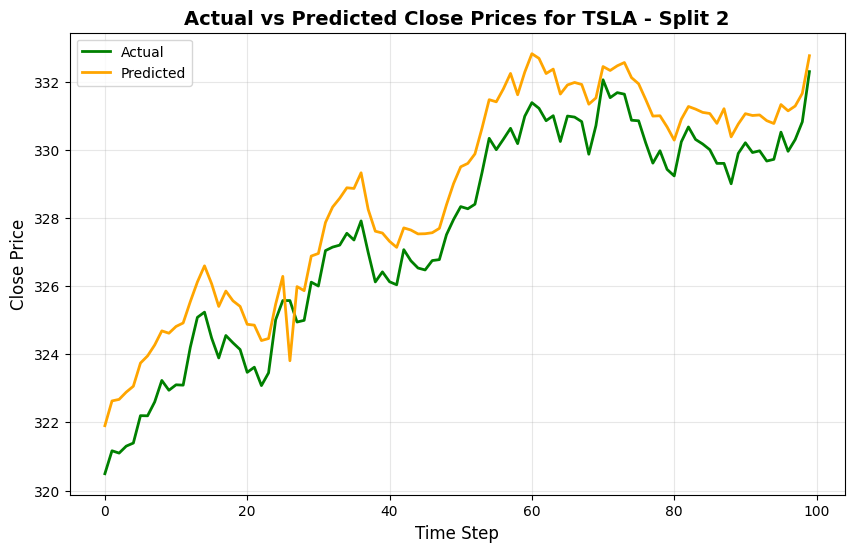

Epoch 1/10
5714/5714 [==============================] - 52s 9ms/step - loss: 2.3677e-04 - val_loss: 0.0028
Epoch 2/10
5714/5714 [==============================] - 54s 9ms/step - loss: 1.0907e-05 - val_loss: 8.0540e-04
Epoch 3/10
5714/5714 [==============================] - 51s 9ms/step - loss: 8.3109e-06 - val_loss: 0.0012
Epoch 4/10
5714/5714 [==============================] - 52s 9ms/step - loss: 6.4809e-06 - val_loss: 0.0178
Epoch 5/10
5714/5714 [==============================] - 54s 9ms/step - loss: 5.2231e-06 - val_loss: 0.0222
Epoch 6/10
5714/5714 [==============================] - 53s 9ms/step - loss: 4.7225e-06 - val_loss: 0.0353
Epoch 7/10
5714/5714 [==============================] - 53s 9ms/step - loss: 4.5217e-06 - val_loss: 0.0406
Epoch 8/10
5714/5714 [==============================] - 50s 9ms/step - loss: 3.9793e-06 - val_loss: 0.0469
Epoch 9/10
5714/5714 [==============================] - 54s 9ms/step - loss: 3.8992e-06 - val_loss: 0.0365
Epoch 10/10
5714/5714 [==========

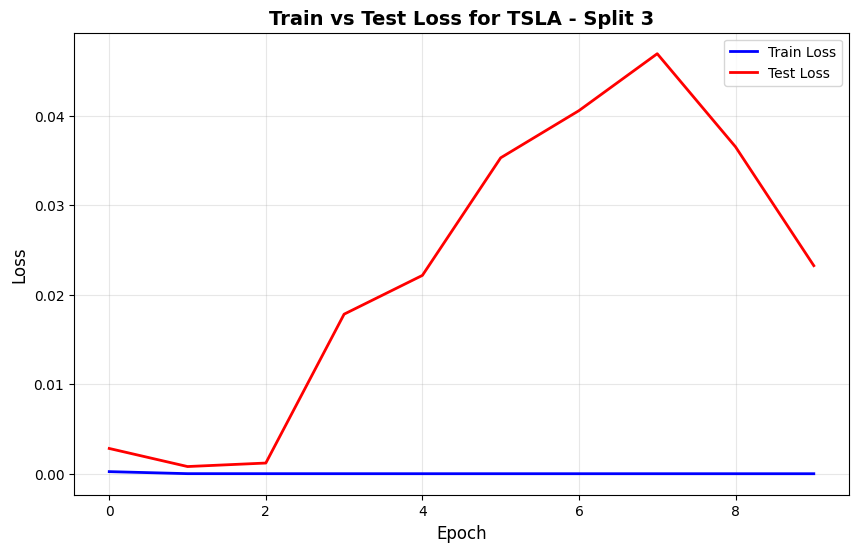

1905/1905 [==============================] - 7s 3ms/step


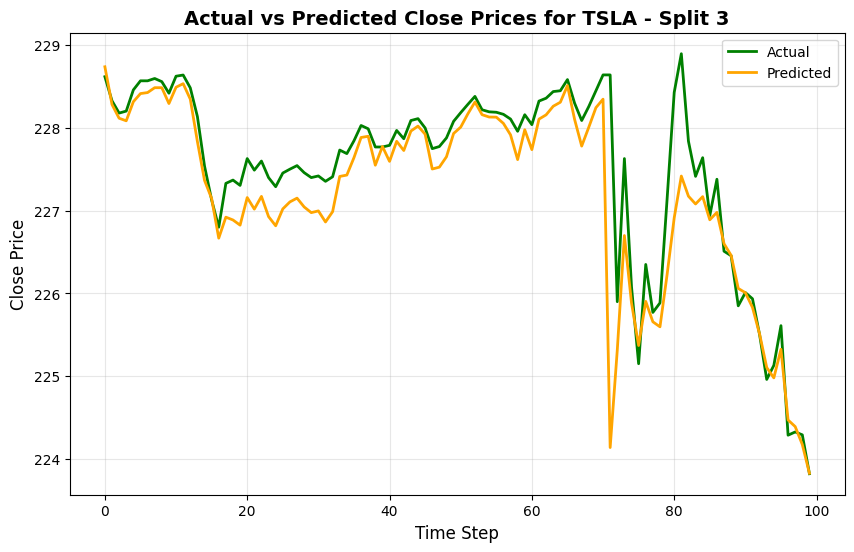

Epoch 1/10
7618/7618 [==============================] - 69s 9ms/step - loss: 7.5830e-04 - val_loss: 3.9113e-05
Epoch 2/10
7618/7618 [==============================] - 67s 9ms/step - loss: 8.0796e-06 - val_loss: 1.7774e-06
Epoch 3/10
7618/7618 [==============================] - 68s 9ms/step - loss: 5.8838e-06 - val_loss: 2.0000e-05
Epoch 4/10
7618/7618 [==============================] - 67s 9ms/step - loss: 4.5728e-06 - val_loss: 3.1739e-06
Epoch 5/10
7618/7618 [==============================] - 65s 9ms/step - loss: 3.7939e-06 - val_loss: 9.7009e-07
Epoch 6/10
7618/7618 [==============================] - 68s 9ms/step - loss: 3.2536e-06 - val_loss: 1.1651e-06
Epoch 7/10
7618/7618 [==============================] - 70s 9ms/step - loss: 2.8389e-06 - val_loss: 4.7323e-06
Epoch 8/10
7618/7618 [==============================] - 67s 9ms/step - loss: 2.7736e-06 - val_loss: 8.1959e-07
Epoch 9/10
7618/7618 [==============================] - 67s 9ms/step - loss: 2.4954e-06 - val_loss: 1.1156e-06
E

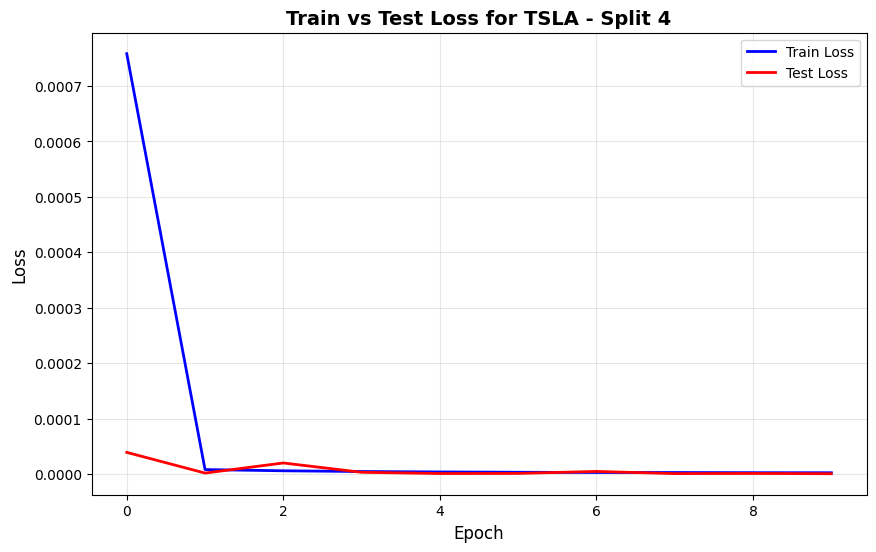

1905/1905 [==============================] - 7s 4ms/step


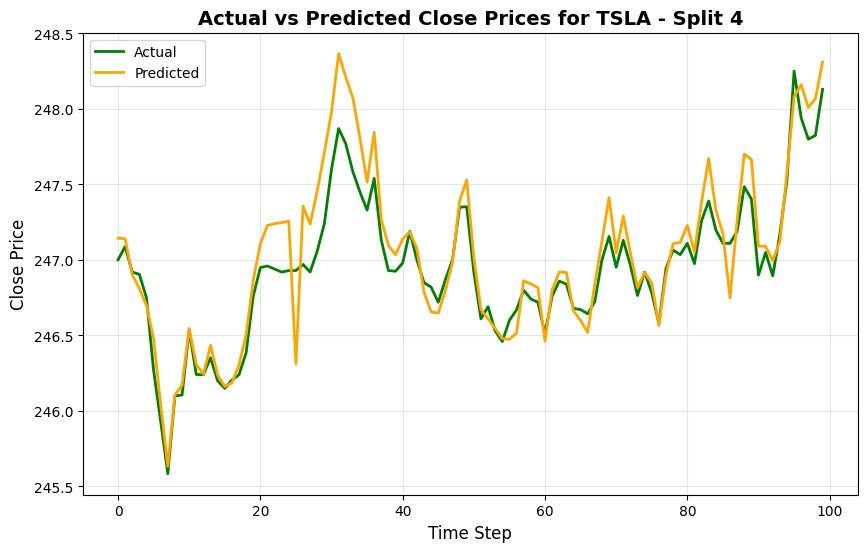

Epoch 1/10
9523/9523 [==============================] - 84s 9ms/step - loss: 2.1604e-04 - val_loss: 1.0164e-05
Epoch 2/10
9523/9523 [==============================] - 73s 8ms/step - loss: 6.9890e-06 - val_loss: 5.4170e-06
Epoch 3/10
9523/9523 [==============================] - 78s 8ms/step - loss: 4.3297e-06 - val_loss: 3.9166e-06
Epoch 4/10
9523/9523 [==============================] - 77s 8ms/step - loss: 3.4043e-06 - val_loss: 1.9242e-06
Epoch 5/10
9523/9523 [==============================] - 73s 8ms/step - loss: 2.9596e-06 - val_loss: 2.2104e-06
Epoch 6/10
9523/9523 [==============================] - 77s 8ms/step - loss: 2.6095e-06 - val_loss: 1.1822e-06
Epoch 7/10
9523/9523 [==============================] - 80s 8ms/step - loss: 2.2212e-06 - val_loss: 2.4105e-06
Epoch 8/10
9523/9523 [==============================] - 85s 9ms/step - loss: 2.1603e-06 - val_loss: 2.2402e-06
Epoch 9/10
9523/9523 [==============================] - 81s 8ms/step - loss: 1.9434e-06 - val_loss: 1.5858e-06
E

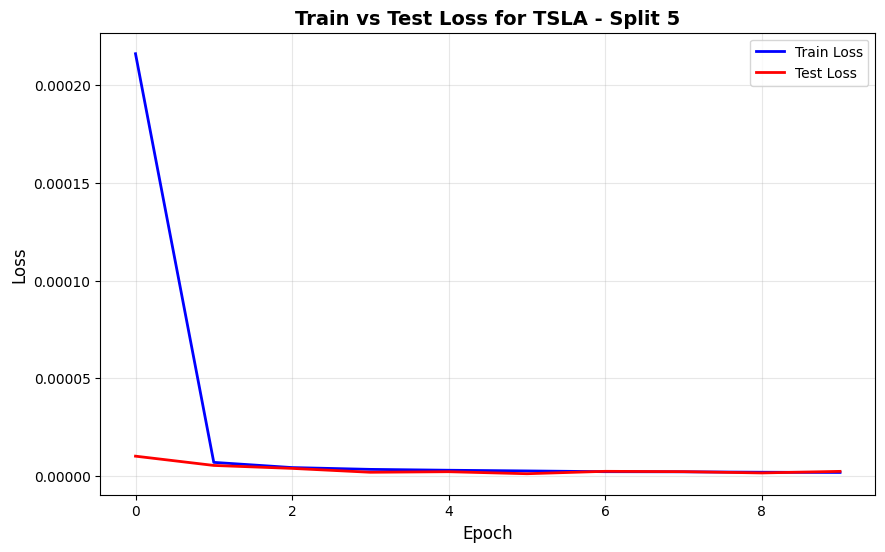

1905/1905 [==============================] - 7s 3ms/step


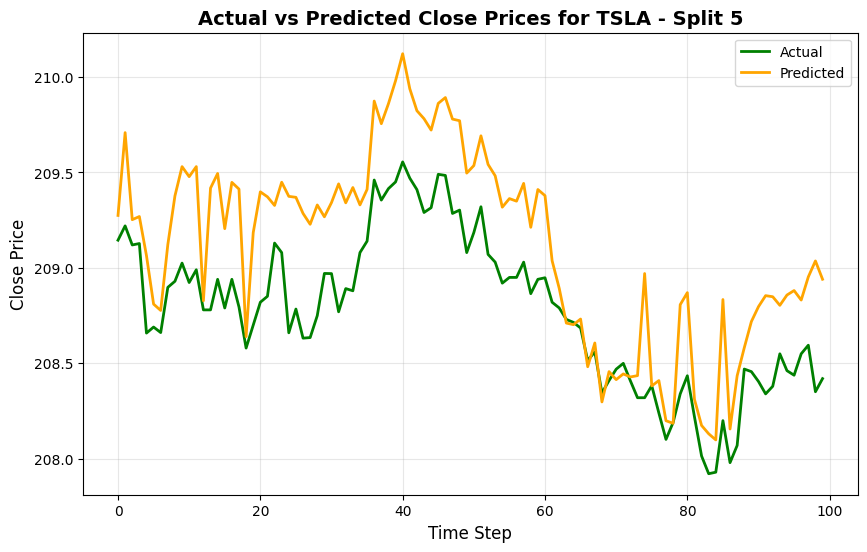

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Completed for stock: TSLA. Model, scalers, and graphs saved.
Epoch 1/10
1905/1905 [==============================] - 23s 11ms/step - loss: 0.0012 - val_loss: 7.7359e-06
Epoch 2/10
1905/1905 [==============================] - 20s 10ms/step - loss: 1.3582e-05 - val_loss: 3.1266e-05
Epoch 3/10
1905/1905 [==============================] - 22s 12ms/step - loss: 1.1489e-05 - val_loss: 3.1888e-04
Epoch 4/10
1905/1905 [==============================] - 22s 12ms/step - loss: 9.7676e-06 - val_loss: 4.3636e-06
Epoch 5/10
1905/1905 [==============================] - 23s 12ms/step - loss: 8.8198e-06 - val_loss: 8.6697e-06
Epoch 6/10
1905/1905 [==============================] - 20s 11ms/step - loss: 9.1980e-06 - val_loss: 2.0553e-05
Epoch 7/10
1905/1905 [==============================] - 22s 11ms/step - loss: 7.6966e-06 - val_loss: 3.9390e-06
Epoch 8/10
1905/1905 [==============================] - 22s 12ms/step - loss: 7.3409e-06 - val_loss: 7.5266e-06
Epoch 9/10
1905/1905 [=========================

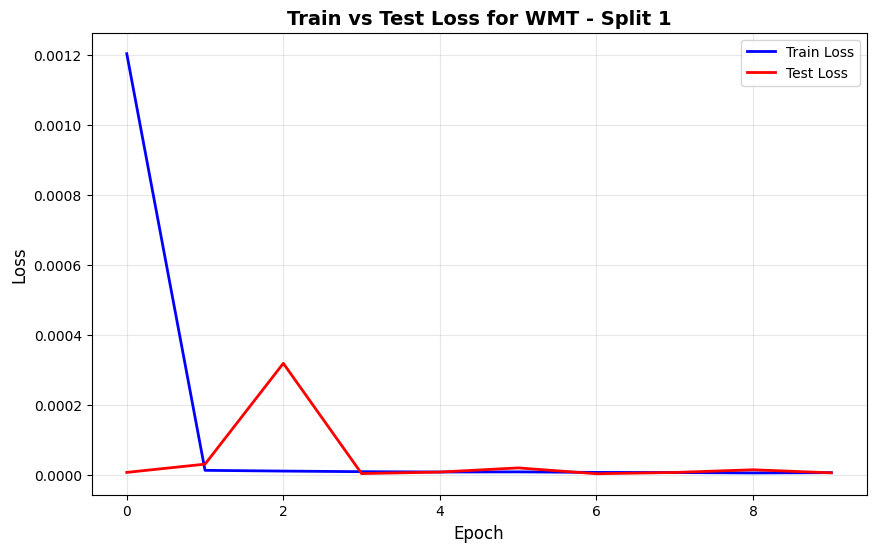

1904/1904 [==============================] - 7s 4ms/step


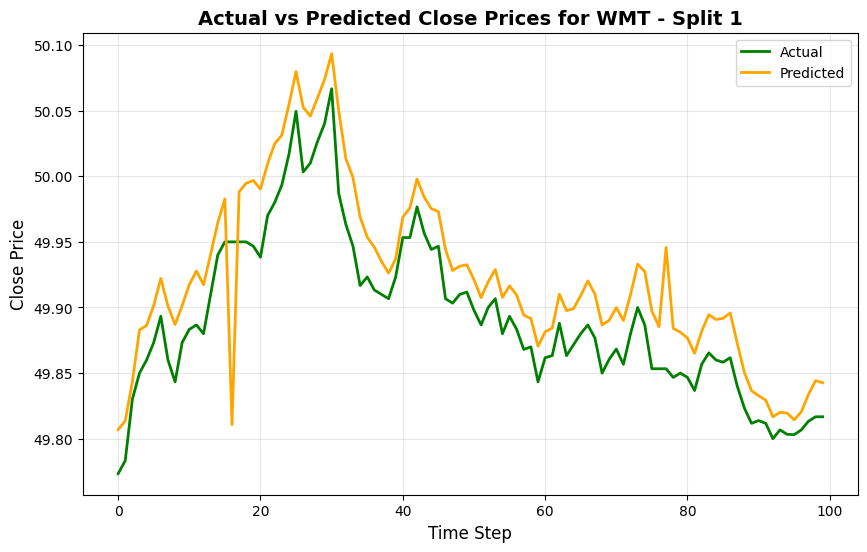

Epoch 1/10
3809/3809 [==============================] - 40s 10ms/step - loss: 9.6373e-04 - val_loss: 6.6627e-04
Epoch 2/10
3809/3809 [==============================] - 36s 9ms/step - loss: 1.2362e-05 - val_loss: 0.0051
Epoch 3/10
3809/3809 [==============================] - 35s 9ms/step - loss: 1.1002e-05 - val_loss: 0.0247
Epoch 4/10
3809/3809 [==============================] - 33s 9ms/step - loss: 8.9803e-06 - val_loss: 0.0052
Epoch 5/10
3809/3809 [==============================] - 38s 10ms/step - loss: 8.2567e-06 - val_loss: 0.0022
Epoch 6/10
3809/3809 [==============================] - 37s 10ms/step - loss: 7.2266e-06 - val_loss: 0.0037
Epoch 7/10
3809/3809 [==============================] - 35s 9ms/step - loss: 6.7721e-06 - val_loss: 0.0082
Epoch 8/10
3809/3809 [==============================] - 38s 10ms/step - loss: 6.6655e-06 - val_loss: 0.0096
Epoch 9/10
3809/3809 [==============================] - 36s 9ms/step - loss: 6.2006e-06 - val_loss: 0.0112
Epoch 10/10
3809/3809 [======

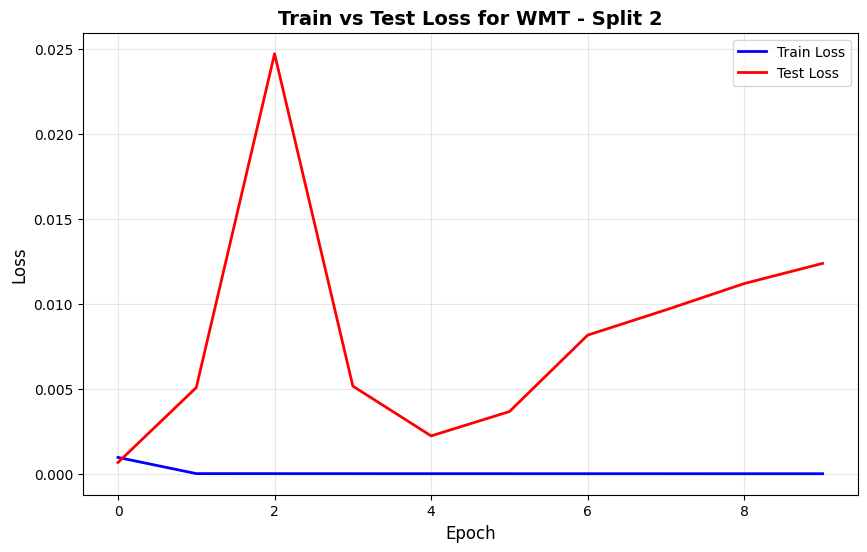

1904/1904 [==============================] - 7s 4ms/step


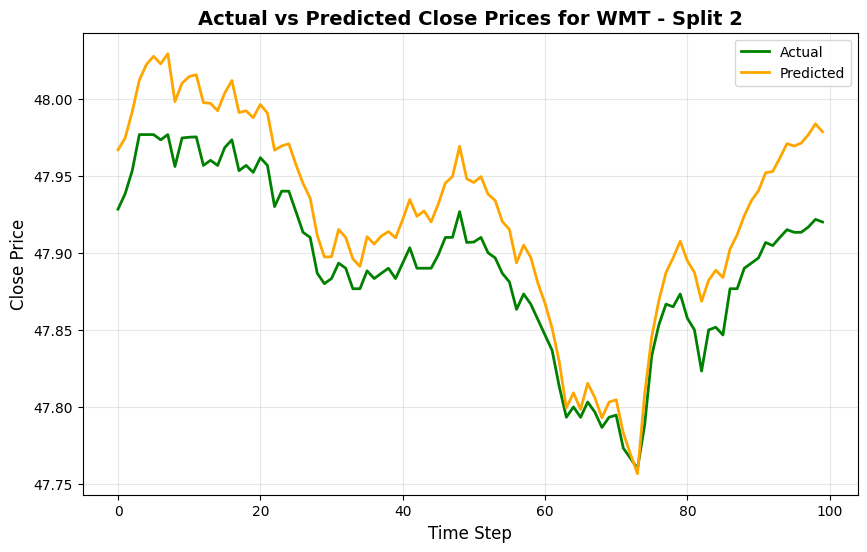

Epoch 1/10
5713/5713 [==============================] - 55s 9ms/step - loss: 3.9181e-04 - val_loss: 4.3843e-06
Epoch 2/10
5713/5713 [==============================] - 51s 9ms/step - loss: 7.6393e-06 - val_loss: 4.2761e-06
Epoch 3/10
5713/5713 [==============================] - 54s 9ms/step - loss: 5.7505e-06 - val_loss: 1.5849e-06
Epoch 4/10
5713/5713 [==============================] - 55s 10ms/step - loss: 4.7537e-06 - val_loss: 1.0264e-05
Epoch 5/10
5713/5713 [==============================] - 55s 10ms/step - loss: 4.3438e-06 - val_loss: 4.8539e-06
Epoch 6/10
5713/5713 [==============================] - 52s 9ms/step - loss: 3.9261e-06 - val_loss: 8.2515e-06
Epoch 7/10
5713/5713 [==============================] - 53s 9ms/step - loss: 3.6333e-06 - val_loss: 4.5370e-06
Epoch 8/10
5713/5713 [==============================] - 54s 9ms/step - loss: 3.3565e-06 - val_loss: 8.4929e-06
Epoch 9/10
5713/5713 [==============================] - 53s 9ms/step - loss: 3.2135e-06 - val_loss: 2.0221e-06

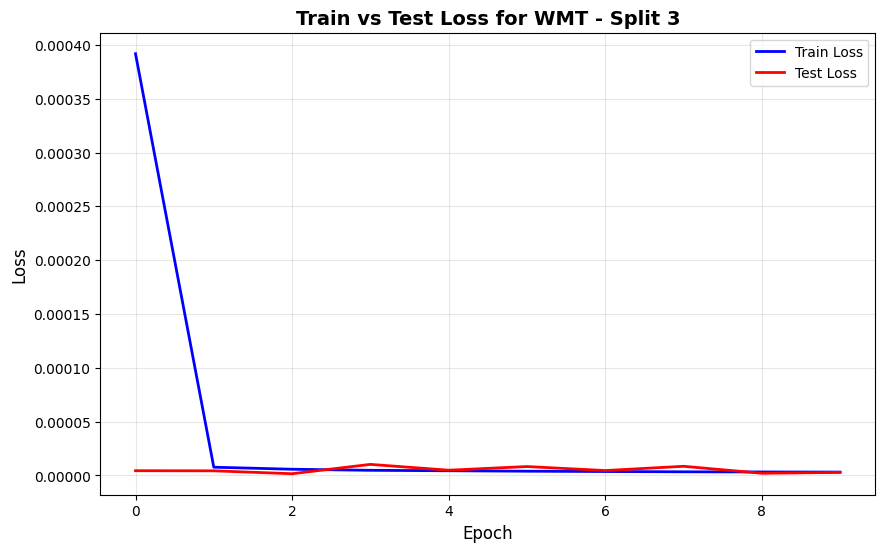

1904/1904 [==============================] - 7s 4ms/step


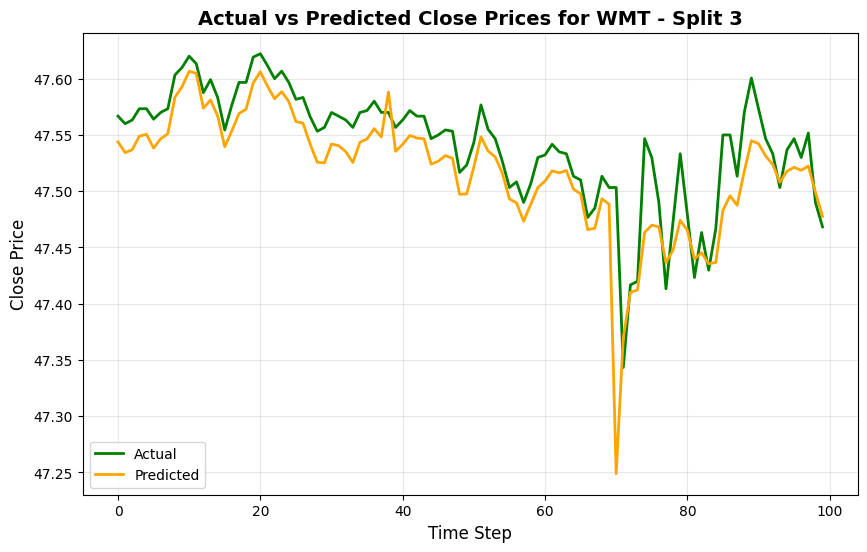

Epoch 1/10
7617/7617 [==============================] - 69s 9ms/step - loss: 3.6222e-04 - val_loss: 4.6717e-05
Epoch 2/10
7617/7617 [==============================] - 62s 8ms/step - loss: 7.7698e-06 - val_loss: 3.1358e-05
Epoch 3/10
7617/7617 [==============================] - 67s 9ms/step - loss: 6.0196e-06 - val_loss: 7.8825e-06
Epoch 4/10
7617/7617 [==============================] - 71s 9ms/step - loss: 5.0651e-06 - val_loss: 1.9272e-05
Epoch 5/10
7617/7617 [==============================] - 70s 9ms/step - loss: 4.2805e-06 - val_loss: 1.0708e-05
Epoch 6/10
7617/7617 [==============================] - 69s 9ms/step - loss: 3.8727e-06 - val_loss: 1.0220e-04
Epoch 7/10
7617/7617 [==============================] - 71s 9ms/step - loss: 3.5374e-06 - val_loss: 6.6902e-06
Epoch 8/10
7617/7617 [==============================] - 69s 9ms/step - loss: 3.2429e-06 - val_loss: 6.2427e-06
Epoch 9/10
7617/7617 [==============================] - 69s 9ms/step - loss: 3.0371e-06 - val_loss: 6.6145e-05
E

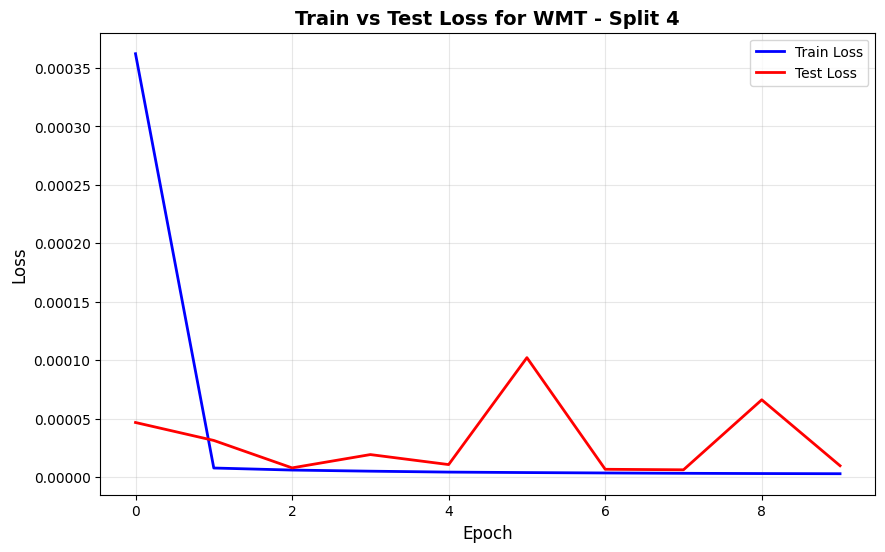

1904/1904 [==============================] - 7s 4ms/step


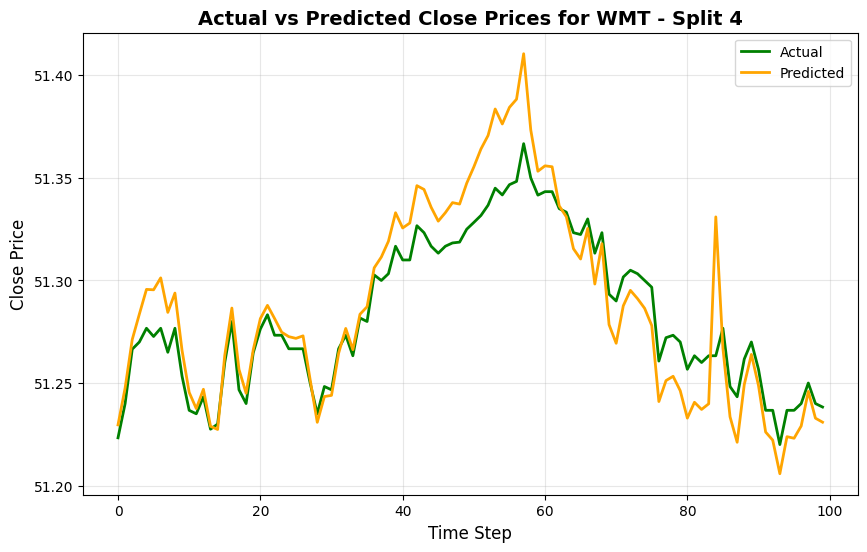

Epoch 1/10
9521/9521 [==============================] - 80s 8ms/step - loss: 2.8306e-04 - val_loss: 0.2292
Epoch 2/10
9521/9521 [==============================] - 87s 9ms/step - loss: 6.0155e-06 - val_loss: 0.1198
Epoch 3/10
9521/9521 [==============================] - 84s 9ms/step - loss: 4.3000e-06 - val_loss: 0.0368
Epoch 4/10
9521/9521 [==============================] - 85s 9ms/step - loss: 3.4989e-06 - val_loss: 0.0241
Epoch 5/10
9521/9521 [==============================] - 79s 8ms/step - loss: 3.1949e-06 - val_loss: 0.0327
Epoch 6/10
9521/9521 [==============================] - 83s 9ms/step - loss: 2.8177e-06 - val_loss: 0.0587
Epoch 7/10
9521/9521 [==============================] - 82s 9ms/step - loss: 2.5211e-06 - val_loss: 0.1168
Epoch 8/10
9521/9521 [==============================] - 82s 9ms/step - loss: 2.2974e-06 - val_loss: 0.1679
Epoch 9/10
9521/9521 [==============================] - 83s 9ms/step - loss: 2.2042e-06 - val_loss: 0.0716
Epoch 10/10
9521/9521 [==============

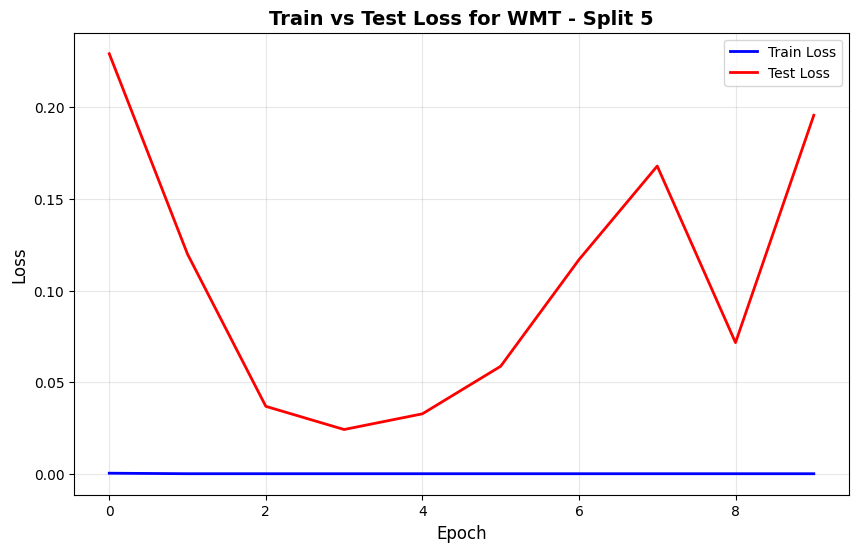

1904/1904 [==============================] - 7s 4ms/step


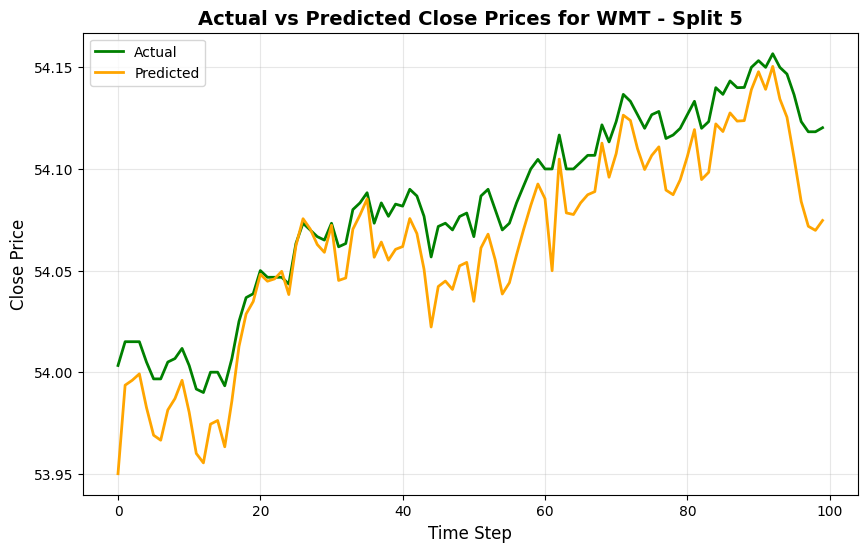

Completed for stock: WMT. Model, scalers, and graphs saved.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Define temporal and news columns
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]
news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Directory to save models, scalers, and plots
save_dir = "/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models"
os.makedirs(save_dir, exist_ok=True)


# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# GPU Setup
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth set.")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")

# Clear any previous TensorFlow sessions
K.clear_session()

# Train, evaluate, and save the model for each stock
for stock_label in stock_labels:
    stock_dir = os.path.join(save_dir, stock_label)
    os.makedirs(stock_dir, exist_ok=True)

    stock_data = combined_data_cleaned[combined_data_cleaned[stock_label] == 1]
    if stock_data.empty:
        print(f"Skipping {stock_label}.")
        continue

    tscv = TimeSeriesSplit(n_splits=5)

    for split_idx, (train_index, test_index) in enumerate(tscv.split(stock_data)):
        train_data, test_data = stock_data.iloc[train_index], stock_data.iloc[test_index]

        X_train = train_data[temporal_columns + news_columns].dropna()
        X_test = test_data[temporal_columns + news_columns].dropna()

        scaler_temporal = MinMaxScaler()
        X_train_temporal = scaler_temporal.fit_transform(X_train[temporal_columns])
        X_test_temporal = scaler_temporal.transform(X_test[temporal_columns])

        X_train_news = X_train[news_columns].values
        X_test_news = X_test[news_columns].values

        y_train = train_data['close'].loc[X_train.index].values.reshape(-1, 1)
        y_test = test_data['close'].loc[X_test.index].values.reshape(-1, 1)

        scaler_close = MinMaxScaler()
        y_train_scaled = scaler_close.fit_transform(y_train)
        y_test_scaled = scaler_close.transform(y_test)

        # Defining the model with two input layers
        temporal_input = Input(shape=(X_train_temporal.shape[1], 1), name='Temporal_Input')
        temporal_lstm = LSTM(50, activation='relu')(temporal_input)

        news_input = Input(shape=(X_train_news.shape[1],1), name='News_Input')
        news_lstm = LSTM(50, activation='relu')(news_input)

        combined = concatenate([temporal_lstm, news_lstm], name='Concatenated_Layers')
        output = Dense(1, activation='linear')(combined)

        model = Model(inputs=[temporal_input, news_input], outputs=output)
        model.compile(optimizer='adam', loss=Huber(delta=1.0))

        # Prepare inputs for the model
        X_train_temporal_reshaped = X_train_temporal.reshape(X_train_temporal.shape[0], X_train_temporal.shape[1], 1)
        X_test_temporal_reshaped = X_test_temporal.reshape(X_test_temporal.shape[0], X_test_temporal.shape[1], 1)

        history = model.fit(
            [X_train_temporal_reshaped, X_train_news],
            y_train_scaled,
            validation_data=([X_test_temporal_reshaped, X_test_news], y_test_scaled),
            epochs=10,
            batch_size=32,
            verbose=1
        )

        # Plot Train vs Test Loss
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
        plt.plot(history.history['val_loss'], label='Test Loss', color='red', linewidth=2)
        plt.title(f'Train vs Test Loss for {stock_label} - Split {split_idx + 1}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.savefig(os.path.join(stock_dir, f'split_{split_idx + 1}_loss.png'))
        plt.show()

        # Predict on test data
        y_pred_scaled = model.predict([X_test_temporal_reshaped, X_test_news])
        y_pred = scaler_close.inverse_transform(y_pred_scaled)
        y_test = scaler_close.inverse_transform(y_test_scaled)

        # Plot Actual vs Predicted for the Split
        plt.figure(figsize=(10, 6))
        plt.plot(y_test[:100], color='green', label='Actual', linewidth=2)
        plt.plot(y_pred[:100], color='orange', label='Predicted', linewidth=2)
        plt.title(f'Actual vs Predicted Close Prices for {stock_label} - Split {split_idx + 1}', fontsize=14, fontweight='bold')
        plt.xlabel('Time Step', fontsize=12)
        plt.ylabel('Close Price', fontsize=12)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.savefig(os.path.join(stock_dir, f'split_{split_idx + 1}_pred.png'))
        plt.show()

    model.save(f"{save_dir}/{stock_label}_lstm_model.h5")
    joblib.dump(scaler_temporal, os.path.join(stock_dir, f'{stock_label}_scaler_temporal.pkl'))
    joblib.dump(scaler_close, os.path.join(stock_dir, f'{stock_label}_scaler_close.pkl'))

    print(f"Completed for stock: {stock_label}. Model, scalers, and graphs saved.")


In [ ]:
# Predefined data for prediction
stock_label = "AAPL"

# Predefined sentiment data obtained from the news for 3rd September 2024 to predict 4th September 2024 close price
sentiments = ["neutral", "neutral", "positive", "neutral", "positive", "positive", "neutral", "neutral", "neutral", "neutral", "neutral", "neutral", "neutral", "positive"]
sentiment_scores = [0.521037936, 0.778412938, 0.510360777, 0.842239499, 0.749215782, 0.954262733, 0.881927431, 0.777241707, 0.765435457, 0.828298986, 0.7543962, 0.876369417, 0.826664686, 0.802737594]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 228.55,
    "high": 229.00,
    "low": 221.17,
    "volume": 49286866,
    "volume weighted average price": 223.8154,
    "SMA_5": 209.1899999999999,
    "SMA_10": 213.45100000000008,
    "SMA_20": 222.56600000000012,
    "SMA_50": 221.28220000000002,
    "SMA_60": 219.6708333333334,
    "EMA_9": 211.4639196393477,
    "EMA_12": 225.62720290867387,
    "EMA_26": 213.4565381901201,
    "RSI_7": 48.3956190762857,
    "RSI_14": 49.15194692118781,
    "RSI_21": 49.08971621238609,
    "RSI_30": 54.7212381121252,
    'MACD_Value': 2.3062553421160317,
    'MACD_Histogram': 0.05607379602871676,
    'MACD_Signal': 2.250181546087315,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")


1/1 [==============================] - 0s 199ms/step
Predicted close price for AAPL on 4th September 2024: 221.10


In [ ]:
# Predefined data for prediction
stock_label = "MSFT"

# Predefined sentiment data
sentiments = ["neutral", "negative", "neutral", "negative", "positive", "positive", "positive", "neutral", "neutral", "neutral", "positive", "neutral"]
sentiment_scores = [0.471648186, 0.62528187, 0.925715506, 0.900767028, 0.746108711, 0.954507828, 0.95635289, 0.884081185, 0.781802773, 0.745700181, 0.939455509, 0.557901561]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 417.91,
    "high": 419.88,
    "low": 407.03,
    "volume": 19462006,
    "volume weighted average price": 411.7979,
    "SMA_5": 412.8280000000001,
    "SMA_10": 415.8910000000002,
    "SMA_20": 413.21850000000006,
    "SMA_50": 430.66319999999973,
    "SMA_60": 432.2160000000003,
    "EMA_9": 414.08015785757243,
    "EMA_12": 414.5711255503364,
    "EMA_26": 417.9234973685531,
    "RSI_7": 38.61508110686058,
    "RSI_14": 41.43668658111051,
    "RSI_21": 42.73224666056243,
    "RSI_30": 44.01126228622611,
    "MACD_Value": -3.360204011786152,
    "MACD_Histogram": 0.5336571416402722,
    "MACD_Signal": -3.8938611534264242,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")


1/1 [==============================] - 0s 173ms/step
Predicted close price for MSFT on 4th September 2024: 415.31


In [ ]:

# Predefined data for prediction
stock_label = "NVDA"

# Predefined sentiment data
sentiments = [
  "positive", "negative",
    "neutral", "negative", "negative", "neutral", "positive",
    "neutral", "positive", "negative", "positive", "neutral",
    "positive", "neutral"
]

sentiment_scores = [
    0.508565128, 0.954831064,
    0.877620399, 0.973389924, 0.97091043, 0.744575858, 0.587853253,
    0.869964719, 0.548465192, 0.711576283, 0.744700909, 0.818580449,
    0.812138975, 0.93663168
]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 116.01,
    "high": 116.21,
    "low": 107.29,
    "volume": 475246088,
    "volume weighted average price": 110.3423,
    "SMA_5": 119.77400000000003,
    "SMA_10": 123.41900000000001,
    "SMA_20": 118.38750000000005,
    "SMA_50": 119.69779999999999,
    "SMA_60": 120.98463333333329,
    "EMA_9": 119.80221692474205,
    "EMA_12": 120.0997986301233,
    "EMA_26": 119.2793196282357,
    "RSI_7": 29.49964385690508,
    "RSI_14": 40.104644513267424,
    "RSI_21": 44.3551326714741,
    "RSI_30": 46.292719959794844,
    "MACD_Value": 0.8216814947326583,
    "MACD_Histogram": -1.0315874358723303,
    "MACD_Signal": 1.8532689306049885,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")

1/1 [==============================] - 0s 157ms/step
Predicted close price for NVDA on 4th September 2024: 71.28


In [ ]:
# Predefined data for prediction
stock_label = "AMZN"

# Predefined sentiment data
sentiments = ["positive", "neutral", "neutral", "neutral", "positive", "positive", "positive", "negative", "neutral", "negative", "neutral", "neutral"]
sentiment_scores = [0.518846035, 0.767621756, 0.911620915, 0.931527495, 0.515375614, 0.949951887, 0.723444641, 0.93629241, 0.835130453, 0.968014121, 0.458437473, 0.802264512]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 172.78,
    "high": 178.9,
    "low": 172.6,
    "volume": 42257863,
    "volume weighted average price": 176.5299,
    "SMA_5": 174.0080000000001,
    "SMA_10": 176.04199999999997,
    "SMA_20": 172.79449999999994,
    "SMA_50": 182.51319999999993,
    "SMA_60": 182.7975,
    "EMA_9":  174.88887497211084,
    "EMA_12": 175.07788919208102,
    "EMA_26": 176.18291576187863,
    "RSI_7": 62.02353934358986,
    "RSI_14": 53.54313772952086,
    "RSI_21": 50.21460707498378,
    "RSI_30": 47.841106217942915,
    "MACD_Value": -1.1182748825577846,
    "MACD_Histogram": 0.725074338294903,
    "MACD_Signal": -1.8433492208526876,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")

1/1 [==============================] - 0s 156ms/step
Predicted close price for AMZN on 4th September 2024: 176.55


In [ ]:
# Predefined data for prediction
stock_label = "GOOGL"

# Predefined sentiment data
sentiments = [
    "neutral",
    "negative",
    "neutral",
    "positive",
    "negative",
    "positive",
    "negative",
    "neutral",
    "negative",
    "positive",
    "neutral"
]

sentiment_scores = [
    0.726976633, 0.96041131, 0.673122823, 0.811012983, 0.942497671,
    0.955927193, 0.974612296, 0.940546274, 0.96563518, 0.885467947,
    0.926060915
]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 161.72,
    "high": 161.85,
    "low": 156.48,
    "volume": 38031833,
    "volume weighted average price": 158.9409,
    "SMA_5": 162.01000000000005,
    "SMA_10": 163.86599999999999,
    "SMA_20": 162.96699999999998,
    "SMA_50": 172.87460000000019,
    "SMA_60": 173.46366666666665,
    "EMA_9": 162.5537656392435,
    "EMA_12": 163.0667613386203,
    "EMA_26": 165.59702105781454,
    "RSI_7": 29.039567853112644,
    "RSI_14": 35.34310029486055,
    "RSI_21": 37.60752471034145,
    "RSI_30": 41.12008540712164,
    "MACD_Value": -2.5332281687931584,
    "MACD_Histogram": 0.07755016895183342,
    "MACD_Signal": -2.610778337744992,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")

1/1 [==============================] - 0s 163ms/step
Predicted close price for GOOGL on 4th September 2024: 152.37


In [ ]:
# Predefined data for prediction
stock_label = "BRK.B"

# Predefined sentiment data
sentiments = ["neutral", "negative", "neutral","positive", "positive"]
sentiment_scores = [0.841181219, 0.599059343, 0.738571465, 0.527649462, 0.683216691]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 475,
    "high": 482.89,
    "low": 473.72,
    "volume": 7365009,
    "volume weighted average price": 477.9928,
    "SMA_5": 469.26799999999986,
    "SMA_10": 459.82000000000005,
    "SMA_20": 447.2979999999998,
    "SMA_50": 433.2535999999997,
    "SMA_60": 429.1663333333332,
    "EMA_9": 463.2676716677056,
    "EMA_12": 459.49445396765464,
    "EMA_26": 448.2080995724791,
    "RSI_7": 92.08044750948234,
    "RSI_14": 80.88088385828013,
    "RSI_21": 74.98953282420716,
    "RSI_30": 70.59261994682504,
    "MACD_Value": 11.287279761182845,
    "MACD_Histogram": 2.9467160728556117,
    "MACD_Signal": 8.340563688327233,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")


1/1 [==============================] - 0s 163ms/step
Predicted close price for BRK.B on 4th September 2024: 534.92


In [ ]:
# Predefined data for prediction
stock_label = "LLY"

# Predefined sentiment data
sentiments = ["positive", "positive", "negative", "neutral", "positive", "positive", "positive", "negative", "neutral", "neutral"]
sentiment_scores = [
    0.906265199, 0.918700159, 0.823398769, 0.771419466, 0.900568306,
    0.957676709, 0.893721342, 0.963812888, 0.779168129, 0.878457725
]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 957.77,
    "high": 969.6499,
    "low": 951.5801,
    "volume": 2451466,
    "volume weighted average price": 959.7218,
    "SMA_5": 952.0339999999997,
    "SMA_10": 951.9550000000006,
    "SMA_20": 916.0740000000003,
    "SMA_50": 893.7369999999999,
    "SMA_60": 890.718,
    "EMA_9": 946.5037181371914,
    "EMA_12": 939.9766181060576,
    "EMA_26": 914.7831474268933,
    "RSI_7": 67.23863914913274,
    "RSI_14": 62.883577511912755,
    "RSI_21": 61.20309515112658,
    "RSI_30": 59.11859938247178,
    "MACD_Value": 25.184065807478532,
    "MACD_Histogram": 2.533820678715948,
    "MACD_Signal": 22.650245128762585,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")

1/1 [==============================] - 0s 165ms/step
Predicted close price for LLY on 4th September 2024: 778.56


In [ ]:
# Predefined data for prediction
stock_label = "AVGO"

# Predefined sentiment data
sentiments = sentiments = ["negative", "negative", "negative", "neutral", "positive", "negative", "neutral"]
sentiment_scores = [
    0.973433733, 0.893065691, 0.923394144, 0.786220431, 0.959985316,
    0.712711513, 0.81589967
]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 160.38,
    "high": 160.74,
    "low": 151.38,
    "volume": 36195392,
    "volume weighted average price": 154.027,
    "SMA_5": 158.42200000000008,
    "SMA_10": 161.21600000000004,
    "SMA_20": 157.41899999999995,
    "SMA_50": 159.18546000000003,
    "SMA_60": 159.72498333333345,
    "EMA_9": 159.12313519793483,
    "EMA_12": 159.1545728751752,
    "EMA_26": 158.2208583227997,
    "RSI_7": 38.55930672032744,
    "RSI_14": 44.92770284052584,
    "RSI_21": 47.30602211306995,
    "RSI_30": 48.72941358324817,
    "MACD_Value": 0.9306215067641403,
    "MACD_Histogram": -0.48444426583024214,
    "MACD_Signal":  1.4150657725943825,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")

1/1 [==============================] - 0s 153ms/step
Predicted close price for AVGO on 4th September 2024: 150.55


In [ ]:
stock_label = "TSLA"

# Predefined sentiment data
sentiments = ["neutral", "positive", "positive", "positive", "positive",
              "neutral", "positive", "positive", "neutral"]
sentiment_scores = [0.913021147, 0.914607108, 0.95432812, 0.956221163,
                    0.949322104, 0.75911063, 0.954531372, 0.863035619, 0.763261855]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 215.26,
    "high": 219.9043,
    "low": 209.64,
    "volume": 76489824,
    "volume weighted average price": 214.3078,
    "SMA_5": 227.21599999999998,
    "SMA_10": 226.7539999999999,
    "SMA_20": 209.27150000000006,
    "SMA_50": 221.9032,
    "SMA_60": 214.34483333333344,
    "EMA_9": 226.14063026894215,
    "EMA_12": 211.8176415398246,
    "EMA_26": 223.31463791184734,
    "RSI_7": 40.536546914949604,
    "RSI_14": 49.79656589845109,
    "RSI_21": 52.33654972225781,
    "RSI_30": 50.19618079957056,
    "MACD_Value": -1.6646026862961492,
    "MACD_Histogram": 0.060256863923116466,
    "MACD_Signal":  -1.7248595502192656,
    "granularity": 0
}


# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")

1/1 [==============================] - 0s 151ms/step
Predicted close price for TSLA on 4th September 2024: 206.76


In [ ]:
# Predefined data for prediction
stock_label = "WMT"

# Predefined sentiment data
sentiments = ["positive", "negative", "negative", "negative", "neutral"]
sentiment_scores = [
    0.787895024, 0.694346189, 0.894682169, 0.915135503, 0.76587671
]

# Select the sentiment with the highest sentiment score
max_index = sentiment_scores.index(max(sentiment_scores))
selected_sentiment = sentiments[max_index]
selected_sentiment_score = sentiment_scores[max_index]

# Create sentiment encoding based on the selected sentiment
sentiment_encoding = {
    'positive': [1.0, 0.0, 0.0],
    'neutral': [0.0, 1.0, 0.0],
    'negative': [0.0, 0.0, 1.0]
}
selected_sentiment_encoding = sentiment_encoding[selected_sentiment]

# Temporal features for prediction
temporal_features = {
    "open": 77.33,
    "high": 77.81,
    "low": 76.795,
    "volume": 21524868,
    "volume weighted average price": 77.3842,
    "SMA_5": 76.60600000000002,
    "SMA_10": 76.012,
    "SMA_20": 72.81100000000004,
    "SMA_50": 70.72399999999998,
    "SMA_60": 70.11233333333331,
    "EMA_9": 75.85586140871555,
    "EMA_12": 75.24182399638738,
    "EMA_26": 73.14227508471562,
    "RSI_7": 88.64221051080791,
    "RSI_14": 78.79680186015884,
    "RSI_21": 74.36739607335574,
    "RSI_30": 71.28184632076395,
    "MACD_Value": 2.099206296535712,
    "MACD_Histogram": 0.35962748126548805,
    "MACD_Signal": 1.739578815270224,
    "granularity": 0
}

# Scale volume manually
volume_max = 1e8
volume_min = 1e4
temporal_features["volume"] = (temporal_features["volume"] - volume_min) / (volume_max - volume_min)

# Define columns for temporal data
temporal_columns = [
    'open', 'high', 'low', 'volume', 'volume weighted average price',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_60', 'EMA_9', 'EMA_12', 'EMA_26',
    'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'MACD_Value', 'MACD_Histogram', 'MACD_Signal', 'granularity'
]

# File paths for model and scalers
model_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}_lstm_model.h5"
scaler_temporal_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_temporal.pkl"
scaler_y_path = f"/content/drive/MyDrive/Stocks/Two_Layer_LSTM_With_News_models/{stock_label}/{stock_label}_scaler_close.pkl"

# Load the trained model and scalers
try:
    model = load_model(model_path)
    scaler_temporal = joblib.load(scaler_temporal_path)
    scaler_y = joblib.load(scaler_y_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Model or scaler files for {stock_label} not found.")


news_columns = ['Sentiment_Score', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative']

# Prepare temporal feature array for prediction
temporal_df = pd.DataFrame([temporal_features], columns=temporal_features.keys())
X_temporal_scaled = scaler_temporal.transform(temporal_df)

# Prepare the news input features based on the highest sentiment score
X_news = np.array([selected_sentiment_score] + selected_sentiment_encoding).reshape(1, -1)

# Reshape temporal input for the LSTM layer
X_temporal_scaled = X_temporal_scaled.reshape(1, X_temporal_scaled.shape[1], 1)

# Predict the next day's close price
y_pred_scaled = model.predict([X_temporal_scaled, X_news])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Define the next day explicitly
next_day_date = "4th September 2024"

# Print the predicted close price with the next day's date
print(f"Predicted close price for {stock_label} on {next_day_date}: {y_pred[0][0]:.2f}")

1/1 [==============================] - 0s 159ms/step
Predicted close price for WMT on 4th September 2024: 119.07
